In [ ]:
!pip install ultralytics lap norfair

In [ ]:
import os
import cv2
import numpy as np
import norfair
from tqdm import tqdm
from ultralytics import YOLO



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!rm -f /content/*.npz

In [ ]:
# Load YOLO best model
yolo_model = YOLO("yolov8n.pt")  # ganti path ke best.pt kamu
print(yolo_model.names)
tracker = norfair.Tracker(distance_function="iou", distance_threshold=0.7)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [ ]:
def process_video(video_path, label, model, tracker, sequence_length=60):
    cap = cv2.VideoCapture(video_path)
    sequence = []
    frame_count = 0
    person_detected_total = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1

        results = model(frame, conf=0.25, iou=0.4, verbose=False)

        detections = []

        # Ambil hanya class 'person' (0)
        persons = [r for r in results[0].boxes if int(r.cls[0]) == 0]

        if persons:
            # Pilih kotak dengan confidence tertinggi
            best_box = max(persons, key=lambda b: b.conf[0])
            x1, y1, x2, y2 = best_box.xyxy[0].cpu().numpy()

            detections.append(
                norfair.Detection(points=np.array([[x1, y1], [x2, y2]]))
            )
            person_detected_total += 1

        tracked_objects = tracker.update(detections=detections)

        for obj in tracked_objects:
            x_min, y_min = obj.estimate[0]
            x_max, y_max = obj.estimate[1]
            w = x_max - x_min
            h = y_max - y_min
            sequence.append([x_min, y_min, w, h])

    cap.release()

    # Padding/truncating
    if len(sequence) < sequence_length:
        sequence += [[0, 0, 0, 0]] * (sequence_length - len(sequence))
    else:
        sequence = sequence[:sequence_length]

    return np.array(sequence, dtype=np.float32), label, frame_count, person_detected_total

In [ ]:
features, label, frame_count, person_count = process_video(
    "/content/drive/MyDrive/dataset/Subject 1/ADL/04.mp4",
    label=1,
    model=yolo_model,
    tracker=tracker,
    sequence_length=30,
    save_preview=True,
    preview_path="/content/output_preview.mp4"
)

In [ ]:

dataset_dir = "/content/drive/MyDrive/dataset"
sequence_length = 60
batch_size = 50  # jumlah video per batch
X_batch, y_batch = [], []
batch_count = 0

# Baca daftar video yang sudah diproses
if os.path.exists("processed_videos.txt"):
    with open("processed_videos.txt", "r") as f:
        processed_videos = set(line.strip() for line in f.readlines())
else:
    processed_videos = set()

class_map = {"nonJatuh": 0, "jatuh": 1}

# Hitung total video
total_videos = 0
for label_name in class_map.keys():
    class_path = os.path.join(dataset_dir, label_name)
    if os.path.exists(class_path):
        video_files = [f for f in os.listdir(class_path) if f.lower().endswith((".mp4", ".avi", ".mov"))]
        total_videos += len(video_files)
print(f"Total video ditemukan: {total_videos}")

# Loop dataset
processed_count = 0
for label_name, label_value in class_map.items():
    class_path = os.path.join(dataset_dir, label_name)
    if not os.path.exists(class_path):
        continue

    video_files = [f for f in os.listdir(class_path) if f.lower().endswith((".mp4", ".avi", ".mov"))]
    for filename in tqdm(video_files, desc=f"{label_name}"):
        video_path = os.path.join(class_path, filename)

        # Skip jika video sudah diproses
        if video_path in processed_videos:
            print(f"Skip {filename}, sudah diproses.")
            continue

        processed_count += 1
        tracker = norfair.Tracker(distance_function="iou", distance_threshold=0.7)

        # Ekstraksi fitur
        features, label, frame_count, person_count = process_video(
            video_path, label_value, yolo_model, tracker, sequence_length
        )
        X_batch.append(features)
        y_batch.append(label)

        # Simpan ke log video
        with open("processed_videos.txt", "a") as f:
            f.write(video_path + "\n")

        print(f"[{processed_count}/{total_videos}] {label_name}/{filename} "
              f"| Frames: {frame_count} | Person detections: {person_count}")

        # Simpan batch kalau sudah penuh
        if len(X_batch) >= batch_size:
            batch_file = f"features_batch_{batch_count}.npz"
            if os.path.exists(batch_file):
                print(f"===> Batch {batch_count} SUDAH ADA, dilewati.")
            else:
                np.savez(batch_file, X=np.array(X_batch, dtype=np.float32), y=np.array(y_batch, dtype=np.int32))
                print(f"===> Batch {batch_count} disimpan (size {len(X_batch)})")
            batch_count += 1
            X_batch, y_batch = [], []

# Simpan sisa batch terakhir
if X_batch:
    batch_file = f"features_batch_{batch_count}.npz"
    if os.path.exists(batch_file):
        print(f"===> Batch {batch_count} SUDAH ADA, dilewati.")
    else:
        np.savez(batch_file, X=np.array(X_batch, dtype=np.float32), y=np.array(y_batch, dtype=np.int32))
        print(f"===> Batch {batch_count} disimpan (size {len(X_batch)})")

Total video ditemukan: 1352


nonJatuh:   0%|          | 1/677 [00:00<04:02,  2.79it/s]

[1/1352] nonJatuh/video_102_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   0%|          | 2/677 [00:00<04:00,  2.80it/s]

[2/1352] nonJatuh/video_105.avi | Frames: 30 | Person detections: 15


nonJatuh:   0%|          | 3/677 [00:01<03:53,  2.88it/s]

[3/1352] nonJatuh/video_109_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   1%|          | 4/677 [00:01<03:51,  2.90it/s]

[4/1352] nonJatuh/video_108.avi | Frames: 30 | Person detections: 0


nonJatuh:   1%|          | 5/677 [00:01<03:48,  2.95it/s]

[5/1352] nonJatuh/video_102.avi | Frames: 30 | Person detections: 0


nonJatuh:   1%|          | 6/677 [00:02<03:45,  2.98it/s]

[6/1352] nonJatuh/video_106_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   1%|          | 7/677 [00:03<06:03,  1.84it/s]

[7/1352] nonJatuh/video_106.avi | Frames: 30 | Person detections: 0


nonJatuh:   1%|          | 8/677 [00:04<10:00,  1.11it/s]

[8/1352] nonJatuh/video_108_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   1%|▏         | 9/677 [00:05<11:10,  1.00s/it]

[9/1352] nonJatuh/video_100_flip.avi | Frames: 87 | Person detections: 85


nonJatuh:   1%|▏         | 10/677 [00:06<09:23,  1.18it/s]

[10/1352] nonJatuh/video_104_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   2%|▏         | 11/677 [00:06<08:08,  1.36it/s]

[11/1352] nonJatuh/video_101_flip.avi | Frames: 30 | Person detections: 2


nonJatuh:   2%|▏         | 12/677 [00:07<07:07,  1.56it/s]

[12/1352] nonJatuh/video_104.avi | Frames: 30 | Person detections: 0


nonJatuh:   2%|▏         | 13/677 [00:07<06:48,  1.63it/s]

[13/1352] nonJatuh/video_103_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   2%|▏         | 14/677 [00:08<06:15,  1.77it/s]

[14/1352] nonJatuh/video_101.avi | Frames: 30 | Person detections: 4


nonJatuh:   2%|▏         | 15/677 [00:08<05:31,  1.99it/s]

[15/1352] nonJatuh/video_109.avi | Frames: 30 | Person detections: 0


nonJatuh:   2%|▏         | 16/677 [00:09<04:59,  2.20it/s]

[16/1352] nonJatuh/video_112_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   3%|▎         | 17/677 [00:09<04:37,  2.37it/s]

[17/1352] nonJatuh/video_119.avi | Frames: 30 | Person detections: 11


nonJatuh:   3%|▎         | 18/677 [00:10<06:28,  1.70it/s]

[18/1352] nonJatuh/video_12.avi | Frames: 87 | Person detections: 87


nonJatuh:   3%|▎         | 19/677 [00:10<05:37,  1.95it/s]

[19/1352] nonJatuh/video_144_flip.avi | Frames: 30 | Person detections: 6


nonJatuh:   3%|▎         | 20/677 [00:11<05:08,  2.13it/s]

[20/1352] nonJatuh/video_157.avi | Frames: 30 | Person detections: 11


nonJatuh:   3%|▎         | 21/677 [00:11<04:40,  2.34it/s]

[21/1352] nonJatuh/video_132_flip.avi | Frames: 30 | Person detections: 9


nonJatuh:   3%|▎         | 22/677 [00:11<04:18,  2.54it/s]

[22/1352] nonJatuh/video_146_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   3%|▎         | 23/677 [00:12<04:08,  2.64it/s]

[23/1352] nonJatuh/video_120_flip.avi | Frames: 30 | Person detections: 1


nonJatuh:   4%|▎         | 24/677 [00:12<03:56,  2.76it/s]

[24/1352] nonJatuh/video_110.avi | Frames: 30 | Person detections: 0


nonJatuh:   4%|▎         | 25/677 [00:12<03:49,  2.84it/s]

[25/1352] nonJatuh/video_112.avi | Frames: 30 | Person detections: 0
[26/1352] nonJatuh/video_118.avi | Frames: 7 | Person detections: 0


nonJatuh:   4%|▍         | 27/677 [00:13<03:08,  3.46it/s]

[27/1352] nonJatuh/video_164_flip.avi | Frames: 30 | Person detections: 2


nonJatuh:   4%|▍         | 28/677 [00:13<03:13,  3.35it/s]

[28/1352] nonJatuh/video_110_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   4%|▍         | 29/677 [00:13<03:22,  3.21it/s]

[29/1352] nonJatuh/video_145_flip.avi | Frames: 30 | Person detections: 6


nonJatuh:   4%|▍         | 30/677 [00:14<03:31,  3.06it/s]

[30/1352] nonJatuh/video_157_flip.avi | Frames: 30 | Person detections: 8
[31/1352] nonJatuh/video_123.avi | Frames: 1 | Person detections: 0
[32/1352] nonJatuh/video_149.avi | Frames: 1 | Person detections: 0


nonJatuh:   5%|▍         | 33/677 [00:15<03:23,  3.17it/s]

[33/1352] nonJatuh/video_13_flip.avi | Frames: 77 | Person detections: 77


nonJatuh:   5%|▌         | 34/677 [00:15<03:23,  3.16it/s]

[34/1352] nonJatuh/video_163.avi | Frames: 30 | Person detections: 0


nonJatuh:   5%|▌         | 35/677 [00:15<03:29,  3.07it/s]

[35/1352] nonJatuh/video_128.avi | Frames: 30 | Person detections: 7


nonJatuh:   5%|▌         | 36/677 [00:16<03:33,  3.00it/s]

[36/1352] nonJatuh/video_144.avi | Frames: 30 | Person detections: 0


nonJatuh:   5%|▌         | 37/677 [00:16<03:30,  3.04it/s]

[37/1352] nonJatuh/video_130.avi | Frames: 30 | Person detections: 0


nonJatuh:   6%|▌         | 38/677 [00:17<05:05,  2.09it/s]

[38/1352] nonJatuh/video_11.avi | Frames: 80 | Person detections: 80


nonJatuh:   6%|▌         | 39/677 [00:17<04:40,  2.28it/s]

[39/1352] nonJatuh/video_111_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   6%|▌         | 40/677 [00:18<04:24,  2.41it/s]

[40/1352] nonJatuh/video_155.avi | Frames: 30 | Person detections: 30


nonJatuh:   6%|▌         | 41/677 [00:18<04:40,  2.27it/s]

[41/1352] nonJatuh/video_132.avi | Frames: 30 | Person detections: 15


nonJatuh:   6%|▌         | 42/677 [00:18<04:40,  2.26it/s]

[42/1352] nonJatuh/video_129.avi | Frames: 30 | Person detections: 0


nonJatuh:   6%|▋         | 43/677 [00:19<04:52,  2.17it/s]

[43/1352] nonJatuh/video_141.avi | Frames: 30 | Person detections: 0


nonJatuh:   6%|▋         | 44/677 [00:19<04:51,  2.17it/s]

[44/1352] nonJatuh/video_142_flip.avi | Frames: 30 | Person detections: 1
[45/1352] nonJatuh/video_149_flip.avi | Frames: 1 | Person detections: 0


nonJatuh:   7%|▋         | 46/677 [00:20<03:58,  2.65it/s]

[46/1352] nonJatuh/video_131_flip.avi | Frames: 30 | Person detections: 30


nonJatuh:   7%|▋         | 47/677 [00:21<04:25,  2.37it/s]

[47/1352] nonJatuh/video_148_flip.avi | Frames: 30 | Person detections: 30


nonJatuh:   7%|▋         | 48/677 [00:22<05:57,  1.76it/s]

[48/1352] nonJatuh/video_14.avi | Frames: 75 | Person detections: 75


nonJatuh:   7%|▋         | 49/677 [00:22<05:16,  1.98it/s]

[49/1352] nonJatuh/video_117.avi | Frames: 30 | Person detections: 0
[50/1352] nonJatuh/video_118_flip.avi | Frames: 7 | Person detections: 0
===> Batch 0 disimpan (size 50)


nonJatuh:   8%|▊         | 51/677 [00:22<03:54,  2.67it/s]

[51/1352] nonJatuh/video_122.avi | Frames: 30 | Person detections: 0


nonJatuh:   8%|▊         | 52/677 [00:23<03:46,  2.76it/s]

[52/1352] nonJatuh/video_111.avi | Frames: 30 | Person detections: 0


nonJatuh:   8%|▊         | 53/677 [00:23<03:39,  2.85it/s]

[53/1352] nonJatuh/video_116.avi | Frames: 30 | Person detections: 0
[54/1352] nonJatuh/video_154_flip.avi | Frames: 2 | Person detections: 0


nonJatuh:   8%|▊         | 55/677 [00:23<02:56,  3.52it/s]

[55/1352] nonJatuh/video_134.avi | Frames: 30 | Person detections: 15


nonJatuh:   8%|▊         | 56/677 [00:24<02:59,  3.47it/s]

[56/1352] nonJatuh/video_122_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:   8%|▊         | 57/677 [00:25<04:39,  2.22it/s]

[57/1352] nonJatuh/video_12_flip.avi | Frames: 87 | Person detections: 87
[58/1352] nonJatuh/video_154.avi | Frames: 2 | Person detections: 1


nonJatuh:   9%|▊         | 59/677 [00:25<03:27,  2.98it/s]

[59/1352] nonJatuh/video_120.avi | Frames: 30 | Person detections: 0


nonJatuh:   9%|▉         | 60/677 [00:25<03:29,  2.94it/s]

[60/1352] nonJatuh/video_114.avi | Frames: 30 | Person detections: 4


nonJatuh:   9%|▉         | 61/677 [00:26<03:29,  2.94it/s]

[61/1352] nonJatuh/video_164.avi | Frames: 30 | Person detections: 26


nonJatuh:   9%|▉         | 62/677 [00:26<04:50,  2.12it/s]

[62/1352] nonJatuh/video_13.avi | Frames: 77 | Person detections: 77
[63/1352] nonJatuh/video_152.avi | Frames: 1 | Person detections: 0


nonJatuh:   9%|▉         | 64/677 [00:27<03:30,  2.91it/s]

[64/1352] nonJatuh/video_113_flip.avi | Frames: 30 | Person detections: 1
[65/1352] nonJatuh/video_152_flip.avi | Frames: 1 | Person detections: 0


nonJatuh:  10%|▉         | 66/677 [00:27<02:50,  3.59it/s]

[66/1352] nonJatuh/video_129_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  10%|▉         | 67/677 [00:27<03:03,  3.33it/s]

[67/1352] nonJatuh/video_140_flip.avi | Frames: 30 | Person detections: 27


nonJatuh:  10%|█         | 68/677 [00:28<03:07,  3.25it/s]

[68/1352] nonJatuh/video_115.avi | Frames: 30 | Person detections: 0


nonJatuh:  10%|█         | 69/677 [00:28<03:16,  3.10it/s]

[69/1352] nonJatuh/video_142.avi | Frames: 30 | Person detections: 1


nonJatuh:  10%|█         | 70/677 [00:29<03:18,  3.06it/s]

[70/1352] nonJatuh/video_165.avi | Frames: 30 | Person detections: 6
[71/1352] nonJatuh/video_126.avi | Frames: 7 | Person detections: 7


nonJatuh:  11%|█         | 72/677 [00:29<02:46,  3.63it/s]

[72/1352] nonJatuh/video_134_flip.avi | Frames: 30 | Person detections: 7
[73/1352] nonJatuh/video_123_flip.avi | Frames: 1 | Person detections: 0


nonJatuh:  11%|█         | 74/677 [00:30<03:32,  2.84it/s]

[74/1352] nonJatuh/video_15.avi | Frames: 84 | Person detections: 84


nonJatuh:  11%|█         | 75/677 [00:30<03:26,  2.92it/s]

[75/1352] nonJatuh/video_147.avi | Frames: 30 | Person detections: 0


nonJatuh:  11%|█         | 76/677 [00:31<03:25,  2.93it/s]

[76/1352] nonJatuh/video_130_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  11%|█▏        | 77/677 [00:32<05:34,  1.80it/s]

[77/1352] nonJatuh/video_15_flip.avi | Frames: 84 | Person detections: 84


nonJatuh:  12%|█▏        | 78/677 [00:32<05:35,  1.79it/s]

[78/1352] nonJatuh/video_143_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  12%|█▏        | 79/677 [00:33<05:23,  1.85it/s]

[79/1352] nonJatuh/video_124_flip.avi | Frames: 30 | Person detections: 7


nonJatuh:  12%|█▏        | 80/677 [00:33<05:08,  1.93it/s]

[80/1352] nonJatuh/video_160_flip.avi | Frames: 30 | Person detections: 3


nonJatuh:  12%|█▏        | 81/677 [00:34<05:10,  1.92it/s]

[81/1352] nonJatuh/video_121_flip.avi | Frames: 30 | Person detections: 1


nonJatuh:  12%|█▏        | 82/677 [00:34<05:06,  1.94it/s]

[82/1352] nonJatuh/video_136_flip.avi | Frames: 30 | Person detections: 10


nonJatuh:  12%|█▏        | 83/677 [00:35<04:38,  2.14it/s]

[83/1352] nonJatuh/video_119_flip.avi | Frames: 30 | Person detections: 10


nonJatuh:  12%|█▏        | 84/677 [00:35<04:12,  2.35it/s]

[84/1352] nonJatuh/video_143.avi | Frames: 30 | Person detections: 0


nonJatuh:  13%|█▎        | 85/677 [00:35<03:53,  2.54it/s]

[85/1352] nonJatuh/video_209.avi | Frames: 30 | Person detections: 1


nonJatuh:  13%|█▎        | 86/677 [00:36<03:41,  2.67it/s]

[86/1352] nonJatuh/video_173_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  13%|█▎        | 87/677 [00:36<03:35,  2.73it/s]

[87/1352] nonJatuh/video_17_flip.avi | Frames: 30 | Person detections: 30


nonJatuh:  13%|█▎        | 88/677 [00:36<03:28,  2.82it/s]

[88/1352] nonJatuh/video_187_flip.avi | Frames: 30 | Person detections: 1


nonJatuh:  13%|█▎        | 89/677 [00:37<03:23,  2.89it/s]

[89/1352] nonJatuh/video_182.avi | Frames: 30 | Person detections: 0


nonJatuh:  13%|█▎        | 90/677 [00:37<03:24,  2.87it/s]

[90/1352] nonJatuh/video_168_flip.avi | Frames: 30 | Person detections: 5


nonJatuh:  13%|█▎        | 91/677 [00:37<03:24,  2.86it/s]

[91/1352] nonJatuh/video_208_flip.avi | Frames: 30 | Person detections: 29
[92/1352] nonJatuh/video_177_flip.avi | Frames: 7 | Person detections: 0


nonJatuh:  14%|█▎        | 93/677 [00:38<02:47,  3.48it/s]

[93/1352] nonJatuh/video_204.avi | Frames: 30 | Person detections: 0


nonJatuh:  14%|█▍        | 94/677 [00:38<02:53,  3.37it/s]

[94/1352] nonJatuh/video_188_flip.avi | Frames: 30 | Person detections: 3


nonJatuh:  14%|█▍        | 95/677 [00:38<02:57,  3.29it/s]

[95/1352] nonJatuh/video_202.avi | Frames: 30 | Person detections: 0


nonJatuh:  14%|█▍        | 96/677 [00:39<03:07,  3.10it/s]

[96/1352] nonJatuh/video_194.avi | Frames: 30 | Person detections: 0


nonJatuh:  14%|█▍        | 97/677 [00:39<03:13,  3.00it/s]

[97/1352] nonJatuh/video_207.avi | Frames: 30 | Person detections: 30


nonJatuh:  14%|█▍        | 98/677 [00:39<03:13,  2.98it/s]

[98/1352] nonJatuh/video_190.avi | Frames: 30 | Person detections: 2


nonJatuh:  15%|█▍        | 99/677 [00:40<04:15,  2.26it/s]

[99/1352] nonJatuh/video_20_flip.avi | Frames: 62 | Person detections: 62


nonJatuh:  15%|█▍        | 100/677 [00:41<03:56,  2.44it/s]

[100/1352] nonJatuh/video_196.avi | Frames: 30 | Person detections: 2
===> Batch 1 disimpan (size 50)


nonJatuh:  15%|█▍        | 101/677 [00:41<03:50,  2.50it/s]

[101/1352] nonJatuh/video_199.avi | Frames: 30 | Person detections: 23


nonJatuh:  15%|█▌        | 102/677 [00:41<03:38,  2.63it/s]

[102/1352] nonJatuh/video_206_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  15%|█▌        | 103/677 [00:42<03:27,  2.77it/s]

[103/1352] nonJatuh/video_171_flip.avi | Frames: 30 | Person detections: 4


nonJatuh:  15%|█▌        | 104/677 [00:42<03:22,  2.84it/s]

[104/1352] nonJatuh/video_210.avi | Frames: 30 | Person detections: 0


nonJatuh:  16%|█▌        | 105/677 [00:42<03:19,  2.87it/s]

[105/1352] nonJatuh/video_184_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  16%|█▌        | 106/677 [00:43<03:11,  2.98it/s]

[106/1352] nonJatuh/video_209_flip.avi | Frames: 30 | Person detections: 0
[107/1352] nonJatuh/video_176_flip.avi | Frames: 1 | Person detections: 0


nonJatuh:  16%|█▌        | 108/677 [00:43<02:27,  3.86it/s]

[108/1352] nonJatuh/video_168.avi | Frames: 30 | Person detections: 0


nonJatuh:  16%|█▌        | 109/677 [00:43<02:39,  3.56it/s]

[109/1352] nonJatuh/video_206.avi | Frames: 30 | Person detections: 0


nonJatuh:  16%|█▌        | 110/677 [00:44<02:45,  3.42it/s]

[110/1352] nonJatuh/video_203.avi | Frames: 30 | Person detections: 0


nonJatuh:  16%|█▋        | 111/677 [00:44<02:50,  3.31it/s]

[111/1352] nonJatuh/video_182_flip.avi | Frames: 30 | Person detections: 0
[112/1352] nonJatuh/video_178_flip.avi | Frames: 4 | Person detections: 3
[113/1352] nonJatuh/video_176.avi | Frames: 1 | Person detections: 0


nonJatuh:  17%|█▋        | 114/677 [00:44<02:08,  4.38it/s]

[114/1352] nonJatuh/video_167.avi | Frames: 30 | Person detections: 0


nonJatuh:  17%|█▋        | 115/677 [00:45<02:34,  3.64it/s]

[115/1352] nonJatuh/video_198_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  17%|█▋        | 116/677 [00:45<03:03,  3.06it/s]

[116/1352] nonJatuh/video_183.avi | Frames: 30 | Person detections: 0


nonJatuh:  17%|█▋        | 117/677 [00:46<03:24,  2.74it/s]

[117/1352] nonJatuh/video_198.avi | Frames: 30 | Person detections: 0


nonJatuh:  17%|█▋        | 118/677 [00:46<03:44,  2.49it/s]

[118/1352] nonJatuh/video_195_flip.avi | Frames: 30 | Person detections: 6


nonJatuh:  18%|█▊        | 119/677 [00:47<03:58,  2.34it/s]

[119/1352] nonJatuh/video_205.avi | Frames: 30 | Person detections: 11
[120/1352] nonJatuh/video_166.avi | Frames: 1 | Person detections: 0


nonJatuh:  18%|█▊        | 121/677 [00:47<03:25,  2.71it/s]

[121/1352] nonJatuh/video_194_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  18%|█▊        | 122/677 [00:48<03:22,  2.73it/s]

[122/1352] nonJatuh/video_185_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  18%|█▊        | 123/677 [00:48<03:19,  2.77it/s]

[123/1352] nonJatuh/video_185.avi | Frames: 30 | Person detections: 0


nonJatuh:  18%|█▊        | 124/677 [00:48<03:20,  2.76it/s]

[124/1352] nonJatuh/video_197.avi | Frames: 30 | Person detections: 20


nonJatuh:  18%|█▊        | 125/677 [00:49<04:09,  2.22it/s]

[125/1352] nonJatuh/video_20.avi | Frames: 62 | Person detections: 62


nonJatuh:  19%|█▉        | 127/677 [00:50<03:11,  2.87it/s]

[126/1352] nonJatuh/video_195.avi | Frames: 30 | Person detections: 14
[127/1352] nonJatuh/video_172.avi | Frames: 14 | Person detections: 0


nonJatuh:  19%|█▉        | 128/677 [00:50<03:16,  2.80it/s]

[128/1352] nonJatuh/video_171.avi | Frames: 30 | Person detections: 4


nonJatuh:  19%|█▉        | 129/677 [00:50<03:13,  2.82it/s]

[129/1352] nonJatuh/video_183_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  19%|█▉        | 130/677 [00:51<03:09,  2.88it/s]

[130/1352] nonJatuh/video_167_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  19%|█▉        | 131/677 [00:51<03:06,  2.93it/s]

[131/1352] nonJatuh/video_170_flip.avi | Frames: 30 | Person detections: 1


nonJatuh:  19%|█▉        | 132/677 [00:51<03:07,  2.91it/s]

[132/1352] nonJatuh/video_186.avi | Frames: 30 | Person detections: 0


nonJatuh:  20%|█▉        | 133/677 [00:52<03:07,  2.90it/s]

[133/1352] nonJatuh/video_170.avi | Frames: 30 | Person detections: 11


nonJatuh:  20%|█▉        | 134/677 [00:53<05:39,  1.60it/s]

[134/1352] nonJatuh/video_1_flip.avi | Frames: 115 | Person detections: 115


nonJatuh:  20%|█▉        | 135/677 [00:54<05:24,  1.67it/s]

[135/1352] nonJatuh/video_19_flip.avi | Frames: 48 | Person detections: 48


nonJatuh:  20%|██        | 136/677 [00:54<04:40,  1.93it/s]

[136/1352] nonJatuh/video_204_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  20%|██        | 137/677 [00:54<04:11,  2.15it/s]

[137/1352] nonJatuh/video_173.avi | Frames: 30 | Person detections: 0


nonJatuh:  20%|██        | 138/677 [00:55<03:55,  2.29it/s]

[138/1352] nonJatuh/video_200.avi | Frames: 30 | Person detections: 30


nonJatuh:  21%|██        | 139/677 [00:56<05:22,  1.67it/s]

[139/1352] nonJatuh/video_21.avi | Frames: 90 | Person detections: 90


nonJatuh:  21%|██        | 140/677 [00:56<04:43,  1.89it/s]

[140/1352] nonJatuh/video_207_flip.avi | Frames: 30 | Person detections: 30


nonJatuh:  21%|██        | 141/677 [00:56<04:16,  2.09it/s]

[141/1352] nonJatuh/video_192.avi | Frames: 30 | Person detections: 22


nonJatuh:  21%|██        | 142/677 [00:57<03:59,  2.24it/s]

[142/1352] nonJatuh/video_189_flip.avi | Frames: 30 | Person detections: 13


nonJatuh:  21%|██        | 143/677 [00:57<03:45,  2.37it/s]

[143/1352] nonJatuh/video_201_flip.avi | Frames: 30 | Person detections: 27


nonJatuh:  21%|██▏       | 144/677 [00:57<03:28,  2.56it/s]

[144/1352] nonJatuh/video_188.avi | Frames: 30 | Person detections: 0


nonJatuh:  21%|██▏       | 145/677 [00:58<03:51,  2.30it/s]

[145/1352] nonJatuh/video_199_flip.avi | Frames: 30 | Person detections: 21


nonJatuh:  22%|██▏       | 146/677 [00:58<03:55,  2.26it/s]

[146/1352] nonJatuh/video_221_flip.avi | Frames: 30 | Person detections: 1


nonJatuh:  22%|██▏       | 147/677 [00:59<05:46,  1.53it/s]

[147/1352] nonJatuh/video_232_flip.avi | Frames: 75 | Person detections: 72


nonJatuh:  22%|██▏       | 148/677 [01:00<05:23,  1.64it/s]

[148/1352] nonJatuh/video_212_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  22%|██▏       | 149/677 [01:01<05:15,  1.67it/s]

[149/1352] nonJatuh/video_222.avi | Frames: 30 | Person detections: 6
[150/1352] nonJatuh/video_22_flip.avi | Frames: 4 | Person detections: 4
===> Batch 2 disimpan (size 50)


nonJatuh:  22%|██▏       | 152/677 [01:01<02:58,  2.94it/s]

[151/1352] nonJatuh/video_216_flip.avi | Frames: 30 | Person detections: 2
[152/1352] nonJatuh/video_23.avi | Frames: 10 | Person detections: 10


nonJatuh:  23%|██▎       | 153/677 [01:01<02:56,  2.98it/s]

[153/1352] nonJatuh/video_223_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  23%|██▎       | 154/677 [01:02<03:50,  2.27it/s]

[154/1352] nonJatuh/video_237_flip.avi | Frames: 71 | Person detections: 0


nonJatuh:  23%|██▎       | 155/677 [01:02<03:33,  2.45it/s]

[155/1352] nonJatuh/video_228.avi | Frames: 30 | Person detections: 0


nonJatuh:  23%|██▎       | 156/677 [01:03<03:21,  2.58it/s]

[156/1352] nonJatuh/video_225.avi | Frames: 30 | Person detections: 1


nonJatuh:  23%|██▎       | 157/677 [01:04<04:55,  1.76it/s]

[157/1352] nonJatuh/video_21_flip.avi | Frames: 90 | Person detections: 90


nonJatuh:  23%|██▎       | 158/677 [01:04<04:25,  1.95it/s]

[158/1352] nonJatuh/video_214.avi | Frames: 30 | Person detections: 2


nonJatuh:  23%|██▎       | 159/677 [01:05<04:01,  2.15it/s]

[159/1352] nonJatuh/video_230_flip.avi | Frames: 30 | Person detections: 29


nonJatuh:  24%|██▎       | 160/677 [01:06<05:43,  1.51it/s]

[160/1352] nonJatuh/video_233.avi | Frames: 113 | Person detections: 9


nonJatuh:  24%|██▍       | 161/677 [01:06<04:52,  1.77it/s]

[161/1352] nonJatuh/video_227_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  24%|██▍       | 162/677 [01:06<04:16,  2.01it/s]

[162/1352] nonJatuh/video_210_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  24%|██▍       | 163/677 [01:07<05:00,  1.71it/s]

[163/1352] nonJatuh/video_235_flip.avi | Frames: 78 | Person detections: 5


nonJatuh:  24%|██▍       | 164/677 [01:07<04:21,  1.96it/s]

[164/1352] nonJatuh/video_212.avi | Frames: 30 | Person detections: 0


nonJatuh:  24%|██▍       | 165/677 [01:08<03:58,  2.15it/s]

[165/1352] nonJatuh/video_230.avi | Frames: 30 | Person detections: 30


nonJatuh:  25%|██▍       | 166/677 [01:08<03:40,  2.32it/s]

[166/1352] nonJatuh/video_224_flip.avi | Frames: 30 | Person detections: 2


nonJatuh:  25%|██▍       | 167/677 [01:09<03:25,  2.48it/s]

[167/1352] nonJatuh/video_211_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  25%|██▍       | 168/677 [01:09<04:01,  2.10it/s]

[168/1352] nonJatuh/video_24_flip.avi | Frames: 57 | Person detections: 57


nonJatuh:  25%|██▍       | 169/677 [01:10<03:42,  2.28it/s]

[169/1352] nonJatuh/video_229_flip.avi | Frames: 30 | Person detections: 19


nonJatuh:  25%|██▌       | 170/677 [01:10<03:27,  2.44it/s]

[170/1352] nonJatuh/video_222_flip.avi | Frames: 30 | Person detections: 9


nonJatuh:  25%|██▌       | 171/677 [01:10<03:19,  2.53it/s]

[171/1352] nonJatuh/video_228_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  25%|██▌       | 172/677 [01:11<03:12,  2.62it/s]

[172/1352] nonJatuh/video_225_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  26%|██▌       | 173/677 [01:11<03:28,  2.42it/s]

[173/1352] nonJatuh/video_221.avi | Frames: 30 | Person detections: 2


nonJatuh:  26%|██▌       | 174/677 [01:12<04:43,  1.77it/s]

[174/1352] nonJatuh/video_24.avi | Frames: 57 | Person detections: 57


nonJatuh:  26%|██▌       | 175/677 [01:13<05:44,  1.46it/s]

[175/1352] nonJatuh/video_237.avi | Frames: 71 | Person detections: 0


nonJatuh:  26%|██▌       | 176/677 [01:13<05:21,  1.56it/s]

[176/1352] nonJatuh/video_220.avi | Frames: 30 | Person detections: 0


nonJatuh:  26%|██▌       | 177/677 [01:14<05:09,  1.62it/s]

[177/1352] nonJatuh/video_25.avi | Frames: 42 | Person detections: 42


nonJatuh:  26%|██▋       | 178/677 [01:14<04:26,  1.87it/s]

[178/1352] nonJatuh/video_216.avi | Frames: 30 | Person detections: 10
[179/1352] nonJatuh/video_22.avi | Frames: 4 | Person detections: 4


nonJatuh:  27%|██▋       | 181/677 [01:15<02:35,  3.18it/s]

[180/1352] nonJatuh/video_220_flip.avi | Frames: 30 | Person detections: 1
[181/1352] nonJatuh/video_23_flip.avi | Frames: 10 | Person detections: 10


nonJatuh:  27%|██▋       | 182/677 [01:15<02:38,  3.13it/s]

[182/1352] nonJatuh/video_219.avi | Frames: 30 | Person detections: 0


nonJatuh:  27%|██▋       | 183/677 [01:16<02:42,  3.04it/s]

[183/1352] nonJatuh/video_226_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  27%|██▋       | 184/677 [01:16<03:52,  2.12it/s]

[184/1352] nonJatuh/video_235.avi | Frames: 78 | Person detections: 59


nonJatuh:  27%|██▋       | 185/677 [01:17<03:35,  2.28it/s]

[185/1352] nonJatuh/video_219_flip.avi | Frames: 30 | Person detections: 0


nonJatuh:  27%|██▋       | 186/677 [01:17<03:19,  2.46it/s]

[186/1352] nonJatuh/video_227.avi | Frames: 30 | Person detections: 0


nonJatuh:  28%|██▊       | 187/677 [01:17<03:09,  2.59it/s]

[187/1352] nonJatuh/video_211.avi | Frames: 30 | Person detections: 0


nonJatuh:  28%|██▊       | 188/677 [01:18<03:40,  2.22it/s]

[188/1352] nonJatuh/video_238.avi | Frames: 58 | Person detections: 2


nonJatuh:  28%|██▊       | 189/677 [01:19<03:48,  2.14it/s]

[189/1352] nonJatuh/video_91.avi | Frames: 49 | Person detections: 35


nonJatuh:  28%|██▊       | 190/677 [01:19<03:25,  2.36it/s]

[190/1352] nonJatuh/video_66_flip.avi | Frames: 29 | Person detections: 0


nonJatuh:  28%|██▊       | 191/677 [01:20<03:57,  2.04it/s]

[191/1352] nonJatuh/video_76.avi | Frames: 57 | Person detections: 0


nonJatuh:  28%|██▊       | 192/677 [01:20<04:34,  1.77it/s]

[192/1352] nonJatuh/video_72_flip.avi | Frames: 72 | Person detections: 0


nonJatuh:  29%|██▊       | 193/677 [01:21<04:44,  1.70it/s]

[193/1352] nonJatuh/video_39.avi | Frames: 56 | Person detections: 56


nonJatuh:  29%|██▊       | 194/677 [01:22<06:24,  1.26it/s]

[194/1352] nonJatuh/video_28_flip.avi | Frames: 113 | Person detections: 113


nonJatuh:  29%|██▉       | 195/677 [01:23<05:47,  1.39it/s]

[195/1352] nonJatuh/video_83.avi | Frames: 52 | Person detections: 48


nonJatuh:  29%|██▉       | 196/677 [01:24<06:53,  1.16it/s]

[196/1352] nonJatuh/video_44_flip.avi | Frames: 95 | Person detections: 95


nonJatuh:  29%|██▉       | 197/677 [01:26<08:55,  1.12s/it]

[197/1352] nonJatuh/video_28.avi | Frames: 113 | Person detections: 113


nonJatuh:  29%|██▉       | 198/677 [01:27<10:16,  1.29s/it]

[198/1352] nonJatuh/video_5_flip.avi | Frames: 117 | Person detections: 117


nonJatuh:  29%|██▉       | 199/677 [01:28<09:28,  1.19s/it]

[199/1352] nonJatuh/video_62_flip.avi | Frames: 85 | Person detections: 85


nonJatuh:  30%|██▉       | 200/677 [01:29<07:44,  1.03it/s]

[200/1352] nonJatuh/video_25_flip.avi | Frames: 42 | Person detections: 42
===> Batch 3 disimpan (size 50)


nonJatuh:  30%|██▉       | 201/677 [01:30<07:13,  1.10it/s]

[201/1352] nonJatuh/video_43_flip.avi | Frames: 68 | Person detections: 68


nonJatuh:  30%|██▉       | 202/677 [01:30<07:00,  1.13it/s]

[202/1352] nonJatuh/video_27_flip.avi | Frames: 73 | Person detections: 73


nonJatuh:  30%|██▉       | 203/677 [01:31<05:37,  1.40it/s]

[203/1352] nonJatuh/video_38_flip.avi | Frames: 28 | Person detections: 28


nonJatuh:  30%|███       | 205/677 [01:32<04:27,  1.77it/s]

[204/1352] nonJatuh/video_56_flip.avi | Frames: 73 | Person detections: 73
[205/1352] nonJatuh/video_92.avi | Frames: 13 | Person detections: 6


nonJatuh:  31%|███       | 207/677 [01:32<02:59,  2.62it/s]

[206/1352] nonJatuh/video_65_flip.avi | Frames: 19 | Person detections: 0
[207/1352] nonJatuh/video_65.avi | Frames: 19 | Person detections: 0


nonJatuh:  31%|███       | 208/677 [01:32<02:45,  2.84it/s]

[208/1352] nonJatuh/video_81_flip.avi | Frames: 27 | Person detections: 0


nonJatuh:  31%|███       | 209/677 [01:33<03:26,  2.26it/s]

[209/1352] nonJatuh/video_35_flip.avi | Frames: 59 | Person detections: 59


nonJatuh:  31%|███       | 210/677 [01:34<05:06,  1.52it/s]

[210/1352] nonJatuh/video_4.avi | Frames: 102 | Person detections: 102


nonJatuh:  31%|███       | 211/677 [01:35<05:37,  1.38it/s]

[211/1352] nonJatuh/video_3_flip.avi | Frames: 78 | Person detections: 78


nonJatuh:  31%|███▏      | 212/677 [01:35<04:53,  1.58it/s]

[212/1352] nonJatuh/video_67.avi | Frames: 40 | Person detections: 0


nonJatuh:  31%|███▏      | 213/677 [01:36<05:35,  1.38it/s]

[213/1352] nonJatuh/video_62.avi | Frames: 85 | Person detections: 85


nonJatuh:  32%|███▏      | 214/677 [01:37<05:11,  1.49it/s]

[214/1352] nonJatuh/video_79.avi | Frames: 53 | Person detections: 0


nonJatuh:  32%|███▏      | 215/677 [01:38<05:06,  1.51it/s]

[215/1352] nonJatuh/video_40_flip.avi | Frames: 40 | Person detections: 40


nonJatuh:  32%|███▏      | 216/677 [01:38<05:28,  1.40it/s]

[216/1352] nonJatuh/video_71.avi | Frames: 60 | Person detections: 0


nonJatuh:  32%|███▏      | 217/677 [01:40<07:08,  1.07it/s]

[217/1352] nonJatuh/video_52.avi | Frames: 88 | Person detections: 88


nonJatuh:  32%|███▏      | 218/677 [01:41<07:11,  1.06it/s]

[218/1352] nonJatuh/video_94_flip.avi | Frames: 85 | Person detections: 33


nonJatuh:  32%|███▏      | 219/677 [01:41<05:45,  1.33it/s]

[219/1352] nonJatuh/video_93_flip.avi | Frames: 28 | Person detections: 22


nonJatuh:  32%|███▏      | 220/677 [01:42<05:13,  1.46it/s]

[220/1352] nonJatuh/video_89_flip.avi | Frames: 53 | Person detections: 0


nonJatuh:  33%|███▎      | 221/677 [01:42<04:18,  1.77it/s]

[221/1352] nonJatuh/video_81.avi | Frames: 27 | Person detections: 0


nonJatuh:  33%|███▎      | 222/677 [01:43<04:42,  1.61it/s]

[222/1352] nonJatuh/video_58_flip.avi | Frames: 69 | Person detections: 69


nonJatuh:  33%|███▎      | 223/677 [01:43<04:44,  1.60it/s]

[223/1352] nonJatuh/video_82_flip.avi | Frames: 64 | Person detections: 0


nonJatuh:  33%|███▎      | 224/677 [01:44<05:31,  1.37it/s]

[224/1352] nonJatuh/video_60_flip.avi | Frames: 85 | Person detections: 85


nonJatuh:  33%|███▎      | 225/677 [01:46<06:44,  1.12it/s]

[225/1352] nonJatuh/video_5.avi | Frames: 117 | Person detections: 116


nonJatuh:  33%|███▎      | 226/677 [01:47<06:56,  1.08it/s]

[226/1352] nonJatuh/video_54.avi | Frames: 90 | Person detections: 90


nonJatuh:  34%|███▎      | 227/677 [01:47<06:34,  1.14it/s]

[227/1352] nonJatuh/video_58.avi | Frames: 69 | Person detections: 69


nonJatuh:  34%|███▎      | 228/677 [01:48<06:31,  1.15it/s]

[228/1352] nonJatuh/video_48.avi | Frames: 78 | Person detections: 78


nonJatuh:  34%|███▍      | 229/677 [01:49<06:46,  1.10it/s]

[229/1352] nonJatuh/video_33.avi | Frames: 89 | Person detections: 89


nonJatuh:  34%|███▍      | 230/677 [01:50<06:38,  1.12it/s]

[230/1352] nonJatuh/video_69.avi | Frames: 85 | Person detections: 2


nonJatuh:  34%|███▍      | 231/677 [01:51<07:23,  1.01it/s]

[231/1352] nonJatuh/video_56.avi | Frames: 73 | Person detections: 73


nonJatuh:  34%|███▍      | 232/677 [01:53<08:31,  1.15s/it]

[232/1352] nonJatuh/video_64_flip.avi | Frames: 95 | Person detections: 95


nonJatuh:  34%|███▍      | 233/677 [01:53<07:34,  1.02s/it]

[233/1352] nonJatuh/video_77.avi | Frames: 50 | Person detections: 0


nonJatuh:  35%|███▍      | 234/677 [01:55<07:32,  1.02s/it]

[234/1352] nonJatuh/video_75.avi | Frames: 101 | Person detections: 0


nonJatuh:  35%|███▍      | 235/677 [01:55<07:05,  1.04it/s]

[235/1352] nonJatuh/video_46.avi | Frames: 77 | Person detections: 77


nonJatuh:  35%|███▍      | 236/677 [01:56<06:08,  1.20it/s]

[236/1352] nonJatuh/video_78.avi | Frames: 54 | Person detections: 0


nonJatuh:  35%|███▌      | 237/677 [01:56<05:12,  1.41it/s]

[237/1352] nonJatuh/video_90_flip.avi | Frames: 41 | Person detections: 3


nonJatuh:  35%|███▌      | 238/677 [01:57<05:49,  1.26it/s]

[238/1352] nonJatuh/video_33_flip.avi | Frames: 89 | Person detections: 89


nonJatuh:  35%|███▌      | 239/677 [01:58<05:32,  1.32it/s]

[239/1352] nonJatuh/video_68_flip.avi | Frames: 67 | Person detections: 9


nonJatuh:  35%|███▌      | 240/677 [01:59<05:12,  1.40it/s]

[240/1352] nonJatuh/video_29_flip.avi | Frames: 56 | Person detections: 56


nonJatuh:  36%|███▌      | 241/677 [01:59<04:31,  1.61it/s]

[241/1352] nonJatuh/video_50_flip.avi | Frames: 34 | Person detections: 34


nonJatuh:  36%|███▌      | 242/677 [02:00<05:22,  1.35it/s]

[242/1352] nonJatuh/video_52_flip.avi | Frames: 88 | Person detections: 88


nonJatuh:  36%|███▌      | 243/677 [02:01<06:06,  1.18it/s]

[243/1352] nonJatuh/video_42.avi | Frames: 99 | Person detections: 99


nonJatuh:  36%|███▌      | 244/677 [02:02<06:22,  1.13it/s]

[244/1352] nonJatuh/video_31.avi | Frames: 88 | Person detections: 88


nonJatuh:  36%|███▌      | 245/677 [02:03<05:34,  1.29it/s]

[245/1352] nonJatuh/video_89.avi | Frames: 53 | Person detections: 0


nonJatuh:  36%|███▋      | 246/677 [02:04<06:05,  1.18it/s]

[246/1352] nonJatuh/video_41_flip.avi | Frames: 84 | Person detections: 84


nonJatuh:  36%|███▋      | 247/677 [02:04<05:56,  1.21it/s]

[247/1352] nonJatuh/video_83_flip.avi | Frames: 52 | Person detections: 52


nonJatuh:  37%|███▋      | 248/677 [02:06<07:10,  1.00s/it]

[248/1352] nonJatuh/video_37.avi | Frames: 90 | Person detections: 90


nonJatuh:  37%|███▋      | 249/677 [02:07<06:51,  1.04it/s]

[249/1352] nonJatuh/video_76_flip.avi | Frames: 57 | Person detections: 2


nonJatuh:  37%|███▋      | 250/677 [02:07<06:04,  1.17it/s]

[250/1352] nonJatuh/video_73_flip.avi | Frames: 61 | Person detections: 0
===> Batch 4 disimpan (size 50)


nonJatuh:  37%|███▋      | 251/677 [02:08<06:17,  1.13it/s]

[251/1352] nonJatuh/video_60.avi | Frames: 85 | Person detections: 85


nonJatuh:  37%|███▋      | 252/677 [02:09<06:10,  1.15it/s]

[252/1352] nonJatuh/video_34_flip.avi | Frames: 76 | Person detections: 76


nonJatuh:  37%|███▋      | 253/677 [02:09<05:09,  1.37it/s]

[253/1352] nonJatuh/video_80_flip.avi | Frames: 40 | Person detections: 0


nonJatuh:  38%|███▊      | 254/677 [02:10<04:29,  1.57it/s]

[254/1352] nonJatuh/video_40.avi | Frames: 40 | Person detections: 40


nonJatuh:  38%|███▊      | 255/677 [02:10<04:24,  1.59it/s]

[255/1352] nonJatuh/video_71_flip.avi | Frames: 60 | Person detections: 0


nonJatuh:  38%|███▊      | 256/677 [02:12<05:15,  1.33it/s]

[256/1352] nonJatuh/video_64.avi | Frames: 95 | Person detections: 95


nonJatuh:  38%|███▊      | 257/677 [02:12<05:26,  1.29it/s]

[257/1352] nonJatuh/video_69_flip.avi | Frames: 85 | Person detections: 1


nonJatuh:  38%|███▊      | 258/677 [02:13<05:51,  1.19it/s]

[258/1352] nonJatuh/video_86.avi | Frames: 98 | Person detections: 0


nonJatuh:  38%|███▊      | 259/677 [02:14<05:53,  1.18it/s]

[259/1352] nonJatuh/video_94.avi | Frames: 85 | Person detections: 26


nonJatuh:  38%|███▊      | 260/677 [02:15<04:45,  1.46it/s]

[260/1352] nonJatuh/video_66.avi | Frames: 29 | Person detections: 0


nonJatuh:  39%|███▊      | 262/677 [02:16<03:50,  1.80it/s]

[261/1352] nonJatuh/video_46_flip.avi | Frames: 77 | Person detections: 77
[262/1352] nonJatuh/video_84.avi | Frames: 12 | Person detections: 0


nonJatuh:  39%|███▉      | 263/677 [02:17<04:47,  1.44it/s]

[263/1352] nonJatuh/video_75_flip.avi | Frames: 101 | Person detections: 0


nonJatuh:  39%|███▉      | 264/677 [02:17<04:51,  1.42it/s]

[264/1352] nonJatuh/video_63.avi | Frames: 47 | Person detections: 47


nonJatuh:  39%|███▉      | 265/677 [02:18<05:41,  1.21it/s]

[265/1352] nonJatuh/video_85.avi | Frames: 74 | Person detections: 45


nonJatuh:  39%|███▉      | 266/677 [02:19<04:23,  1.56it/s]

[266/1352] nonJatuh/video_92_flip.avi | Frames: 13 | Person detections: 6


nonJatuh:  39%|███▉      | 267/677 [02:19<03:56,  1.73it/s]

[267/1352] nonJatuh/video_38.avi | Frames: 28 | Person detections: 28


nonJatuh:  40%|███▉      | 268/677 [02:21<06:07,  1.11it/s]

[268/1352] nonJatuh/video_32_flip.avi | Frames: 121 | Person detections: 121


nonJatuh:  40%|███▉      | 269/677 [02:21<05:46,  1.18it/s]

[269/1352] nonJatuh/video_72.avi | Frames: 72 | Person detections: 12


nonJatuh:  40%|███▉      | 270/677 [02:23<06:19,  1.07it/s]

[270/1352] nonJatuh/video_4_flip.avi | Frames: 102 | Person detections: 102


nonJatuh:  40%|████      | 272/677 [02:24<05:05,  1.32it/s]

[271/1352] nonJatuh/video_8.avi | Frames: 111 | Person detections: 111
[272/1352] nonJatuh/video_84_flip.avi | Frames: 12 | Person detections: 0


nonJatuh:  40%|████      | 273/677 [02:25<05:54,  1.14it/s]

[273/1352] nonJatuh/video_51.avi | Frames: 105 | Person detections: 105


nonJatuh:  40%|████      | 274/677 [02:26<06:08,  1.09it/s]

[274/1352] nonJatuh/video_6.avi | Frames: 90 | Person detections: 90


nonJatuh:  41%|████      | 275/677 [02:27<05:40,  1.18it/s]

[275/1352] nonJatuh/video_36_flip.avi | Frames: 64 | Person detections: 64


nonJatuh:  41%|████      | 276/677 [02:27<05:29,  1.22it/s]

[276/1352] nonJatuh/video_43.avi | Frames: 68 | Person detections: 68


nonJatuh:  41%|████      | 277/677 [02:28<04:30,  1.48it/s]

[277/1352] nonJatuh/video_74.avi | Frames: 34 | Person detections: 0


nonJatuh:  41%|████      | 278/677 [02:29<04:32,  1.46it/s]

[278/1352] nonJatuh/video_35.avi | Frames: 59 | Person detections: 59


nonJatuh:  41%|████      | 279/677 [02:29<05:07,  1.30it/s]

[279/1352] nonJatuh/video_86_flip.avi | Frames: 98 | Person detections: 0


nonJatuh:  41%|████▏     | 280/677 [02:31<07:09,  1.08s/it]

[280/1352] nonJatuh/video_30_flip.avi | Frames: 123 | Person detections: 123


nonJatuh:  42%|████▏     | 281/677 [02:33<07:52,  1.19s/it]

[281/1352] nonJatuh/video_6_flip.avi | Frames: 90 | Person detections: 90


nonJatuh:  42%|████▏     | 282/677 [02:33<06:39,  1.01s/it]

[282/1352] nonJatuh/video_70_flip.avi | Frames: 48 | Person detections: 0


nonJatuh:  42%|████▏     | 283/677 [02:34<06:18,  1.04it/s]

[283/1352] nonJatuh/video_34.avi | Frames: 76 | Person detections: 76


nonJatuh:  42%|████▏     | 284/677 [02:35<05:04,  1.29it/s]

[284/1352] nonJatuh/video_74_flip.avi | Frames: 34 | Person detections: 0


nonJatuh:  42%|████▏     | 285/677 [02:36<06:01,  1.09it/s]

[285/1352] nonJatuh/video_61_flip.avi | Frames: 115 | Person detections: 115


nonJatuh:  42%|████▏     | 286/677 [02:37<05:35,  1.16it/s]

[286/1352] nonJatuh/video_36.avi | Frames: 64 | Person detections: 64


nonJatuh:  42%|████▏     | 287/677 [02:37<05:46,  1.13it/s]

[287/1352] nonJatuh/video_37_flip.avi | Frames: 90 | Person detections: 90


nonJatuh:  43%|████▎     | 288/677 [02:38<04:34,  1.42it/s]

[288/1352] nonJatuh/video_45_flip.avi | Frames: 23 | Person detections: 23


nonJatuh:  43%|████▎     | 289/677 [02:38<04:32,  1.42it/s]

[289/1352] nonJatuh/video_55.avi | Frames: 64 | Person detections: 64


nonJatuh:  43%|████▎     | 290/677 [02:39<04:59,  1.29it/s]

[290/1352] nonJatuh/video_41.avi | Frames: 84 | Person detections: 84


nonJatuh:  43%|████▎     | 291/677 [02:41<06:06,  1.05it/s]

[291/1352] nonJatuh/video_30.avi | Frames: 123 | Person detections: 123


nonJatuh:  43%|████▎     | 292/677 [02:42<05:59,  1.07it/s]

[292/1352] nonJatuh/video_26_flip.avi | Frames: 83 | Person detections: 83


nonJatuh:  43%|████▎     | 293/677 [02:42<04:57,  1.29it/s]

[293/1352] nonJatuh/video_80.avi | Frames: 40 | Person detections: 0


nonJatuh:  43%|████▎     | 294/677 [02:43<04:36,  1.39it/s]

[294/1352] nonJatuh/video_97.avi | Frames: 57 | Person detections: 47


nonJatuh:  44%|████▎     | 295/677 [02:43<04:15,  1.49it/s]

[295/1352] nonJatuh/video_99.avi | Frames: 45 | Person detections: 35


nonJatuh:  44%|████▎     | 296/677 [02:44<04:25,  1.43it/s]

[296/1352] nonJatuh/video_98_flip.avi | Frames: 58 | Person detections: 0


nonJatuh:  44%|████▍     | 297/677 [02:45<04:13,  1.50it/s]

[297/1352] nonJatuh/video_96_flip.avi | Frames: 43 | Person detections: 0


nonJatuh:  44%|████▍     | 298/677 [02:46<06:04,  1.04it/s]

[298/1352] nonJatuh/video_9_flip.avi | Frames: 103 | Person detections: 103


nonJatuh:  44%|████▍     | 299/677 [02:47<05:43,  1.10it/s]

[299/1352] nonJatuh/video_95_flip.avi | Frames: 76 | Person detections: 76


nonJatuh:  44%|████▍     | 300/677 [02:47<04:54,  1.28it/s]

[300/1352] nonJatuh/video_99_flip.avi | Frames: 45 | Person detections: 15
===> Batch 5 disimpan (size 50)


nonJatuh:  44%|████▍     | 301/677 [02:48<04:30,  1.39it/s]

[301/1352] nonJatuh/video_97_flip.avi | Frames: 57 | Person detections: 29


nonJatuh:  45%|████▍     | 302/677 [02:48<03:48,  1.64it/s]

[302/1352] nonJatuh/500.avi | Frames: 31 | Person detections: 31


nonJatuh:  45%|████▍     | 303/677 [02:49<03:18,  1.88it/s]

[303/1352] nonJatuh/501.avi | Frames: 32 | Person detections: 32


nonJatuh:  45%|████▍     | 304/677 [02:49<03:02,  2.04it/s]

[304/1352] nonJatuh/82.avi | Frames: 34 | Person detections: 34


nonJatuh:  45%|████▌     | 305/677 [02:49<02:46,  2.23it/s]

[305/1352] nonJatuh/100.avi | Frames: 30 | Person detections: 1


nonJatuh:  45%|████▌     | 306/677 [02:50<02:33,  2.42it/s]

[306/1352] nonJatuh/104.avi | Frames: 30 | Person detections: 0


nonJatuh:  45%|████▌     | 307/677 [02:50<02:27,  2.51it/s]

[307/1352] nonJatuh/128.avi | Frames: 30 | Person detections: 17


nonJatuh:  45%|████▌     | 308/677 [02:51<02:23,  2.57it/s]

[308/1352] nonJatuh/118.avi | Frames: 30 | Person detections: 0


nonJatuh:  46%|████▌     | 309/677 [02:51<02:16,  2.69it/s]

[309/1352] nonJatuh/121.avi | Frames: 30 | Person detections: 3


nonJatuh:  46%|████▌     | 311/677 [02:51<01:51,  3.28it/s]

[310/1352] nonJatuh/117.avi | Frames: 30 | Person detections: 0
[311/1352] nonJatuh/138.avi | Frames: 14 | Person detections: 2


nonJatuh:  46%|████▌     | 312/677 [02:52<01:54,  3.18it/s]

[312/1352] nonJatuh/122.avi | Frames: 30 | Person detections: 3


nonJatuh:  46%|████▌     | 313/677 [02:52<02:01,  3.00it/s]

[313/1352] nonJatuh/video_0.avi | Frames: 34 | Person detections: 34


nonJatuh:  46%|████▋     | 314/677 [02:52<02:04,  2.93it/s]

[314/1352] nonJatuh/131.avi | Frames: 30 | Person detections: 8


nonJatuh:  47%|████▋     | 315/677 [02:53<02:02,  2.97it/s]

[315/1352] nonJatuh/video_10.avi | Frames: 30 | Person detections: 30


nonJatuh:  47%|████▋     | 316/677 [02:53<02:02,  2.95it/s]

[316/1352] nonJatuh/129.avi | Frames: 31 | Person detections: 31


nonJatuh:  47%|████▋     | 317/677 [02:53<02:02,  2.93it/s]

[317/1352] nonJatuh/126.avi | Frames: 30 | Person detections: 0


nonJatuh:  47%|████▋     | 318/677 [02:56<05:35,  1.07it/s]

[318/1352] nonJatuh/152.avi | Frames: 217 | Person detections: 210


nonJatuh:  47%|████▋     | 319/677 [02:56<04:31,  1.32it/s]

[319/1352] nonJatuh/109.avi | Frames: 30 | Person detections: 8


nonJatuh:  47%|████▋     | 320/677 [02:57<03:54,  1.52it/s]

[320/1352] nonJatuh/148.avi | Frames: 25 | Person detections: 25


nonJatuh:  47%|████▋     | 321/677 [02:57<03:17,  1.80it/s]

[321/1352] nonJatuh/83.avi | Frames: 21 | Person detections: 21


nonJatuh:  48%|████▊     | 322/677 [02:57<02:55,  2.03it/s]

[322/1352] nonJatuh/142.avi | Frames: 21 | Person detections: 21


nonJatuh:  48%|████▊     | 323/677 [02:58<03:13,  1.83it/s]

[323/1352] nonJatuh/87.avi | Frames: 42 | Person detections: 41


nonJatuh:  48%|████▊     | 324/677 [02:59<04:24,  1.33it/s]

[324/1352] nonJatuh/90.avi | Frames: 74 | Person detections: 74
[325/1352] nonJatuh/137.avi | Frames: 2 | Person detections: 2


nonJatuh:  48%|████▊     | 326/677 [03:00<03:00,  1.94it/s]

[326/1352] nonJatuh/99.avi | Frames: 30 | Person detections: 0


nonJatuh:  48%|████▊     | 327/677 [03:00<02:48,  2.08it/s]

[327/1352] nonJatuh/108.avi | Frames: 30 | Person detections: 0


nonJatuh:  48%|████▊     | 328/677 [03:00<02:37,  2.22it/s]

[328/1352] nonJatuh/113.avi | Frames: 32 | Person detections: 32
[329/1352] nonJatuh/141.avi | Frames: 1 | Person detections: 1


nonJatuh:  49%|████▊     | 330/677 [03:01<01:55,  2.99it/s]

[330/1352] nonJatuh/123.avi | Frames: 30 | Person detections: 0


nonJatuh:  49%|████▉     | 331/677 [03:01<01:57,  2.95it/s]

[331/1352] nonJatuh/94.avi | Frames: 30 | Person detections: 4


nonJatuh:  49%|████▉     | 332/677 [03:01<01:58,  2.91it/s]

[332/1352] nonJatuh/111.avi | Frames: 30 | Person detections: 30


nonJatuh:  49%|████▉     | 333/677 [03:02<01:59,  2.88it/s]

[333/1352] nonJatuh/130.avi | Frames: 30 | Person detections: 14


nonJatuh:  49%|████▉     | 334/677 [03:02<02:01,  2.83it/s]

[334/1352] nonJatuh/107.avi | Frames: 30 | Person detections: 24


nonJatuh:  49%|████▉     | 335/677 [03:02<01:50,  3.11it/s]

[335/1352] nonJatuh/143.avi | Frames: 21 | Person detections: 21


nonJatuh:  50%|████▉     | 336/677 [03:03<01:51,  3.07it/s]

[336/1352] nonJatuh/98.avi | Frames: 30 | Person detections: 30


nonJatuh:  50%|████▉     | 338/677 [03:03<01:35,  3.53it/s]

[337/1352] nonJatuh/119.avi | Frames: 30 | Person detections: 8
[338/1352] nonJatuh/video_100.avi | Frames: 14 | Person detections: 14


nonJatuh:  50%|█████     | 339/677 [03:04<01:42,  3.29it/s]

[339/1352] nonJatuh/120.avi | Frames: 30 | Person detections: 19


nonJatuh:  50%|█████     | 340/677 [03:04<01:47,  3.13it/s]

[340/1352] nonJatuh/96.avi | Frames: 30 | Person detections: 0


nonJatuh:  50%|█████     | 341/677 [03:04<01:48,  3.08it/s]

[341/1352] nonJatuh/105.avi | Frames: 30 | Person detections: 7
[342/1352] nonJatuh/140.avi | Frames: 1 | Person detections: 1


nonJatuh:  51%|█████     | 343/677 [03:05<01:26,  3.88it/s]

[343/1352] nonJatuh/124.avi | Frames: 30 | Person detections: 2


nonJatuh:  51%|█████     | 344/677 [03:05<01:24,  3.92it/s]

[344/1352] nonJatuh/video_1.avi | Frames: 21 | Person detections: 21


nonJatuh:  51%|█████     | 345/677 [03:05<01:34,  3.53it/s]

[345/1352] nonJatuh/95.avi | Frames: 30 | Person detections: 0


nonJatuh:  51%|█████     | 346/677 [03:06<01:39,  3.32it/s]

[346/1352] nonJatuh/97.avi | Frames: 30 | Person detections: 10


nonJatuh:  51%|█████▏    | 347/677 [03:06<01:38,  3.36it/s]

[347/1352] nonJatuh/145.avi | Frames: 25 | Person detections: 25


nonJatuh:  51%|█████▏    | 348/677 [03:06<01:45,  3.12it/s]

[348/1352] nonJatuh/127.avi | Frames: 30 | Person detections: 11


nonJatuh:  52%|█████▏    | 349/677 [03:07<01:41,  3.23it/s]

[349/1352] nonJatuh/149.avi | Frames: 25 | Person detections: 25


nonJatuh:  52%|█████▏    | 350/677 [03:07<01:44,  3.12it/s]

[350/1352] nonJatuh/114.avi | Frames: 31 | Person detections: 31
===> Batch 6 disimpan (size 50)
[351/1352] nonJatuh/136.avi | Frames: 1 | Person detections: 1


nonJatuh:  52%|█████▏    | 352/677 [03:09<03:51,  1.40it/s]

[352/1352] nonJatuh/151.avi | Frames: 217 | Person detections: 211


nonJatuh:  52%|█████▏    | 353/677 [03:10<03:32,  1.52it/s]

[353/1352] nonJatuh/92.avi | Frames: 30 | Person detections: 0


nonJatuh:  52%|█████▏    | 354/677 [03:10<02:55,  1.84it/s]

[354/1352] nonJatuh/85.avi | Frames: 14 | Person detections: 14


nonJatuh:  52%|█████▏    | 355/677 [03:11<03:23,  1.58it/s]

[355/1352] nonJatuh/88.avi | Frames: 53 | Person detections: 49


nonJatuh:  53%|█████▎    | 356/677 [03:17<11:44,  2.20s/it]

[356/1352] nonJatuh/150.avi | Frames: 517 | Person detections: 517


nonJatuh:  53%|█████▎    | 357/677 [03:19<11:14,  2.11s/it]

[357/1352] nonJatuh/144.avi | Frames: 166 | Person detections: 166
[358/1352] nonJatuh/135.avi | Frames: 1 | Person detections: 0


nonJatuh:  53%|█████▎    | 359/677 [03:19<06:35,  1.24s/it]

[359/1352] nonJatuh/132.avi | Frames: 30 | Person detections: 9


nonJatuh:  53%|█████▎    | 360/677 [03:20<05:26,  1.03s/it]

[360/1352] nonJatuh/84.avi | Frames: 30 | Person detections: 30
[361/1352] nonJatuh/139.avi | Frames: 2 | Person detections: 1


nonJatuh:  53%|█████▎    | 362/677 [03:20<03:35,  1.46it/s]

[362/1352] nonJatuh/93.avi | Frames: 30 | Person detections: 0


nonJatuh:  54%|█████▎    | 363/677 [03:20<03:11,  1.64it/s]

[363/1352] nonJatuh/115.avi | Frames: 30 | Person detections: 21


nonJatuh:  54%|█████▍    | 364/677 [03:21<02:54,  1.79it/s]

[364/1352] nonJatuh/103.avi | Frames: 30 | Person detections: 0


nonJatuh:  54%|█████▍    | 365/677 [03:21<02:36,  1.99it/s]

[365/1352] nonJatuh/133.avi | Frames: 30 | Person detections: 5


nonJatuh:  54%|█████▍    | 366/677 [03:22<02:44,  1.89it/s]

[366/1352] nonJatuh/89.avi | Frames: 53 | Person detections: 45


nonJatuh:  54%|█████▍    | 367/677 [03:22<02:29,  2.08it/s]

[367/1352] nonJatuh/116.avi | Frames: 30 | Person detections: 20


nonJatuh:  54%|█████▍    | 368/677 [03:24<04:50,  1.06it/s]

[368/1352] nonJatuh/147.avi | Frames: 144 | Person detections: 144
[369/1352] nonJatuh/134.avi | Frames: 1 | Person detections: 0


nonJatuh:  55%|█████▍    | 370/677 [03:24<02:56,  1.74it/s]

[370/1352] nonJatuh/86.avi | Frames: 14 | Person detections: 14


nonJatuh:  55%|█████▍    | 371/677 [03:26<03:44,  1.37it/s]

[371/1352] nonJatuh/91.avi | Frames: 74 | Person detections: 74


nonJatuh:  55%|█████▍    | 372/677 [03:26<03:17,  1.55it/s]

[372/1352] nonJatuh/106.avi | Frames: 30 | Person detections: 9


nonJatuh:  55%|█████▌    | 373/677 [03:26<02:51,  1.78it/s]

[373/1352] nonJatuh/125.avi | Frames: 30 | Person detections: 0


nonJatuh:  55%|█████▌    | 374/677 [03:27<02:33,  1.97it/s]

[374/1352] nonJatuh/110.avi | Frames: 30 | Person detections: 30


nonJatuh:  55%|█████▌    | 375/677 [03:27<02:24,  2.09it/s]

[375/1352] nonJatuh/146.avi | Frames: 34 | Person detections: 34


nonJatuh:  56%|█████▌    | 376/677 [03:28<02:13,  2.25it/s]

[376/1352] nonJatuh/112.avi | Frames: 30 | Person detections: 30


nonJatuh:  56%|█████▌    | 377/677 [03:28<02:35,  1.93it/s]

[377/1352] nonJatuh/184.avi | Frames: 55 | Person detections: 55


nonJatuh:  56%|█████▌    | 378/677 [03:29<02:48,  1.78it/s]

[378/1352] nonJatuh/175.avi | Frames: 59 | Person detections: 59


nonJatuh:  56%|█████▌    | 379/677 [03:30<04:03,  1.23it/s]

[379/1352] nonJatuh/154.avi | Frames: 124 | Person detections: 124


nonJatuh:  56%|█████▌    | 380/677 [03:32<05:38,  1.14s/it]

[380/1352] nonJatuh/170.avi | Frames: 148 | Person detections: 148


nonJatuh:  56%|█████▋    | 381/677 [03:33<04:44,  1.04it/s]

[381/1352] nonJatuh/181.avi | Frames: 42 | Person detections: 42


nonJatuh:  56%|█████▋    | 382/677 [03:34<04:25,  1.11it/s]

[382/1352] nonJatuh/177.avi | Frames: 59 | Person detections: 59


nonJatuh:  57%|█████▋    | 383/677 [03:34<03:30,  1.40it/s]

[383/1352] nonJatuh/160.avi | Frames: 25 | Person detections: 25


nonJatuh:  57%|█████▋    | 384/677 [03:34<03:14,  1.50it/s]

[384/1352] nonJatuh/180.avi | Frames: 42 | Person detections: 42


nonJatuh:  57%|█████▋    | 385/677 [03:35<02:38,  1.85it/s]

[385/1352] nonJatuh/166.avi | Frames: 19 | Person detections: 19


nonJatuh:  57%|█████▋    | 386/677 [03:38<06:50,  1.41s/it]

[386/1352] nonJatuh/155.avi | Frames: 249 | Person detections: 249


nonJatuh:  57%|█████▋    | 387/677 [03:39<05:31,  1.14s/it]

[387/1352] nonJatuh/169.avi | Frames: 25 | Person detections: 25


nonJatuh:  57%|█████▋    | 388/677 [03:40<05:45,  1.20s/it]

[388/1352] nonJatuh/182.avi | Frames: 90 | Person detections: 90


nonJatuh:  57%|█████▋    | 389/677 [03:41<05:38,  1.17s/it]

[389/1352] nonJatuh/183.avi | Frames: 90 | Person detections: 90


nonJatuh:  58%|█████▊    | 390/677 [03:42<04:40,  1.02it/s]

[390/1352] nonJatuh/174.avi | Frames: 46 | Person detections: 46


nonJatuh:  58%|█████▊    | 391/677 [03:42<04:30,  1.06it/s]

[391/1352] nonJatuh/157.avi | Frames: 67 | Person detections: 67


nonJatuh:  58%|█████▊    | 392/677 [03:43<04:15,  1.12it/s]

[392/1352] nonJatuh/179.avi | Frames: 59 | Person detections: 59


nonJatuh:  58%|█████▊    | 393/677 [03:44<03:35,  1.31it/s]

[393/1352] nonJatuh/163.avi | Frames: 36 | Person detections: 36


nonJatuh:  58%|█████▊    | 394/677 [03:44<03:42,  1.27it/s]

[394/1352] nonJatuh/158.avi | Frames: 67 | Person detections: 67


nonJatuh:  58%|█████▊    | 395/677 [03:45<03:09,  1.49it/s]

[395/1352] nonJatuh/173.avi | Frames: 32 | Person detections: 32


nonJatuh:  58%|█████▊    | 396/677 [03:49<07:38,  1.63s/it]

[396/1352] nonJatuh/156.avi | Frames: 351 | Person detections: 341


nonJatuh:  59%|█████▊    | 397/677 [03:49<05:42,  1.22s/it]

[397/1352] nonJatuh/167.avi | Frames: 19 | Person detections: 19


nonJatuh:  59%|█████▉    | 398/677 [03:50<04:49,  1.04s/it]

[398/1352] nonJatuh/172.avi | Frames: 32 | Person detections: 32


nonJatuh:  59%|█████▉    | 399/677 [03:52<07:03,  1.52s/it]

[399/1352] nonJatuh/171.avi | Frames: 148 | Person detections: 148


nonJatuh:  59%|█████▉    | 400/677 [03:54<06:53,  1.49s/it]

[400/1352] nonJatuh/185.avi | Frames: 107 | Person detections: 107
===> Batch 7 disimpan (size 50)


nonJatuh:  59%|█████▉    | 401/677 [03:54<05:48,  1.26s/it]

[401/1352] nonJatuh/178.avi | Frames: 59 | Person detections: 59


nonJatuh:  59%|█████▉    | 402/677 [03:55<04:37,  1.01s/it]

[402/1352] nonJatuh/164.avi | Frames: 32 | Person detections: 32


nonJatuh:  60%|█████▉    | 403/677 [03:56<04:27,  1.03it/s]

[403/1352] nonJatuh/159.avi | Frames: 72 | Person detections: 72


nonJatuh:  60%|█████▉    | 404/677 [03:56<04:07,  1.11it/s]

[404/1352] nonJatuh/161.avi | Frames: 62 | Person detections: 62


nonJatuh:  60%|█████▉    | 405/677 [03:58<04:46,  1.06s/it]

[405/1352] nonJatuh/153.avi | Frames: 124 | Person detections: 124


nonJatuh:  60%|█████▉    | 406/677 [03:59<05:25,  1.20s/it]

[406/1352] nonJatuh/162.avi | Frames: 125 | Person detections: 125


nonJatuh:  60%|██████    | 407/677 [04:00<04:53,  1.09s/it]

[407/1352] nonJatuh/176.avi | Frames: 64 | Person detections: 64


nonJatuh:  60%|██████    | 408/677 [04:01<03:51,  1.16it/s]

[408/1352] nonJatuh/168.avi | Frames: 25 | Person detections: 25


nonJatuh:  60%|██████    | 409/677 [04:01<02:59,  1.49it/s]

[409/1352] nonJatuh/165.avi | Frames: 16 | Person detections: 16


nonJatuh:  61%|██████    | 410/677 [04:02<03:01,  1.47it/s]

[410/1352] nonJatuh/188.avi | Frames: 55 | Person detections: 55


nonJatuh:  61%|██████    | 411/677 [04:03<03:39,  1.21it/s]

[411/1352] nonJatuh/203.avi | Frames: 85 | Person detections: 85


nonJatuh:  61%|██████    | 412/677 [04:03<03:22,  1.31it/s]

[412/1352] nonJatuh/215.avi | Frames: 32 | Person detections: 32


nonJatuh:  61%|██████    | 413/677 [04:04<02:49,  1.56it/s]

[413/1352] nonJatuh/191.avi | Frames: 20 | Person detections: 20


nonJatuh:  61%|██████    | 414/677 [04:04<02:51,  1.54it/s]

[414/1352] nonJatuh/195.avi | Frames: 34 | Person detections: 34


nonJatuh:  61%|██████▏   | 415/677 [04:05<03:01,  1.45it/s]

[415/1352] nonJatuh/211.avi | Frames: 43 | Person detections: 43


nonJatuh:  61%|██████▏   | 416/677 [04:07<04:05,  1.06it/s]

[416/1352] nonJatuh/198.avi | Frames: 94 | Person detections: 94


nonJatuh:  62%|██████▏   | 417/677 [04:07<03:45,  1.15it/s]

[417/1352] nonJatuh/213.avi | Frames: 53 | Person detections: 53


nonJatuh:  62%|██████▏   | 418/677 [04:08<03:02,  1.42it/s]

[418/1352] nonJatuh/207.avi | Frames: 27 | Person detections: 27


nonJatuh:  62%|██████▏   | 419/677 [04:09<03:50,  1.12it/s]

[419/1352] nonJatuh/186.avi | Frames: 107 | Person detections: 107


nonJatuh:  62%|██████▏   | 420/677 [04:10<03:31,  1.21it/s]

[420/1352] nonJatuh/205.avi | Frames: 52 | Person detections: 52


nonJatuh:  62%|██████▏   | 421/677 [04:10<03:19,  1.28it/s]

[421/1352] nonJatuh/190.avi | Frames: 59 | Person detections: 59


nonJatuh:  62%|██████▏   | 422/677 [04:11<02:40,  1.59it/s]

[422/1352] nonJatuh/196.avi | Frames: 21 | Person detections: 14


nonJatuh:  62%|██████▏   | 423/677 [04:11<02:23,  1.77it/s]

[423/1352] nonJatuh/214.avi | Frames: 32 | Person detections: 32


nonJatuh:  63%|██████▎   | 424/677 [04:12<03:08,  1.34it/s]

[424/1352] nonJatuh/197.avi | Frames: 94 | Person detections: 94


nonJatuh:  63%|██████▎   | 425/677 [04:13<03:03,  1.38it/s]

[425/1352] nonJatuh/212.avi | Frames: 53 | Person detections: 53


nonJatuh:  63%|██████▎   | 426/677 [04:14<03:14,  1.29it/s]

[426/1352] nonJatuh/201.avi | Frames: 69 | Person detections: 67


nonJatuh:  63%|██████▎   | 427/677 [04:14<03:03,  1.36it/s]

[427/1352] nonJatuh/206.avi | Frames: 50 | Person detections: 50


nonJatuh:  63%|██████▎   | 428/677 [04:15<02:55,  1.42it/s]

[428/1352] nonJatuh/200.avi | Frames: 49 | Person detections: 49


nonJatuh:  63%|██████▎   | 429/677 [04:16<02:49,  1.47it/s]

[429/1352] nonJatuh/199.avi | Frames: 49 | Person detections: 49


nonJatuh:  64%|██████▎   | 430/677 [04:16<02:50,  1.45it/s]

[430/1352] nonJatuh/210.avi | Frames: 43 | Person detections: 43


nonJatuh:  64%|██████▎   | 431/677 [04:17<03:09,  1.30it/s]

[431/1352] nonJatuh/204.avi | Frames: 52 | Person detections: 52


nonJatuh:  64%|██████▍   | 432/677 [04:18<03:19,  1.23it/s]

[432/1352] nonJatuh/216.avi | Frames: 53 | Person detections: 53


nonJatuh:  64%|██████▍   | 433/677 [04:19<03:34,  1.14it/s]

[433/1352] nonJatuh/217.avi | Frames: 53 | Person detections: 52


nonJatuh:  64%|██████▍   | 434/677 [04:20<02:50,  1.42it/s]

[434/1352] nonJatuh/208.avi | Frames: 22 | Person detections: 22


nonJatuh:  64%|██████▍   | 435/677 [04:21<03:16,  1.23it/s]

[435/1352] nonJatuh/202.avi | Frames: 85 | Person detections: 85


nonJatuh:  64%|██████▍   | 436/677 [04:22<03:49,  1.05it/s]

[436/1352] nonJatuh/193.avi | Frames: 103 | Person detections: 103


nonJatuh:  65%|██████▍   | 437/677 [04:22<03:01,  1.32it/s]

[437/1352] nonJatuh/209.avi | Frames: 22 | Person detections: 22


nonJatuh:  65%|██████▍   | 438/677 [04:23<03:38,  1.09it/s]

[438/1352] nonJatuh/192.avi | Frames: 103 | Person detections: 103


nonJatuh:  65%|██████▍   | 439/677 [04:24<03:02,  1.30it/s]

[439/1352] nonJatuh/187.avi | Frames: 34 | Person detections: 34


nonJatuh:  65%|██████▍   | 440/677 [04:24<02:39,  1.49it/s]

[440/1352] nonJatuh/194.avi | Frames: 34 | Person detections: 34


nonJatuh:  65%|██████▌   | 441/677 [04:25<02:38,  1.49it/s]

[441/1352] nonJatuh/189.avi | Frames: 55 | Person detections: 42


nonJatuh:  65%|██████▌   | 442/677 [04:27<04:13,  1.08s/it]

[442/1352] nonJatuh/222.avi | Frames: 165 | Person detections: 157


nonJatuh:  65%|██████▌   | 443/677 [04:27<03:15,  1.20it/s]

[443/1352] nonJatuh/242.avi | Frames: 20 | Person detections: 20


nonJatuh:  66%|██████▌   | 444/677 [04:28<02:49,  1.38it/s]

[444/1352] nonJatuh/220.avi | Frames: 39 | Person detections: 39


nonJatuh:  66%|██████▌   | 445/677 [04:28<02:18,  1.67it/s]

[445/1352] nonJatuh/227.avi | Frames: 23 | Person detections: 23


nonJatuh:  66%|██████▌   | 447/677 [04:29<01:34,  2.44it/s]

[446/1352] nonJatuh/239 (1).avi | Frames: 25 | Person detections: 25
[447/1352] nonJatuh/234 (1).avi | Frames: 13 | Person detections: 13


nonJatuh:  66%|██████▌   | 448/677 [04:29<01:38,  2.33it/s]

[448/1352] nonJatuh/230 (1).avi | Frames: 38 | Person detections: 38


nonJatuh:  66%|██████▋   | 449/677 [04:32<04:30,  1.19s/it]

[449/1352] nonJatuh/221.avi | Frames: 165 | Person detections: 165


nonJatuh:  66%|██████▋   | 450/677 [04:33<04:06,  1.09s/it]

[450/1352] nonJatuh/226.avi | Frames: 53 | Person detections: 53
===> Batch 8 disimpan (size 50)


nonJatuh:  67%|██████▋   | 451/677 [04:33<03:25,  1.10it/s]

[451/1352] nonJatuh/219.avi | Frames: 39 | Person detections: 39
[452/1352] nonJatuh/232 (1).avi | Frames: 5 | Person detections: 5


nonJatuh:  67%|██████▋   | 453/677 [04:35<03:11,  1.17it/s]

[453/1352] nonJatuh/224.avi | Frames: 128 | Person detections: 128


nonJatuh:  67%|██████▋   | 454/677 [04:35<02:39,  1.40it/s]

[454/1352] nonJatuh/239.avi | Frames: 25 | Person detections: 25


nonJatuh:  67%|██████▋   | 455/677 [04:36<02:15,  1.64it/s]

[455/1352] nonJatuh/223.avi | Frames: 27 | Person detections: 27


nonJatuh:  67%|██████▋   | 456/677 [04:36<02:19,  1.59it/s]

[456/1352] nonJatuh/225.avi | Frames: 53 | Person detections: 53


nonJatuh:  68%|██████▊   | 457/677 [04:37<02:06,  1.75it/s]

[457/1352] nonJatuh/228.avi | Frames: 34 | Person detections: 34


nonJatuh:  68%|██████▊   | 458/677 [04:37<01:49,  2.00it/s]

[458/1352] nonJatuh/243.avi | Frames: 25 | Person detections: 25
[459/1352] nonJatuh/232.avi | Frames: 5 | Person detections: 5


nonJatuh:  68%|██████▊   | 460/677 [04:37<01:23,  2.61it/s]

[460/1352] nonJatuh/238 (1).avi | Frames: 34 | Person detections: 34


nonJatuh:  68%|██████▊   | 461/677 [04:39<02:15,  1.59it/s]

[461/1352] nonJatuh/233.avi | Frames: 109 | Person detections: 109


nonJatuh:  68%|██████▊   | 462/677 [04:39<02:05,  1.72it/s]

[462/1352] nonJatuh/218.avi | Frames: 34 | Person detections: 34


nonJatuh:  68%|██████▊   | 463/677 [04:40<01:58,  1.80it/s]

[463/1352] nonJatuh/244.avi | Frames: 42 | Person detections: 42


nonJatuh:  69%|██████▊   | 465/677 [04:40<01:31,  2.31it/s]

[464/1352] nonJatuh/230.avi | Frames: 38 | Person detections: 38
[465/1352] nonJatuh/234.avi | Frames: 13 | Person detections: 13


nonJatuh:  69%|██████▉   | 466/677 [04:41<01:28,  2.39it/s]

[466/1352] nonJatuh/238.avi | Frames: 34 | Person detections: 34


nonJatuh:  69%|██████▉   | 467/677 [04:41<01:19,  2.64it/s]

[467/1352] nonJatuh/237 (1).avi | Frames: 21 | Person detections: 21


nonJatuh:  69%|██████▉   | 468/677 [04:41<01:17,  2.69it/s]

[468/1352] nonJatuh/240 (1).avi | Frames: 28 | Person detections: 28


nonJatuh:  69%|██████▉   | 469/677 [04:42<01:20,  2.59it/s]

[469/1352] nonJatuh/229.avi | Frames: 34 | Person detections: 34


nonJatuh:  69%|██████▉   | 470/677 [04:42<01:26,  2.38it/s]

[470/1352] nonJatuh/231 (1).avi | Frames: 38 | Person detections: 38


nonJatuh:  70%|██████▉   | 471/677 [04:43<01:42,  2.02it/s]

[471/1352] nonJatuh/231.avi | Frames: 38 | Person detections: 38


nonJatuh:  70%|██████▉   | 472/677 [04:44<01:43,  1.99it/s]

[472/1352] nonJatuh/241 (1).avi | Frames: 28 | Person detections: 28


nonJatuh:  70%|██████▉   | 473/677 [04:44<01:46,  1.91it/s]

[473/1352] nonJatuh/240.avi | Frames: 28 | Person detections: 28


nonJatuh:  70%|███████   | 474/677 [04:46<02:44,  1.24it/s]

[474/1352] nonJatuh/236.avi | Frames: 77 | Person detections: 77


nonJatuh:  70%|███████   | 475/677 [04:46<02:21,  1.43it/s]

[475/1352] nonJatuh/241.avi | Frames: 28 | Person detections: 28


nonJatuh:  70%|███████   | 476/677 [04:47<02:17,  1.46it/s]

[476/1352] nonJatuh/235 (1).avi | Frames: 52 | Person detections: 52


nonJatuh:  70%|███████   | 477/677 [04:47<01:50,  1.80it/s]

[477/1352] nonJatuh/237.avi | Frames: 21 | Person detections: 21


nonJatuh:  71%|███████   | 478/677 [04:48<01:56,  1.71it/s]

[478/1352] nonJatuh/235.avi | Frames: 52 | Person detections: 52


nonJatuh:  71%|███████   | 479/677 [04:48<01:49,  1.81it/s]

[479/1352] nonJatuh/245.avi | Frames: 42 | Person detections: 42


nonJatuh:  71%|███████   | 480/677 [04:49<02:06,  1.56it/s]

[480/1352] nonJatuh/285.avi | Frames: 79 | Person detections: 66


nonJatuh:  71%|███████   | 481/677 [04:50<02:25,  1.35it/s]

[481/1352] nonJatuh/266.avi | Frames: 88 | Person detections: 88


nonJatuh:  71%|███████   | 482/677 [04:51<02:19,  1.39it/s]

[482/1352] nonJatuh/257.avi | Frames: 57 | Person detections: 57


nonJatuh:  71%|███████▏  | 483/677 [04:51<02:19,  1.40it/s]

[483/1352] nonJatuh/308.avi | Frames: 60 | Person detections: 60


nonJatuh:  72%|███████▏  | 485/677 [04:52<01:36,  1.99it/s]

[484/1352] nonJatuh/301.avi | Frames: 42 | Person detections: 42
[485/1352] nonJatuh/304.avi | Frames: 16 | Person detections: 16


nonJatuh:  72%|███████▏  | 486/677 [04:53<01:40,  1.91it/s]

[486/1352] nonJatuh/275.avi | Frames: 51 | Person detections: 40


nonJatuh:  72%|███████▏  | 487/677 [04:53<01:54,  1.66it/s]

[487/1352] nonJatuh/288.avi | Frames: 74 | Person detections: 74
[488/1352] nonJatuh/333.avi | Frames: 2 | Person detections: 2


nonJatuh:  72%|███████▏  | 489/677 [04:55<01:53,  1.65it/s]

[489/1352] nonJatuh/299.avi | Frames: 109 | Person detections: 106


nonJatuh:  72%|███████▏  | 490/677 [04:55<01:39,  1.87it/s]

[490/1352] nonJatuh/311.avi | Frames: 26 | Person detections: 23


nonJatuh:  73%|███████▎  | 491/677 [04:57<03:17,  1.06s/it]

[491/1352] nonJatuh/258.avi | Frames: 181 | Person detections: 181


nonJatuh:  73%|███████▎  | 492/677 [04:58<02:50,  1.08it/s]

[492/1352] nonJatuh/256.avi | Frames: 34 | Person detections: 34


nonJatuh:  73%|███████▎  | 493/677 [04:59<02:53,  1.06it/s]

[493/1352] nonJatuh/264.avi | Frames: 58 | Person detections: 58


nonJatuh:  73%|███████▎  | 494/677 [05:00<02:45,  1.11it/s]

[494/1352] nonJatuh/281.avi | Frames: 69 | Person detections: 54


nonJatuh:  73%|███████▎  | 495/677 [05:00<02:26,  1.25it/s]

[495/1352] nonJatuh/322.avi | Frames: 49 | Person detections: 49


nonJatuh:  73%|███████▎  | 496/677 [05:01<02:11,  1.37it/s]

[496/1352] nonJatuh/289.avi | Frames: 52 | Person detections: 35


nonJatuh:  73%|███████▎  | 497/677 [05:01<01:53,  1.59it/s]

[497/1352] nonJatuh/326.avi | Frames: 33 | Person detections: 33


nonJatuh:  74%|███████▎  | 498/677 [05:02<01:38,  1.81it/s]

[498/1352] nonJatuh/319.avi | Frames: 34 | Person detections: 34


nonJatuh:  74%|███████▎  | 499/677 [05:02<01:55,  1.55it/s]

[499/1352] nonJatuh/313.avi | Frames: 79 | Person detections: 59


nonJatuh:  74%|███████▍  | 500/677 [05:03<01:49,  1.61it/s]

[500/1352] nonJatuh/352.avi | Frames: 50 | Person detections: 50
===> Batch 9 disimpan (size 50)


nonJatuh:  74%|███████▍  | 501/677 [05:03<01:36,  1.82it/s]

[501/1352] nonJatuh/331.avi | Frames: 32 | Person detections: 30


nonJatuh:  74%|███████▍  | 502/677 [05:04<01:52,  1.56it/s]

[502/1352] nonJatuh/286.avi | Frames: 79 | Person detections: 61


nonJatuh:  74%|███████▍  | 503/677 [05:05<01:48,  1.60it/s]

[503/1352] nonJatuh/346.avi | Frames: 55 | Person detections: 38


nonJatuh:  74%|███████▍  | 504/677 [05:06<01:52,  1.54it/s]

[504/1352] nonJatuh/349.avi | Frames: 68 | Person detections: 2


nonJatuh:  75%|███████▍  | 505/677 [05:06<02:03,  1.39it/s]

[505/1352] nonJatuh/314.avi | Frames: 79 | Person detections: 67


nonJatuh:  75%|███████▍  | 506/677 [05:07<01:43,  1.65it/s]

[506/1352] nonJatuh/347.avi | Frames: 31 | Person detections: 31


nonJatuh:  75%|███████▍  | 507/677 [05:08<02:23,  1.18it/s]

[507/1352] nonJatuh/270.avi | Frames: 134 | Person detections: 52


nonJatuh:  75%|███████▌  | 508/677 [05:09<02:10,  1.30it/s]

[508/1352] nonJatuh/343.avi | Frames: 51 | Person detections: 51


nonJatuh:  75%|███████▌  | 509/677 [05:09<02:06,  1.33it/s]

[509/1352] nonJatuh/351.avi | Frames: 50 | Person detections: 50


nonJatuh:  75%|███████▌  | 510/677 [05:10<01:54,  1.46it/s]

[510/1352] nonJatuh/358.avi | Frames: 38 | Person detections: 0


nonJatuh:  75%|███████▌  | 511/677 [05:11<01:51,  1.49it/s]

[511/1352] nonJatuh/312.avi | Frames: 36 | Person detections: 36


nonJatuh:  76%|███████▌  | 512/677 [05:12<02:11,  1.25it/s]

[512/1352] nonJatuh/283.avi | Frames: 73 | Person detections: 73


nonJatuh:  76%|███████▌  | 513/677 [05:13<02:12,  1.24it/s]

[513/1352] nonJatuh/318.avi | Frames: 58 | Person detections: 2


nonJatuh:  76%|███████▌  | 514/677 [05:13<02:01,  1.34it/s]

[514/1352] nonJatuh/353.avi | Frames: 55 | Person detections: 55


nonJatuh:  76%|███████▌  | 515/677 [05:15<02:50,  1.05s/it]

[515/1352] nonJatuh/361.avi | Frames: 159 | Person detections: 153


nonJatuh:  76%|███████▌  | 516/677 [05:15<02:21,  1.14it/s]

[516/1352] nonJatuh/350.avi | Frames: 42 | Person detections: 42


nonJatuh:  76%|███████▋  | 517/677 [05:16<02:06,  1.26it/s]

[517/1352] nonJatuh/324.avi | Frames: 51 | Person detections: 51


nonJatuh:  77%|███████▋  | 518/677 [05:16<01:47,  1.49it/s]

[518/1352] nonJatuh/359.avi | Frames: 38 | Person detections: 0


nonJatuh:  77%|███████▋  | 519/677 [05:18<02:51,  1.09s/it]

[519/1352] nonJatuh/259.avi | Frames: 181 | Person detections: 181


nonJatuh:  77%|███████▋  | 520/677 [05:20<02:52,  1.10s/it]

[520/1352] nonJatuh/279.avi | Frames: 101 | Person detections: 96


nonJatuh:  77%|███████▋  | 521/677 [05:21<02:47,  1.08s/it]

[521/1352] nonJatuh/254.avi | Frames: 89 | Person detections: 89


nonJatuh:  77%|███████▋  | 522/677 [05:23<03:26,  1.33s/it]

[522/1352] nonJatuh/246.avi | Frames: 156 | Person detections: 156


nonJatuh:  77%|███████▋  | 523/677 [05:23<02:59,  1.17s/it]

[523/1352] nonJatuh/342.avi | Frames: 51 | Person detections: 51


nonJatuh:  77%|███████▋  | 524/677 [05:25<03:01,  1.18s/it]

[524/1352] nonJatuh/268.avi | Frames: 84 | Person detections: 33


nonJatuh:  78%|███████▊  | 525/677 [05:26<02:55,  1.16s/it]

[525/1352] nonJatuh/263.avi | Frames: 66 | Person detections: 66


nonJatuh:  78%|███████▊  | 526/677 [05:26<02:30,  1.00it/s]

[526/1352] nonJatuh/348.avi | Frames: 54 | Person detections: 54


nonJatuh:  78%|███████▊  | 527/677 [05:27<02:29,  1.00it/s]

[527/1352] nonJatuh/278.avi | Frames: 90 | Person detections: 82


nonJatuh:  78%|███████▊  | 528/677 [05:28<02:28,  1.00it/s]

[528/1352] nonJatuh/277.avi | Frames: 90 | Person detections: 83


nonJatuh:  78%|███████▊  | 529/677 [05:29<02:12,  1.12it/s]

[529/1352] nonJatuh/296.avi | Frames: 58 | Person detections: 50


nonJatuh:  78%|███████▊  | 530/677 [05:29<01:51,  1.32it/s]

[530/1352] nonJatuh/328.avi | Frames: 40 | Person detections: 39


nonJatuh:  78%|███████▊  | 531/677 [05:30<01:41,  1.44it/s]

[531/1352] nonJatuh/306.avi | Frames: 48 | Person detections: 48


nonJatuh:  79%|███████▊  | 532/677 [05:31<01:41,  1.43it/s]

[532/1352] nonJatuh/307.avi | Frames: 65 | Person detections: 65


nonJatuh:  79%|███████▊  | 533/677 [05:31<01:26,  1.66it/s]

[533/1352] nonJatuh/327.avi | Frames: 34 | Person detections: 34


nonJatuh:  79%|███████▉  | 534/677 [05:31<01:20,  1.77it/s]

[534/1352] nonJatuh/341.avi | Frames: 43 | Person detections: 41


nonJatuh:  79%|███████▉  | 535/677 [05:32<01:24,  1.69it/s]

[535/1352] nonJatuh/293.avi | Frames: 51 | Person detections: 43


nonJatuh:  79%|███████▉  | 536/677 [05:33<01:32,  1.52it/s]

[536/1352] nonJatuh/284.avi | Frames: 73 | Person detections: 73


nonJatuh:  79%|███████▉  | 537/677 [05:34<01:29,  1.57it/s]

[537/1352] nonJatuh/317.avi | Frames: 58 | Person detections: 3


nonJatuh:  79%|███████▉  | 538/677 [05:34<01:23,  1.66it/s]

[538/1352] nonJatuh/291.avi | Frames: 46 | Person detections: 35


nonJatuh:  80%|███████▉  | 539/677 [05:35<01:22,  1.68it/s]

[539/1352] nonJatuh/325.avi | Frames: 51 | Person detections: 51


nonJatuh:  80%|███████▉  | 540/677 [05:35<01:12,  1.88it/s]

[540/1352] nonJatuh/316.avi | Frames: 32 | Person detections: 32


nonJatuh:  80%|███████▉  | 541/677 [05:35<01:09,  1.96it/s]

[541/1352] nonJatuh/302.avi | Frames: 42 | Person detections: 42


nonJatuh:  80%|████████  | 542/677 [05:37<01:31,  1.47it/s]

[542/1352] nonJatuh/287.avi | Frames: 74 | Person detections: 74


nonJatuh:  80%|████████  | 543/677 [05:38<01:49,  1.22it/s]

[543/1352] nonJatuh/295.avi | Frames: 76 | Person detections: 55


nonJatuh:  80%|████████  | 544/677 [05:40<02:38,  1.19s/it]

[544/1352] nonJatuh/247.avi | Frames: 144 | Person detections: 144


nonJatuh:  81%|████████  | 545/677 [05:43<04:02,  1.84s/it]

[545/1352] nonJatuh/251.avi | Frames: 300 | Person detections: 300


nonJatuh:  81%|████████  | 546/677 [05:44<03:21,  1.54s/it]

[546/1352] nonJatuh/276.avi | Frames: 76 | Person detections: 64


nonJatuh:  81%|████████  | 547/677 [05:44<02:30,  1.16s/it]

[547/1352] nonJatuh/340.avi | Frames: 21 | Person detections: 21


nonJatuh:  81%|████████  | 548/677 [05:48<04:01,  1.87s/it]

[548/1352] nonJatuh/250.avi | Frames: 318 | Person detections: 318


nonJatuh:  81%|████████  | 549/677 [05:49<03:44,  1.76s/it]

[549/1352] nonJatuh/305.avi | Frames: 120 | Person detections: 120


nonJatuh:  81%|████████  | 550/677 [05:50<03:07,  1.48s/it]

[550/1352] nonJatuh/290.avi | Frames: 52 | Person detections: 40
===> Batch 10 disimpan (size 50)


nonJatuh:  81%|████████▏ | 551/677 [05:51<02:39,  1.27s/it]

[551/1352] nonJatuh/323.avi | Frames: 49 | Person detections: 49


nonJatuh:  82%|████████▏ | 552/677 [05:52<02:17,  1.10s/it]

[552/1352] nonJatuh/298.avi | Frames: 44 | Person detections: 44


nonJatuh:  82%|████████▏ | 553/677 [05:54<03:00,  1.46s/it]

[553/1352] nonJatuh/248.avi | Frames: 189 | Person detections: 189


nonJatuh:  82%|████████▏ | 554/677 [05:54<02:26,  1.19s/it]

[554/1352] nonJatuh/357.avi | Frames: 53 | Person detections: 46


nonJatuh:  82%|████████▏ | 555/677 [05:55<01:50,  1.10it/s]

[555/1352] nonJatuh/337.avi | Frames: 23 | Person detections: 15


nonJatuh:  82%|████████▏ | 556/677 [05:55<01:39,  1.22it/s]

[556/1352] nonJatuh/362.avi | Frames: 54 | Person detections: 54


nonJatuh:  82%|████████▏ | 557/677 [05:56<01:51,  1.08it/s]

[557/1352] nonJatuh/300.avi | Frames: 109 | Person detections: 106


nonJatuh:  82%|████████▏ | 558/677 [05:57<01:53,  1.05it/s]

[558/1352] nonJatuh/255.avi | Frames: 89 | Person detections: 89


nonJatuh:  83%|████████▎ | 559/677 [05:58<01:45,  1.12it/s]

[559/1352] nonJatuh/262.avi | Frames: 66 | Person detections: 66


nonJatuh:  83%|████████▎ | 561/677 [05:59<01:13,  1.58it/s]

[560/1352] nonJatuh/280.avi | Frames: 69 | Person detections: 53
[561/1352] nonJatuh/335.avi | Frames: 11 | Person detections: 11


nonJatuh:  83%|████████▎ | 562/677 [06:00<01:09,  1.65it/s]

[562/1352] nonJatuh/292.avi | Frames: 51 | Person detections: 41


nonJatuh:  83%|████████▎ | 563/677 [06:00<01:00,  1.90it/s]

[563/1352] nonJatuh/253.avi | Frames: 30 | Person detections: 30


nonJatuh:  83%|████████▎ | 564/677 [06:00<00:53,  2.12it/s]

[564/1352] nonJatuh/330.avi | Frames: 32 | Person detections: 21


nonJatuh:  83%|████████▎ | 565/677 [06:01<00:45,  2.45it/s]

[565/1352] nonJatuh/338.avi | Frames: 23 | Person detections: 23


nonJatuh:  84%|████████▎ | 566/677 [06:01<00:50,  2.21it/s]

[566/1352] nonJatuh/274.avi | Frames: 51 | Person detections: 35


nonJatuh:  84%|████████▍ | 567/677 [06:05<02:58,  1.62s/it]

[567/1352] nonJatuh/252.avi | Frames: 300 | Person detections: 300


nonJatuh:  84%|████████▍ | 568/677 [06:06<02:18,  1.27s/it]

[568/1352] nonJatuh/329.avi | Frames: 40 | Person detections: 35


nonJatuh:  84%|████████▍ | 570/677 [06:07<01:37,  1.10it/s]

[569/1352] nonJatuh/354.avi | Frames: 104 | Person detections: 97
[570/1352] nonJatuh/303.avi | Frames: 16 | Person detections: 16
[571/1352] nonJatuh/321.avi | Frames: 2 | Person detections: 2


nonJatuh:  84%|████████▍ | 572/677 [06:08<01:01,  1.72it/s]

[572/1352] nonJatuh/355.avi | Frames: 31 | Person detections: 31


nonJatuh:  85%|████████▍ | 573/677 [06:08<00:51,  2.02it/s]

[573/1352] nonJatuh/339.avi | Frames: 21 | Person detections: 21


nonJatuh:  85%|████████▍ | 574/677 [06:09<00:59,  1.73it/s]

[574/1352] nonJatuh/272.avi | Frames: 73 | Person detections: 61


nonJatuh:  85%|████████▍ | 575/677 [06:09<00:52,  1.93it/s]

[575/1352] nonJatuh/315.avi | Frames: 32 | Person detections: 32


nonJatuh:  85%|████████▌ | 576/677 [06:10<00:56,  1.80it/s]

[576/1352] nonJatuh/265.avi | Frames: 58 | Person detections: 58


nonJatuh:  85%|████████▌ | 577/677 [06:10<00:47,  2.08it/s]

[577/1352] nonJatuh/310.avi | Frames: 26 | Person detections: 24


nonJatuh:  85%|████████▌ | 578/677 [06:11<01:14,  1.33it/s]

[578/1352] nonJatuh/269.avi | Frames: 134 | Person detections: 108


nonJatuh:  86%|████████▌ | 579/677 [06:12<01:04,  1.52it/s]

[579/1352] nonJatuh/334.avi | Frames: 36 | Person detections: 36


nonJatuh:  86%|████████▌ | 580/677 [06:13<01:08,  1.41it/s]

[580/1352] nonJatuh/294.avi | Frames: 76 | Person detections: 68


nonJatuh:  86%|████████▌ | 581/677 [06:13<01:09,  1.39it/s]

[581/1352] nonJatuh/273.avi | Frames: 73 | Person detections: 63


nonJatuh:  86%|████████▌ | 582/677 [06:15<01:37,  1.03s/it]

[582/1352] nonJatuh/360.avi | Frames: 159 | Person detections: 147


nonJatuh:  86%|████████▌ | 583/677 [06:17<01:46,  1.14s/it]

[583/1352] nonJatuh/282.avi | Frames: 100 | Person detections: 63


nonJatuh:  86%|████████▋ | 584/677 [06:17<01:28,  1.05it/s]

[584/1352] nonJatuh/297.avi | Frames: 31 | Person detections: 31


nonJatuh:  86%|████████▋ | 585/677 [06:18<01:32,  1.01s/it]

[585/1352] nonJatuh/271.avi | Frames: 79 | Person detections: 43


nonJatuh:  87%|████████▋ | 586/677 [06:19<01:21,  1.12it/s]

[586/1352] nonJatuh/332.avi | Frames: 44 | Person detections: 38


nonJatuh:  87%|████████▋ | 587/677 [06:20<01:19,  1.13it/s]

[587/1352] nonJatuh/267.avi | Frames: 84 | Person detections: 42


nonJatuh:  87%|████████▋ | 588/677 [06:20<01:04,  1.39it/s]

[588/1352] nonJatuh/356.avi | Frames: 31 | Person detections: 31


nonJatuh:  87%|████████▋ | 589/677 [06:21<00:59,  1.48it/s]

[589/1352] nonJatuh/320.avi | Frames: 48 | Person detections: 48


nonJatuh:  87%|████████▋ | 590/677 [06:21<00:59,  1.45it/s]

[590/1352] nonJatuh/344.avi | Frames: 61 | Person detections: 61


nonJatuh:  87%|████████▋ | 591/677 [06:22<00:59,  1.45it/s]

[591/1352] nonJatuh/309.avi | Frames: 60 | Person detections: 60


nonJatuh:  87%|████████▋ | 592/677 [06:23<00:58,  1.45it/s]

[592/1352] nonJatuh/345.avi | Frames: 61 | Person detections: 60


nonJatuh:  88%|████████▊ | 593/677 [06:24<01:06,  1.27it/s]

[593/1352] nonJatuh/336.avi | Frames: 96 | Person detections: 80


nonJatuh:  88%|████████▊ | 594/677 [06:24<00:56,  1.48it/s]

[594/1352] nonJatuh/260.avi | Frames: 38 | Person detections: 38


nonJatuh:  88%|████████▊ | 595/677 [06:25<00:49,  1.64it/s]

[595/1352] nonJatuh/261.avi | Frames: 38 | Person detections: 38


nonJatuh:  88%|████████▊ | 596/677 [06:28<01:59,  1.48s/it]

[596/1352] nonJatuh/249.avi | Frames: 318 | Person detections: 318


nonJatuh:  88%|████████▊ | 597/677 [06:35<04:17,  3.22s/it]

[597/1352] nonJatuh/71.mp4 | Frames: 382 | Person detections: 281


nonJatuh:  88%|████████▊ | 598/677 [06:41<05:00,  3.81s/it]

[598/1352] nonJatuh/24.mp4 | Frames: 340 | Person detections: 340


nonJatuh:  88%|████████▊ | 599/677 [06:43<04:36,  3.55s/it]

[599/1352] nonJatuh/21.mp4 | Frames: 158 | Person detections: 129


nonJatuh:  89%|████████▊ | 600/677 [06:49<05:16,  4.11s/it]

[600/1352] nonJatuh/42.mp4 | Frames: 296 | Person detections: 288
===> Batch 11 disimpan (size 50)


nonJatuh:  89%|████████▉ | 601/677 [06:52<04:42,  3.72s/it]

[601/1352] nonJatuh/17.mp4 | Frames: 175 | Person detections: 174


nonJatuh:  89%|████████▉ | 602/677 [06:58<05:39,  4.53s/it]

[602/1352] nonJatuh/70.mp4 | Frames: 362 | Person detections: 362


nonJatuh:  89%|████████▉ | 603/677 [07:01<05:00,  4.06s/it]

[603/1352] nonJatuh/44.mp4 | Frames: 154 | Person detections: 154


nonJatuh:  89%|████████▉ | 604/677 [07:06<05:18,  4.37s/it]

[604/1352] nonJatuh/79.mp4 | Frames: 421 | Person detections: 421


nonJatuh:  89%|████████▉ | 605/677 [07:13<06:14,  5.20s/it]

[605/1352] nonJatuh/69.mp4 | Frames: 368 | Person detections: 343


nonJatuh:  90%|████████▉ | 606/677 [07:16<05:13,  4.42s/it]

[606/1352] nonJatuh/37.mp4 | Frames: 166 | Person detections: 148


nonJatuh:  90%|████████▉ | 607/677 [07:19<04:32,  3.89s/it]

[607/1352] nonJatuh/20.mp4 | Frames: 175 | Person detections: 142


nonJatuh:  90%|████████▉ | 608/677 [07:21<03:57,  3.45s/it]

[608/1352] nonJatuh/14.mp4 | Frames: 173 | Person detections: 173


nonJatuh:  90%|████████▉ | 609/677 [07:24<03:46,  3.33s/it]

[609/1352] nonJatuh/74.mp4 | Frames: 164 | Person detections: 164


nonJatuh:  90%|█████████ | 610/677 [07:29<04:21,  3.90s/it]

[610/1352] nonJatuh/61.mp4 | Frames: 283 | Person detections: 283


nonJatuh:  90%|█████████ | 611/677 [07:32<03:52,  3.52s/it]

[611/1352] nonJatuh/19.mp4 | Frames: 170 | Person detections: 110


nonJatuh:  90%|█████████ | 612/677 [07:39<04:53,  4.52s/it]

[612/1352] nonJatuh/30.mp4 | Frames: 388 | Person detections: 388


nonJatuh:  91%|█████████ | 613/677 [07:44<05:08,  4.83s/it]

[613/1352] nonJatuh/29.mp4 | Frames: 321 | Person detections: 321


nonJatuh:  91%|█████████ | 614/677 [07:47<04:25,  4.21s/it]

[614/1352] nonJatuh/02.mp4 | Frames: 198 | Person detections: 112


nonJatuh:  91%|█████████ | 615/677 [07:53<04:56,  4.78s/it]

[615/1352] nonJatuh/63.mp4 | Frames: 315 | Person detections: 315


nonJatuh:  91%|█████████ | 616/677 [07:58<04:58,  4.90s/it]

[616/1352] nonJatuh/32.mp4 | Frames: 327 | Person detections: 327


nonJatuh:  91%|█████████ | 617/677 [08:01<04:18,  4.30s/it]

[617/1352] nonJatuh/03.mp4 | Frames: 199 | Person detections: 129


nonJatuh:  91%|█████████▏| 618/677 [08:06<04:28,  4.55s/it]

[618/1352] nonJatuh/73.mp4 | Frames: 257 | Person detections: 257


nonJatuh:  91%|█████████▏| 619/677 [08:10<04:13,  4.37s/it]

[619/1352] nonJatuh/66.mp4 | Frames: 220 | Person detections: 209


nonJatuh:  92%|█████████▏| 620/677 [08:12<03:23,  3.57s/it]

[620/1352] nonJatuh/46.mp4 | Frames: 100 | Person detections: 100


nonJatuh:  92%|█████████▏| 621/677 [08:14<02:57,  3.17s/it]

[621/1352] nonJatuh/09.mp4 | Frames: 147 | Person detections: 147


nonJatuh:  92%|█████████▏| 622/677 [08:17<02:40,  2.92s/it]

[622/1352] nonJatuh/68.mp4 | Frames: 149 | Person detections: 30


nonJatuh:  92%|█████████▏| 623/677 [08:23<03:39,  4.07s/it]

[623/1352] nonJatuh/06.mp4 | Frames: 364 | Person detections: 364


nonJatuh:  92%|█████████▏| 624/677 [08:28<03:47,  4.29s/it]

[624/1352] nonJatuh/55.mp4 | Frames: 306 | Person detections: 306


nonJatuh:  92%|█████████▏| 625/677 [08:32<03:29,  4.04s/it]

[625/1352] nonJatuh/12.mp4 | Frames: 218 | Person detections: 218


nonJatuh:  92%|█████████▏| 626/677 [08:38<03:54,  4.59s/it]

[626/1352] nonJatuh/43.mp4 | Frames: 300 | Person detections: 300


nonJatuh:  93%|█████████▎| 627/677 [08:41<03:33,  4.27s/it]

[627/1352] nonJatuh/33.mp4 | Frames: 226 | Person detections: 225


nonJatuh:  93%|█████████▎| 628/677 [08:47<04:00,  4.91s/it]

[628/1352] nonJatuh/25.mp4 | Frames: 352 | Person detections: 352


nonJatuh:  93%|█████████▎| 629/677 [08:52<03:54,  4.88s/it]

[629/1352] nonJatuh/34.mp4 | Frames: 298 | Person detections: 298


nonJatuh:  93%|█████████▎| 630/677 [08:56<03:36,  4.60s/it]

[630/1352] nonJatuh/40.mp4 | Frames: 261 | Person detections: 261


nonJatuh:  93%|█████████▎| 631/677 [09:01<03:40,  4.79s/it]

[631/1352] nonJatuh/75.mp4 | Frames: 248 | Person detections: 248


nonJatuh:  93%|█████████▎| 632/677 [09:03<02:55,  3.89s/it]

[632/1352] nonJatuh/10.mp4 | Frames: 115 | Person detections: 115


nonJatuh:  94%|█████████▎| 633/677 [09:08<03:01,  4.11s/it]

[633/1352] nonJatuh/05.mp4 | Frames: 314 | Person detections: 284


nonJatuh:  94%|█████████▎| 634/677 [09:11<02:49,  3.94s/it]

[634/1352] nonJatuh/01.mp4 | Frames: 245 | Person detections: 210


nonJatuh:  94%|█████████▍| 635/677 [09:16<02:49,  4.02s/it]

[635/1352] nonJatuh/18.mp4 | Frames: 175 | Person detections: 175


nonJatuh:  94%|█████████▍| 636/677 [09:17<02:16,  3.33s/it]

[636/1352] nonJatuh/59.mp4 | Frames: 141 | Person detections: 141


nonJatuh:  94%|█████████▍| 637/677 [09:19<01:55,  2.89s/it]

[637/1352] nonJatuh/54.mp4 | Frames: 115 | Person detections: 115


nonJatuh:  94%|█████████▍| 638/677 [09:21<01:46,  2.72s/it]

[638/1352] nonJatuh/47.mp4 | Frames: 146 | Person detections: 143


nonJatuh:  94%|█████████▍| 639/677 [09:24<01:41,  2.66s/it]

[639/1352] nonJatuh/04.mp4 | Frames: 170 | Person detections: 138


nonJatuh:  95%|█████████▍| 640/677 [09:27<01:47,  2.90s/it]

[640/1352] nonJatuh/76.mp4 | Frames: 159 | Person detections: 158


nonJatuh:  95%|█████████▍| 641/677 [09:31<01:48,  3.02s/it]

[641/1352] nonJatuh/39.mp4 | Frames: 173 | Person detections: 161


nonJatuh:  95%|█████████▍| 642/677 [09:34<01:44,  2.98s/it]

[642/1352] nonJatuh/22.mp4 | Frames: 182 | Person detections: 97


nonJatuh:  95%|█████████▍| 643/677 [09:37<01:44,  3.08s/it]

[643/1352] nonJatuh/07.mp4 | Frames: 224 | Person detections: 224


nonJatuh:  95%|█████████▌| 644/677 [09:45<02:28,  4.51s/it]

[644/1352] nonJatuh/31.mp4 | Frames: 408 | Person detections: 408


nonJatuh:  95%|█████████▌| 645/677 [09:50<02:28,  4.64s/it]

[645/1352] nonJatuh/72.mp4 | Frames: 320 | Person detections: 320


nonJatuh:  95%|█████████▌| 646/677 [09:51<01:51,  3.60s/it]

[646/1352] nonJatuh/58.mp4 | Frames: 98 | Person detections: 72


nonJatuh:  96%|█████████▌| 647/677 [09:52<01:27,  2.91s/it]

[647/1352] nonJatuh/23.mp4 | Frames: 109 | Person detections: 109


nonJatuh:  96%|█████████▌| 648/677 [09:58<01:45,  3.62s/it]

[648/1352] nonJatuh/11.mp4 | Frames: 277 | Person detections: 277


nonJatuh:  96%|█████████▌| 649/677 [10:04<02:01,  4.34s/it]

[649/1352] nonJatuh/65.mp4 | Frames: 388 | Person detections: 388


nonJatuh:  96%|█████████▌| 650/677 [10:08<01:57,  4.34s/it]

[650/1352] nonJatuh/48.mp4 | Frames: 232 | Person detections: 231
===> Batch 12 disimpan (size 50)


nonJatuh:  96%|█████████▌| 651/677 [10:11<01:45,  4.04s/it]

[651/1352] nonJatuh/08.mp4 | Frames: 187 | Person detections: 187


nonJatuh:  96%|█████████▋| 652/677 [10:17<01:52,  4.52s/it]

[652/1352] nonJatuh/49.mp4 | Frames: 371 | Person detections: 371


nonJatuh:  96%|█████████▋| 653/677 [10:24<02:08,  5.36s/it]

[653/1352] nonJatuh/81.mp4 | Frames: 523 | Person detections: 523


nonJatuh:  97%|█████████▋| 654/677 [10:30<02:05,  5.47s/it]

[654/1352] nonJatuh/62.mp4 | Frames: 370 | Person detections: 370


nonJatuh:  97%|█████████▋| 655/677 [10:32<01:37,  4.45s/it]

[655/1352] nonJatuh/57.mp4 | Frames: 167 | Person detections: 164


nonJatuh:  97%|█████████▋| 656/677 [10:36<01:30,  4.32s/it]

[656/1352] nonJatuh/56.mp4 | Frames: 182 | Person detections: 182


nonJatuh:  97%|█████████▋| 657/677 [10:39<01:19,  3.96s/it]

[657/1352] nonJatuh/78.mp4 | Frames: 186 | Person detections: 169


nonJatuh:  97%|█████████▋| 658/677 [10:44<01:18,  4.16s/it]

[658/1352] nonJatuh/60.mp4 | Frames: 305 | Person detections: 305


nonJatuh:  97%|█████████▋| 659/677 [10:47<01:08,  3.78s/it]

[659/1352] nonJatuh/38.mp4 | Frames: 179 | Person detections: 167


nonJatuh:  97%|█████████▋| 660/677 [10:50<01:02,  3.70s/it]

[660/1352] nonJatuh/53.mp4 | Frames: 133 | Person detections: 123


nonJatuh:  98%|█████████▊| 661/677 [10:55<01:05,  4.09s/it]

[661/1352] nonJatuh/28.mp4 | Frames: 323 | Person detections: 323


nonJatuh:  98%|█████████▊| 662/677 [10:59<01:01,  4.09s/it]

[662/1352] nonJatuh/45.mp4 | Frames: 267 | Person detections: 267


nonJatuh:  98%|█████████▊| 663/677 [11:02<00:52,  3.76s/it]

[663/1352] nonJatuh/52.mp4 | Frames: 130 | Person detections: 125


nonJatuh:  98%|█████████▊| 664/677 [11:05<00:46,  3.54s/it]

[664/1352] nonJatuh/51.mp4 | Frames: 160 | Person detections: 160


nonJatuh:  98%|█████████▊| 665/677 [11:09<00:44,  3.73s/it]

[665/1352] nonJatuh/64.mp4 | Frames: 267 | Person detections: 264


nonJatuh:  98%|█████████▊| 666/677 [11:13<00:39,  3.55s/it]

[666/1352] nonJatuh/67.mp4 | Frames: 196 | Person detections: 175


nonJatuh:  99%|█████████▊| 667/677 [11:18<00:41,  4.19s/it]

[667/1352] nonJatuh/41.mp4 | Frames: 273 | Person detections: 273


nonJatuh:  99%|█████████▊| 668/677 [11:21<00:33,  3.72s/it]

[668/1352] nonJatuh/13.mp4 | Frames: 187 | Person detections: 187


nonJatuh:  99%|█████████▉| 669/677 [11:24<00:29,  3.68s/it]

[669/1352] nonJatuh/27.mp4 | Frames: 234 | Person detections: 234


nonJatuh:  99%|█████████▉| 670/677 [11:31<00:32,  4.61s/it]

[670/1352] nonJatuh/26.mp4 | Frames: 356 | Person detections: 326


nonJatuh:  99%|█████████▉| 671/677 [11:34<00:24,  4.13s/it]

[671/1352] nonJatuh/15.mp4 | Frames: 212 | Person detections: 212


nonJatuh:  99%|█████████▉| 672/677 [11:38<00:19,  3.95s/it]

[672/1352] nonJatuh/80.mp4 | Frames: 296 | Person detections: 296


nonJatuh:  99%|█████████▉| 673/677 [11:41<00:15,  3.87s/it]

[673/1352] nonJatuh/77.mp4 | Frames: 213 | Person detections: 200


nonJatuh: 100%|█████████▉| 674/677 [11:48<00:14,  4.68s/it]

[674/1352] nonJatuh/50.mp4 | Frames: 361 | Person detections: 359


nonJatuh: 100%|█████████▉| 675/677 [11:50<00:07,  3.73s/it]

[675/1352] nonJatuh/16.mp4 | Frames: 104 | Person detections: 104


nonJatuh: 100%|█████████▉| 676/677 [11:52<00:03,  3.30s/it]

[676/1352] nonJatuh/36.mp4 | Frames: 145 | Person detections: 143


nonJatuh: 100%|██████████| 677/677 [11:56<00:00,  1.06s/it]


[677/1352] nonJatuh/35.mp4 | Frames: 227 | Person detections: 220


jatuh:   0%|          | 1/675 [00:00<05:21,  2.10it/s]

[678/1352] jatuh/332.avi | Frames: 30 | Person detections: 4


jatuh:   0%|          | 2/675 [00:00<05:15,  2.13it/s]

[679/1352] jatuh/333.avi | Frames: 30 | Person detections: 4


jatuh:   0%|          | 3/675 [00:01<04:12,  2.66it/s]

[680/1352] jatuh/304.avi | Frames: 14 | Person detections: 6


jatuh:   1%|          | 4/675 [00:01<04:57,  2.25it/s]

[681/1352] jatuh/302.avi | Frames: 30 | Person detections: 0


jatuh:   1%|          | 5/675 [00:02<04:29,  2.49it/s]

[682/1352] jatuh/306.avi | Frames: 30 | Person detections: 1


jatuh:   1%|          | 6/675 [00:02<04:08,  2.69it/s]

[683/1352] jatuh/303.avi | Frames: 30 | Person detections: 1


jatuh:   1%|          | 7/675 [00:03<07:59,  1.39it/s]

[684/1352] jatuh/319.avi | Frames: 30 | Person detections: 30


jatuh:   1%|          | 8/675 [00:05<09:37,  1.16it/s]

[685/1352] jatuh/329.avi | Frames: 30 | Person detections: 8
[686/1352] jatuh/318.avi | Frames: 3 | Person detections: 3


jatuh:   2%|▏         | 12/675 [00:05<04:02,  2.74it/s]

[687/1352] jatuh/300.avi | Frames: 40 | Person detections: 40
[688/1352] jatuh/310.avi | Frames: 1 | Person detections: 1
[689/1352] jatuh/309.avi | Frames: 7 | Person detections: 7


jatuh:   2%|▏         | 13/675 [00:05<04:00,  2.76it/s]

[690/1352] jatuh/331.avi | Frames: 30 | Person detections: 4


jatuh:   2%|▏         | 14/675 [00:06<04:01,  2.74it/s]

[691/1352] jatuh/326.avi | Frames: 30 | Person detections: 25


jatuh:   2%|▏         | 15/675 [00:06<03:58,  2.76it/s]

[692/1352] jatuh/307.avi | Frames: 30 | Person detections: 8


jatuh:   2%|▏         | 16/675 [00:07<03:57,  2.77it/s]

[693/1352] jatuh/330.avi | Frames: 30 | Person detections: 13


jatuh:   3%|▎         | 19/675 [00:07<02:33,  4.27it/s]

[694/1352] jatuh/320.avi | Frames: 34 | Person detections: 34
[695/1352] jatuh/337.avi | Frames: 2 | Person detections: 0
[696/1352] jatuh/308.avi | Frames: 7 | Person detections: 7


jatuh:   3%|▎         | 20/675 [00:07<02:53,  3.78it/s]

[697/1352] jatuh/322.avi | Frames: 30 | Person detections: 6


jatuh:   3%|▎         | 21/675 [00:08<03:09,  3.45it/s]

[698/1352] jatuh/317.avi | Frames: 30 | Person detections: 2


jatuh:   3%|▎         | 22/675 [00:08<03:22,  3.22it/s]

[699/1352] jatuh/335.avi | Frames: 30 | Person detections: 28


jatuh:   3%|▎         | 23/675 [00:09<03:27,  3.14it/s]

[700/1352] jatuh/313.avi | Frames: 30 | Person detections: 0
===> Batch 13 disimpan (size 50)


jatuh:   4%|▎         | 24/675 [00:09<04:04,  2.66it/s]

[701/1352] jatuh/311.avi | Frames: 46 | Person detections: 46


jatuh:   4%|▎         | 25/675 [00:09<04:02,  2.68it/s]

[702/1352] jatuh/325.avi | Frames: 30 | Person detections: 28


jatuh:   4%|▍         | 26/675 [00:10<04:02,  2.67it/s]

[703/1352] jatuh/338.avi | Frames: 30 | Person detections: 22


jatuh:   4%|▍         | 27/675 [00:10<04:00,  2.70it/s]

[704/1352] jatuh/321.avi | Frames: 30 | Person detections: 18


jatuh:   4%|▍         | 28/675 [00:11<03:57,  2.72it/s]

[705/1352] jatuh/327.avi | Frames: 30 | Person detections: 20


jatuh:   4%|▍         | 29/675 [00:11<03:53,  2.76it/s]

[706/1352] jatuh/316.avi | Frames: 30 | Person detections: 0


jatuh:   4%|▍         | 30/675 [00:11<03:59,  2.70it/s]

[707/1352] jatuh/324.avi | Frames: 30 | Person detections: 19


jatuh:   5%|▍         | 31/675 [00:12<04:22,  2.45it/s]

[708/1352] jatuh/323.avi | Frames: 30 | Person detections: 4


jatuh:   5%|▍         | 32/675 [00:12<04:37,  2.32it/s]

[709/1352] jatuh/328.avi | Frames: 30 | Person detections: 8


jatuh:   5%|▍         | 33/675 [00:13<04:49,  2.22it/s]

[710/1352] jatuh/314.avi | Frames: 30 | Person detections: 5


jatuh:   5%|▌         | 34/675 [00:13<04:54,  2.18it/s]

[711/1352] jatuh/305.avi | Frames: 30 | Person detections: 3


jatuh:   5%|▌         | 35/675 [00:14<04:54,  2.17it/s]

[712/1352] jatuh/301.avi | Frames: 30 | Person detections: 6


jatuh:   5%|▌         | 36/675 [00:14<05:20,  2.00it/s]

[713/1352] jatuh/339.avi | Frames: 30 | Person detections: 20
[714/1352] jatuh/312.avi | Frames: 2 | Person detections: 2


jatuh:   6%|▌         | 38/675 [00:15<04:01,  2.64it/s]

[715/1352] jatuh/315.avi | Frames: 30 | Person detections: 4


jatuh:   6%|▌         | 39/675 [00:15<03:55,  2.70it/s]

[716/1352] jatuh/334.avi | Frames: 30 | Person detections: 9
[717/1352] jatuh/336.avi | Frames: 2 | Person detections: 0


jatuh:   6%|▌         | 41/675 [00:15<03:10,  3.32it/s]

[718/1352] jatuh/342.avi | Frames: 30 | Person detections: 23


jatuh:   6%|▌         | 42/675 [00:16<03:17,  3.21it/s]

[719/1352] jatuh/369.avi | Frames: 30 | Person detections: 8


jatuh:   6%|▋         | 43/675 [00:16<03:25,  3.08it/s]

[720/1352] jatuh/371.avi | Frames: 30 | Person detections: 9


jatuh:   7%|▋         | 44/675 [00:17<03:29,  3.01it/s]

[721/1352] jatuh/366.avi | Frames: 30 | Person detections: 21


jatuh:   7%|▋         | 45/675 [00:17<03:31,  2.98it/s]

[722/1352] jatuh/361.avi | Frames: 30 | Person detections: 14


jatuh:   7%|▋         | 46/675 [00:17<03:54,  2.68it/s]

[723/1352] jatuh/367.avi | Frames: 40 | Person detections: 40


jatuh:   7%|▋         | 47/675 [00:18<03:48,  2.74it/s]

[724/1352] jatuh/353.avi | Frames: 30 | Person detections: 14


jatuh:   7%|▋         | 48/675 [00:18<03:46,  2.76it/s]

[725/1352] jatuh/343.avi | Frames: 30 | Person detections: 14


jatuh:   7%|▋         | 49/675 [00:18<03:46,  2.76it/s]

[726/1352] jatuh/346.avi | Frames: 30 | Person detections: 12


jatuh:   7%|▋         | 50/675 [00:19<03:47,  2.75it/s]

[727/1352] jatuh/362.avi | Frames: 30 | Person detections: 8


jatuh:   8%|▊         | 51/675 [00:19<03:47,  2.74it/s]

[728/1352] jatuh/351.avi | Frames: 30 | Person detections: 18


jatuh:   8%|▊         | 52/675 [00:20<03:47,  2.73it/s]

[729/1352] jatuh/368.avi | Frames: 30 | Person detections: 10


jatuh:   8%|▊         | 53/675 [00:20<03:47,  2.74it/s]

[730/1352] jatuh/345.avi | Frames: 30 | Person detections: 17


jatuh:   8%|▊         | 54/675 [00:20<04:24,  2.35it/s]

[731/1352] jatuh/349.avi | Frames: 47 | Person detections: 47


jatuh:   8%|▊         | 55/675 [00:21<04:11,  2.46it/s]

[732/1352] jatuh/364.avi | Frames: 30 | Person detections: 13


jatuh:   8%|▊         | 56/675 [00:21<04:02,  2.55it/s]

[733/1352] jatuh/356.avi | Frames: 30 | Person detections: 21


jatuh:   8%|▊         | 57/675 [00:22<04:35,  2.24it/s]

[734/1352] jatuh/340.avi | Frames: 47 | Person detections: 47


jatuh:   9%|▊         | 58/675 [00:22<04:19,  2.38it/s]

[735/1352] jatuh/365.avi | Frames: 30 | Person detections: 7


jatuh:   9%|▊         | 59/675 [00:22<04:09,  2.47it/s]

[736/1352] jatuh/358.avi | Frames: 30 | Person detections: 10


jatuh:   9%|▉         | 60/675 [00:23<04:32,  2.26it/s]

[737/1352] jatuh/359.avi | Frames: 47 | Person detections: 47


jatuh:   9%|▉         | 61/675 [00:23<04:16,  2.40it/s]

[738/1352] jatuh/341.avi | Frames: 30 | Person detections: 16


jatuh:   9%|▉         | 62/675 [00:24<04:08,  2.47it/s]

[739/1352] jatuh/344.avi | Frames: 30 | Person detections: 18


jatuh:   9%|▉         | 63/675 [00:24<03:56,  2.59it/s]

[740/1352] jatuh/355.avi | Frames: 30 | Person detections: 11


jatuh:   9%|▉         | 64/675 [00:25<04:25,  2.30it/s]

[741/1352] jatuh/360.avi | Frames: 40 | Person detections: 40


jatuh:  10%|▉         | 65/675 [00:25<04:43,  2.15it/s]

[742/1352] jatuh/352.avi | Frames: 30 | Person detections: 30


jatuh:  10%|▉         | 66/675 [00:26<04:59,  2.03it/s]

[743/1352] jatuh/354.avi | Frames: 30 | Person detections: 13


jatuh:  10%|▉         | 67/675 [00:26<05:15,  1.93it/s]

[744/1352] jatuh/348.avi | Frames: 35 | Person detections: 35


jatuh:  10%|█         | 68/675 [00:27<05:08,  1.97it/s]

[745/1352] jatuh/363.avi | Frames: 30 | Person detections: 6


jatuh:  10%|█         | 69/675 [00:27<05:10,  1.95it/s]

[746/1352] jatuh/357.avi | Frames: 30 | Person detections: 21


jatuh:  10%|█         | 70/675 [00:28<05:26,  1.85it/s]

[747/1352] jatuh/350.avi | Frames: 30 | Person detections: 18


jatuh:  11%|█         | 71/675 [00:28<05:00,  2.01it/s]

[748/1352] jatuh/370.avi | Frames: 30 | Person detections: 14


jatuh:  11%|█         | 72/675 [00:29<04:34,  2.20it/s]

[749/1352] jatuh/379.avi | Frames: 30 | Person detections: 14


jatuh:  11%|█         | 73/675 [00:29<04:17,  2.34it/s]

[750/1352] jatuh/377.avi | Frames: 30 | Person detections: 14
===> Batch 14 disimpan (size 50)


jatuh:  11%|█         | 74/675 [00:29<04:02,  2.48it/s]

[751/1352] jatuh/406.avi | Frames: 32 | Person detections: 12


jatuh:  11%|█         | 75/675 [00:30<04:00,  2.49it/s]

[752/1352] jatuh/409.avi | Frames: 31 | Person detections: 31
[753/1352] jatuh/401.avi | Frames: 1 | Person detections: 1


jatuh:  11%|█▏        | 77/675 [00:30<03:18,  3.02it/s]

[754/1352] jatuh/402.avi | Frames: 44 | Person detections: 16


jatuh:  12%|█▏        | 78/675 [00:31<03:23,  2.94it/s]

[755/1352] jatuh/394.avi | Frames: 30 | Person detections: 19


jatuh:  12%|█▏        | 79/675 [00:31<03:29,  2.84it/s]

[756/1352] jatuh/405.avi | Frames: 34 | Person detections: 12


jatuh:  12%|█▏        | 80/675 [00:31<03:31,  2.81it/s]

[757/1352] jatuh/390.avi | Frames: 30 | Person detections: 5


jatuh:  12%|█▏        | 81/675 [00:32<03:33,  2.79it/s]

[758/1352] jatuh/404.avi | Frames: 33 | Person detections: 12
[759/1352] jatuh/389.avi | Frames: 3 | Person detections: 3


jatuh:  12%|█▏        | 83/675 [00:32<02:56,  3.36it/s]

[760/1352] jatuh/391.avi | Frames: 30 | Person detections: 30
[761/1352] jatuh/387.avi | Frames: 4 | Person detections: 4
[762/1352] jatuh/398.avi | Frames: 2 | Person detections: 2


jatuh:  13%|█▎        | 86/675 [00:33<02:12,  4.44it/s]

[763/1352] jatuh/381.avi | Frames: 30 | Person detections: 15


jatuh:  13%|█▎        | 87/675 [00:33<02:35,  3.79it/s]

[764/1352] jatuh/411.avi | Frames: 32 | Person detections: 32


jatuh:  13%|█▎        | 88/675 [00:33<02:46,  3.52it/s]

[765/1352] jatuh/388.avi | Frames: 30 | Person detections: 30


jatuh:  13%|█▎        | 89/675 [00:34<02:57,  3.29it/s]

[766/1352] jatuh/392.avi | Frames: 30 | Person detections: 20


jatuh:  13%|█▎        | 90/675 [00:34<03:05,  3.15it/s]

[767/1352] jatuh/408.avi | Frames: 32 | Person detections: 14
[768/1352] jatuh/383.avi | Frames: 7 | Person detections: 4


jatuh:  14%|█▎        | 92/675 [00:35<02:40,  3.63it/s]

[769/1352] jatuh/407.avi | Frames: 31 | Person detections: 18


jatuh:  14%|█▍        | 93/675 [00:35<03:14,  3.00it/s]

[770/1352] jatuh/403.avi | Frames: 46 | Person detections: 35


jatuh:  14%|█▍        | 94/675 [00:36<03:19,  2.91it/s]

[771/1352] jatuh/373.avi | Frames: 30 | Person detections: 5


jatuh:  14%|█▍        | 96/675 [00:36<02:53,  3.35it/s]

[772/1352] jatuh/375.avi | Frames: 30 | Person detections: 28
[773/1352] jatuh/385.avi | Frames: 14 | Person detections: 6
[774/1352] jatuh/399.avi | Frames: 2 | Person detections: 0


jatuh:  15%|█▍        | 98/675 [00:36<02:27,  3.91it/s]

[775/1352] jatuh/395.avi | Frames: 30 | Person detections: 18


jatuh:  15%|█▍        | 99/675 [00:37<02:48,  3.43it/s]

[776/1352] jatuh/410.avi | Frames: 32 | Person detections: 32


jatuh:  15%|█▍        | 100/675 [00:37<02:58,  3.22it/s]

[777/1352] jatuh/386.avi | Frames: 30 | Person detections: 23


jatuh:  15%|█▍        | 101/675 [00:38<03:03,  3.13it/s]

[778/1352] jatuh/393.avi | Frames: 28 | Person detections: 28
[779/1352] jatuh/397.avi | Frames: 4 | Person detections: 4


jatuh:  15%|█▌        | 103/675 [00:38<02:32,  3.76it/s]

[780/1352] jatuh/378.avi | Frames: 30 | Person detections: 4
[781/1352] jatuh/396.avi | Frames: 2 | Person detections: 0


jatuh:  16%|█▌        | 105/675 [00:39<02:36,  3.65it/s]

[782/1352] jatuh/380.avi | Frames: 30 | Person detections: 13


jatuh:  16%|█▌        | 106/675 [00:39<03:06,  3.04it/s]

[783/1352] jatuh/372.avi | Frames: 30 | Person detections: 10


jatuh:  16%|█▌        | 109/675 [00:40<02:10,  4.35it/s]

[784/1352] jatuh/376.avi | Frames: 14 | Person detections: 14
[785/1352] jatuh/400.avi | Frames: 2 | Person detections: 2
[786/1352] jatuh/384.avi | Frames: 7 | Person detections: 4


jatuh:  16%|█▋        | 110/675 [00:40<02:43,  3.45it/s]

[787/1352] jatuh/374.avi | Frames: 30 | Person detections: 18


jatuh:  16%|█▋        | 111/675 [00:41<03:24,  2.76it/s]

[788/1352] jatuh/412.avi | Frames: 31 | Person detections: 27


jatuh:  17%|█▋        | 112/675 [00:41<04:26,  2.12it/s]

[789/1352] jatuh/416.avi | Frames: 41 | Person detections: 41


jatuh:  17%|█▋        | 113/675 [00:42<04:07,  2.27it/s]

[790/1352] jatuh/473.avi | Frames: 30 | Person detections: 27


jatuh:  17%|█▋        | 114/675 [00:42<04:04,  2.29it/s]

[791/1352] jatuh/426.avi | Frames: 34 | Person detections: 32


jatuh:  17%|█▋        | 115/675 [00:43<04:08,  2.25it/s]

[792/1352] jatuh/443.avi | Frames: 38 | Person detections: 38


jatuh:  17%|█▋        | 116/675 [00:43<03:54,  2.38it/s]

[793/1352] jatuh/468.avi | Frames: 33 | Person detections: 14


jatuh:  17%|█▋        | 117/675 [00:43<04:01,  2.31it/s]

[794/1352] jatuh/427.avi | Frames: 41 | Person detections: 40


jatuh:  17%|█▋        | 118/675 [00:44<04:08,  2.24it/s]

[795/1352] jatuh/439.avi | Frames: 41 | Person detections: 41


jatuh:  18%|█▊        | 119/675 [00:44<03:44,  2.47it/s]

[796/1352] jatuh/456.avi | Frames: 28 | Person detections: 10


jatuh:  18%|█▊        | 120/675 [00:45<03:57,  2.34it/s]

[797/1352] jatuh/466.avi | Frames: 42 | Person detections: 40


jatuh:  18%|█▊        | 121/675 [00:45<03:56,  2.35it/s]

[798/1352] jatuh/459.avi | Frames: 43 | Person detections: 5


jatuh:  18%|█▊        | 122/675 [00:46<03:41,  2.49it/s]

[799/1352] jatuh/418.avi | Frames: 31 | Person detections: 22


jatuh:  18%|█▊        | 123/675 [00:46<03:29,  2.63it/s]

[800/1352] jatuh/430.avi | Frames: 28 | Person detections: 28
===> Batch 15 disimpan (size 50)


jatuh:  18%|█▊        | 124/675 [00:46<03:19,  2.77it/s]

[801/1352] jatuh/474.avi | Frames: 32 | Person detections: 10


jatuh:  19%|█▊        | 125/675 [00:46<03:12,  2.86it/s]

[802/1352] jatuh/435.avi | Frames: 28 | Person detections: 28


jatuh:  19%|█▊        | 126/675 [00:47<03:07,  2.93it/s]

[803/1352] jatuh/453.avi | Frames: 29 | Person detections: 10


jatuh:  19%|█▉        | 127/675 [00:47<03:13,  2.83it/s]

[804/1352] jatuh/437.avi | Frames: 34 | Person detections: 34


jatuh:  19%|█▉        | 128/675 [00:48<04:39,  1.96it/s]

[805/1352] jatuh/445.avi | Frames: 78 | Person detections: 78


jatuh:  19%|█▉        | 129/675 [00:49<04:32,  2.00it/s]

[806/1352] jatuh/440.avi | Frames: 41 | Person detections: 41


jatuh:  19%|█▉        | 130/675 [00:49<04:08,  2.20it/s]

[807/1352] jatuh/432.avi | Frames: 29 | Person detections: 29


jatuh:  19%|█▉        | 131/675 [00:49<03:40,  2.46it/s]

[808/1352] jatuh/461.avi | Frames: 29 | Person detections: 0


jatuh:  20%|█▉        | 132/675 [00:50<03:52,  2.34it/s]

[809/1352] jatuh/433.avi | Frames: 43 | Person detections: 43


jatuh:  20%|█▉        | 133/675 [00:50<04:06,  2.20it/s]

[810/1352] jatuh/423.avi | Frames: 46 | Person detections: 38


jatuh:  20%|█▉        | 134/675 [00:50<03:43,  2.42it/s]

[811/1352] jatuh/457.avi | Frames: 31 | Person detections: 2


jatuh:  20%|██        | 135/675 [00:51<03:22,  2.66it/s]

[812/1352] jatuh/463.avi | Frames: 28 | Person detections: 5


jatuh:  20%|██        | 136/675 [00:51<03:19,  2.70it/s]

[813/1352] jatuh/417.avi | Frames: 32 | Person detections: 12


jatuh:  20%|██        | 137/675 [00:52<03:39,  2.45it/s]

[814/1352] jatuh/449.avi | Frames: 34 | Person detections: 34


jatuh:  20%|██        | 138/675 [00:52<04:11,  2.13it/s]

[815/1352] jatuh/414.avi | Frames: 32 | Person detections: 32


jatuh:  21%|██        | 139/675 [00:53<04:20,  2.06it/s]

[816/1352] jatuh/415.avi | Frames: 30 | Person detections: 30


jatuh:  21%|██        | 140/675 [00:53<04:47,  1.86it/s]

[817/1352] jatuh/465.avi | Frames: 42 | Person detections: 17


jatuh:  21%|██        | 141/675 [00:54<05:11,  1.71it/s]

[818/1352] jatuh/436.avi | Frames: 43 | Person detections: 42


jatuh:  21%|██        | 142/675 [00:55<05:14,  1.69it/s]

[819/1352] jatuh/469.avi | Frames: 34 | Person detections: 0


jatuh:  21%|██        | 143/675 [00:55<04:28,  1.98it/s]

[820/1352] jatuh/454.avi | Frames: 29 | Person detections: 9


jatuh:  21%|██▏       | 144/675 [00:56<04:37,  1.91it/s]

[821/1352] jatuh/413.avi | Frames: 43 | Person detections: 43


jatuh:  21%|██▏       | 145/675 [00:56<04:07,  2.15it/s]

[822/1352] jatuh/458.avi | Frames: 34 | Person detections: 0


jatuh:  22%|██▏       | 146/675 [00:57<04:22,  2.01it/s]

[823/1352] jatuh/428.avi | Frames: 49 | Person detections: 49


jatuh:  22%|██▏       | 147/675 [00:57<04:02,  2.17it/s]

[824/1352] jatuh/470.avi | Frames: 33 | Person detections: 33


jatuh:  22%|██▏       | 148/675 [00:57<03:51,  2.28it/s]

[825/1352] jatuh/467.avi | Frames: 33 | Person detections: 17


jatuh:  22%|██▏       | 149/675 [00:58<04:02,  2.17it/s]

[826/1352] jatuh/434.avi | Frames: 43 | Person detections: 43


jatuh:  22%|██▏       | 150/675 [00:59<05:09,  1.70it/s]

[827/1352] jatuh/444.avi | Frames: 78 | Person detections: 78


jatuh:  22%|██▏       | 151/675 [00:59<04:30,  1.94it/s]

[828/1352] jatuh/431.avi | Frames: 30 | Person detections: 30


jatuh:  23%|██▎       | 152/675 [00:59<04:05,  2.13it/s]

[829/1352] jatuh/438.avi | Frames: 31 | Person detections: 31


jatuh:  23%|██▎       | 153/675 [01:00<03:55,  2.22it/s]

[830/1352] jatuh/442.avi | Frames: 34 | Person detections: 34


jatuh:  23%|██▎       | 154/675 [01:00<03:26,  2.52it/s]

[831/1352] jatuh/424.avi | Frames: 25 | Person detections: 8


jatuh:  23%|██▎       | 155/675 [01:00<03:29,  2.48it/s]

[832/1352] jatuh/472.avi | Frames: 36 | Person detections: 26


jatuh:  23%|██▎       | 156/675 [01:01<03:26,  2.51it/s]

[833/1352] jatuh/447.avi | Frames: 33 | Person detections: 33


jatuh:  23%|██▎       | 157/675 [01:01<03:35,  2.40it/s]

[834/1352] jatuh/429.avi | Frames: 41 | Person detections: 41


jatuh:  23%|██▎       | 158/675 [01:02<03:36,  2.39it/s]

[835/1352] jatuh/450.avi | Frames: 35 | Person detections: 35


jatuh:  24%|██▎       | 159/675 [01:02<03:25,  2.51it/s]

[836/1352] jatuh/462.avi | Frames: 34 | Person detections: 1


jatuh:  24%|██▎       | 160/675 [01:02<03:24,  2.52it/s]

[837/1352] jatuh/448.avi | Frames: 34 | Person detections: 34


jatuh:  24%|██▍       | 161/675 [01:03<03:18,  2.59it/s]

[838/1352] jatuh/421.avi | Frames: 31 | Person detections: 10


jatuh:  24%|██▍       | 162/675 [01:03<03:33,  2.40it/s]

[839/1352] jatuh/425.avi | Frames: 44 | Person detections: 26


jatuh:  24%|██▍       | 163/675 [01:04<03:24,  2.50it/s]

[840/1352] jatuh/471.avi | Frames: 31 | Person detections: 12


jatuh:  24%|██▍       | 164/675 [01:04<03:20,  2.55it/s]

[841/1352] jatuh/452.avi | Frames: 31 | Person detections: 31


jatuh:  24%|██▍       | 165/675 [01:04<03:23,  2.51it/s]

[842/1352] jatuh/475.avi | Frames: 39 | Person detections: 4


jatuh:  25%|██▍       | 166/675 [01:05<03:32,  2.40it/s]

[843/1352] jatuh/464.avi | Frames: 34 | Person detections: 24


jatuh:  25%|██▍       | 167/675 [01:05<03:36,  2.34it/s]

[844/1352] jatuh/420.avi | Frames: 31 | Person detections: 17


jatuh:  25%|██▍       | 168/675 [01:06<04:21,  1.94it/s]

[845/1352] jatuh/422.avi | Frames: 43 | Person detections: 39


jatuh:  25%|██▌       | 169/675 [01:06<03:59,  2.11it/s]

[846/1352] jatuh/460.avi | Frames: 24 | Person detections: 8


jatuh:  25%|██▌       | 170/675 [01:07<04:05,  2.06it/s]

[847/1352] jatuh/476.avi | Frames: 33 | Person detections: 33


jatuh:  25%|██▌       | 171/675 [01:08<04:43,  1.78it/s]

[848/1352] jatuh/446.avi | Frames: 44 | Person detections: 44


jatuh:  25%|██▌       | 172/675 [01:08<04:25,  1.90it/s]

[849/1352] jatuh/455.avi | Frames: 28 | Person detections: 12


jatuh:  26%|██▌       | 173/675 [01:09<04:00,  2.09it/s]

[850/1352] jatuh/451.avi | Frames: 31 | Person detections: 31
===> Batch 16 disimpan (size 50)


jatuh:  26%|██▌       | 174/675 [01:09<03:36,  2.32it/s]

[851/1352] jatuh/419.avi | Frames: 29 | Person detections: 16


jatuh:  26%|██▌       | 175/675 [01:09<03:20,  2.49it/s]

[852/1352] jatuh/441.avi | Frames: 27 | Person detections: 27
[853/1352] jatuh/video_133.avi | Frames: 1 | Person detections: 1


jatuh:  26%|██▌       | 177/675 [01:10<02:30,  3.30it/s]

[854/1352] jatuh/video_143.avi | Frames: 30 | Person detections: 3
[855/1352] jatuh/video_133_flip.avi | Frames: 1 | Person detections: 1


jatuh:  27%|██▋       | 179/675 [01:10<02:05,  3.96it/s]

[856/1352] jatuh/video_11.avi | Frames: 30 | Person detections: 30


jatuh:  27%|██▋       | 180/675 [01:10<02:17,  3.59it/s]

[857/1352] jatuh/video_129_flip.avi | Frames: 30 | Person detections: 6


jatuh:  27%|██▋       | 181/675 [01:11<02:29,  3.31it/s]

[858/1352] jatuh/video_13_flip.avi | Frames: 32 | Person detections: 32


jatuh:  27%|██▋       | 182/675 [01:11<02:40,  3.08it/s]

[859/1352] jatuh/video_145_flip.avi | Frames: 30 | Person detections: 25


jatuh:  27%|██▋       | 183/675 [01:11<02:45,  2.97it/s]

[860/1352] jatuh/video_138_flip.avi | Frames: 30 | Person detections: 22


jatuh:  27%|██▋       | 184/675 [01:12<02:50,  2.88it/s]

[861/1352] jatuh/video_117_flip.avi | Frames: 30 | Person detections: 17


jatuh:  27%|██▋       | 185/675 [01:12<02:54,  2.81it/s]

[862/1352] jatuh/video_114_flip.avi | Frames: 30 | Person detections: 16


jatuh:  28%|██▊       | 186/675 [01:13<02:53,  2.81it/s]

[863/1352] jatuh/video_100_flip.avi | Frames: 30 | Person detections: 8


jatuh:  28%|██▊       | 187/675 [01:13<02:51,  2.85it/s]

[864/1352] jatuh/video_115.avi | Frames: 30 | Person detections: 11


jatuh:  28%|██▊       | 188/675 [01:13<02:50,  2.86it/s]

[865/1352] jatuh/video_131.avi | Frames: 30 | Person detections: 0


jatuh:  28%|██▊       | 189/675 [01:14<02:52,  2.82it/s]

[866/1352] jatuh/video_138.avi | Frames: 30 | Person detections: 23


jatuh:  28%|██▊       | 190/675 [01:14<02:51,  2.82it/s]

[867/1352] jatuh/video_135.avi | Frames: 30 | Person detections: 10


jatuh:  28%|██▊       | 191/675 [01:14<02:58,  2.71it/s]

[868/1352] jatuh/video_111.avi | Frames: 30 | Person detections: 9


jatuh:  29%|██▊       | 193/675 [01:15<02:28,  3.24it/s]

[869/1352] jatuh/video_113_flip.avi | Frames: 30 | Person detections: 11
[870/1352] jatuh/video_106.avi | Frames: 14 | Person detections: 6


jatuh:  29%|██▊       | 194/675 [01:15<02:36,  3.08it/s]

[871/1352] jatuh/video_111_flip.avi | Frames: 30 | Person detections: 2
[872/1352] jatuh/video_121_flip.avi | Frames: 7 | Person detections: 6


jatuh:  29%|██▉       | 196/675 [01:16<02:11,  3.64it/s]

[873/1352] jatuh/video_142_flip.avi | Frames: 30 | Person detections: 4


jatuh:  29%|██▉       | 197/675 [01:16<02:21,  3.39it/s]

[874/1352] jatuh/video_123.avi | Frames: 30 | Person detections: 16


jatuh:  29%|██▉       | 198/675 [01:16<02:31,  3.14it/s]

[875/1352] jatuh/video_114.avi | Frames: 30 | Person detections: 13


jatuh:  29%|██▉       | 199/675 [01:17<02:37,  3.03it/s]

[876/1352] jatuh/video_132_flip.avi | Frames: 30 | Person detections: 30


jatuh:  30%|██▉       | 200/675 [01:17<02:38,  3.00it/s]

[877/1352] jatuh/video_105.avi | Frames: 30 | Person detections: 5


jatuh:  30%|██▉       | 201/675 [01:18<02:42,  2.91it/s]

[878/1352] jatuh/video_135_flip.avi | Frames: 30 | Person detections: 5


jatuh:  30%|██▉       | 202/675 [01:18<02:40,  2.95it/s]

[879/1352] jatuh/video_137.avi | Frames: 30 | Person detections: 1


jatuh:  30%|███       | 203/675 [01:18<02:49,  2.79it/s]

[880/1352] jatuh/video_104_flip.avi | Frames: 30 | Person detections: 8


jatuh:  30%|███       | 204/675 [01:19<03:05,  2.54it/s]

[881/1352] jatuh/video_139.avi | Frames: 30 | Person detections: 0


jatuh:  30%|███       | 205/675 [01:19<03:20,  2.34it/s]

[882/1352] jatuh/video_137_flip.avi | Frames: 30 | Person detections: 0


jatuh:  31%|███       | 206/675 [01:20<03:34,  2.19it/s]

[883/1352] jatuh/video_118.avi | Frames: 30 | Person detections: 10


jatuh:  31%|███       | 207/675 [01:20<03:33,  2.19it/s]

[884/1352] jatuh/video_131_flip.avi | Frames: 30 | Person detections: 2


jatuh:  31%|███       | 208/675 [01:21<03:44,  2.08it/s]

[885/1352] jatuh/video_123_flip.avi | Frames: 30 | Person detections: 17


jatuh:  31%|███       | 209/675 [01:21<03:57,  1.96it/s]

[886/1352] jatuh/video_104.avi | Frames: 30 | Person detections: 11


jatuh:  31%|███       | 210/675 [01:22<03:40,  2.11it/s]

[887/1352] jatuh/video_125_flip.avi | Frames: 30 | Person detections: 9


jatuh:  31%|███▏      | 211/675 [01:22<03:19,  2.33it/s]

[888/1352] jatuh/video_101.avi | Frames: 30 | Person detections: 2


jatuh:  31%|███▏      | 212/675 [01:22<03:05,  2.49it/s]

[889/1352] jatuh/video_142.avi | Frames: 30 | Person detections: 3


jatuh:  32%|███▏      | 213/675 [01:23<03:00,  2.56it/s]

[890/1352] jatuh/video_113.avi | Frames: 30 | Person detections: 11


jatuh:  32%|███▏      | 214/675 [01:23<02:56,  2.62it/s]

[891/1352] jatuh/video_132.avi | Frames: 30 | Person detections: 30


jatuh:  32%|███▏      | 215/675 [01:24<03:05,  2.48it/s]

[892/1352] jatuh/video_0.avi | Frames: 39 | Person detections: 39
[893/1352] jatuh/video_108.avi | Frames: 2 | Person detections: 2


jatuh:  32%|███▏      | 217/675 [01:24<02:22,  3.22it/s]

[894/1352] jatuh/video_117.avi | Frames: 30 | Person detections: 19


jatuh:  32%|███▏      | 218/675 [01:24<02:25,  3.15it/s]

[895/1352] jatuh/video_128.avi | Frames: 30 | Person detections: 0


jatuh:  32%|███▏      | 219/675 [01:25<02:29,  3.06it/s]

[896/1352] jatuh/video_103_flip.avi | Frames: 30 | Person detections: 1


jatuh:  33%|███▎      | 220/675 [01:25<02:33,  2.96it/s]

[897/1352] jatuh/video_143_flip.avi | Frames: 30 | Person detections: 3
[898/1352] jatuh/video_119_flip.avi | Frames: 1 | Person detections: 1


jatuh:  33%|███▎      | 222/675 [01:25<02:03,  3.67it/s]

[899/1352] jatuh/video_11_flip.avi | Frames: 30 | Person detections: 30


jatuh:  33%|███▎      | 223/675 [01:26<02:34,  2.93it/s]

[900/1352] jatuh/video_12_flip.avi | Frames: 46 | Person detections: 46
===> Batch 17 disimpan (size 50)


jatuh:  33%|███▎      | 224/675 [01:26<02:36,  2.89it/s]

[901/1352] jatuh/video_140_flip.avi | Frames: 30 | Person detections: 15


jatuh:  33%|███▎      | 225/675 [01:27<02:36,  2.87it/s]

[902/1352] jatuh/video_115_flip.avi | Frames: 30 | Person detections: 12


jatuh:  33%|███▎      | 226/675 [01:27<02:40,  2.80it/s]

[903/1352] jatuh/video_118_flip.avi | Frames: 30 | Person detections: 13


jatuh:  34%|███▎      | 227/675 [01:27<02:46,  2.69it/s]

[904/1352] jatuh/video_112_flip.avi | Frames: 30 | Person detections: 8
[905/1352] jatuh/video_121.avi | Frames: 7 | Person detections: 7


jatuh:  34%|███▍      | 229/675 [01:28<02:15,  3.28it/s]

[906/1352] jatuh/video_139_flip.avi | Frames: 30 | Person detections: 0


jatuh:  34%|███▍      | 230/675 [01:28<02:22,  3.11it/s]

[907/1352] jatuh/video_13.avi | Frames: 32 | Person detections: 32


jatuh:  34%|███▍      | 231/675 [01:29<02:25,  3.05it/s]

[908/1352] jatuh/video_129.avi | Frames: 30 | Person detections: 2


jatuh:  34%|███▍      | 232/675 [01:29<02:29,  2.96it/s]

[909/1352] jatuh/video_112.avi | Frames: 30 | Person detections: 9
[910/1352] jatuh/video_134.avi | Frames: 3 | Person detections: 3


jatuh:  35%|███▍      | 234/675 [01:29<02:03,  3.58it/s]

[911/1352] jatuh/video_136_flip.avi | Frames: 30 | Person detections: 28


jatuh:  35%|███▍      | 235/675 [01:30<02:08,  3.42it/s]

[912/1352] jatuh/video_102_flip.avi | Frames: 30 | Person detections: 1


jatuh:  35%|███▍      | 236/675 [01:30<02:18,  3.18it/s]

[913/1352] jatuh/video_122.avi | Frames: 30 | Person detections: 15


jatuh:  35%|███▌      | 237/675 [01:30<02:20,  3.11it/s]

[914/1352] jatuh/video_102.avi | Frames: 30 | Person detections: 0


jatuh:  35%|███▌      | 238/675 [01:31<02:22,  3.06it/s]

[915/1352] jatuh/video_125.avi | Frames: 30 | Person detections: 5


jatuh:  35%|███▌      | 239/675 [01:31<02:38,  2.75it/s]

[916/1352] jatuh/video_0_flip.avi | Frames: 39 | Person detections: 39
[917/1352] jatuh/video_120.avi | Frames: 4 | Person detections: 4


jatuh:  36%|███▌      | 241/675 [01:32<02:20,  3.10it/s]

[918/1352] jatuh/video_110_flip.avi | Frames: 30 | Person detections: 8


jatuh:  36%|███▌      | 242/675 [01:32<02:36,  2.76it/s]

[919/1352] jatuh/video_105_flip.avi | Frames: 30 | Person detections: 4


jatuh:  36%|███▌      | 243/675 [01:33<02:57,  2.44it/s]

[920/1352] jatuh/video_122_flip.avi | Frames: 30 | Person detections: 16


jatuh:  36%|███▋      | 246/675 [01:33<01:58,  3.62it/s]

[921/1352] jatuh/video_110.avi | Frames: 30 | Person detections: 8
[922/1352] jatuh/video_124.avi | Frames: 2 | Person detections: 2
[923/1352] jatuh/video_120_flip.avi | Frames: 4 | Person detections: 4


jatuh:  37%|███▋      | 247/675 [01:34<02:17,  3.11it/s]

[924/1352] jatuh/video_109.avi | Frames: 30 | Person detections: 8


jatuh:  37%|███▋      | 248/675 [01:35<02:47,  2.55it/s]

[925/1352] jatuh/video_146_flip.avi | Frames: 30 | Person detections: 23
[926/1352] jatuh/video_108_flip.avi | Frames: 2 | Person detections: 2


jatuh:  37%|███▋      | 250/675 [01:35<02:38,  2.67it/s]

[927/1352] jatuh/video_10_flip.avi | Frames: 49 | Person detections: 49


jatuh:  37%|███▋      | 251/675 [01:36<02:37,  2.69it/s]

[928/1352] jatuh/video_130_flip.avi | Frames: 30 | Person detections: 2


jatuh:  37%|███▋      | 252/675 [01:36<02:34,  2.73it/s]

[929/1352] jatuh/video_127.avi | Frames: 30 | Person detections: 13


jatuh:  37%|███▋      | 253/675 [01:37<02:59,  2.35it/s]

[930/1352] jatuh/video_10.avi | Frames: 49 | Person detections: 49


jatuh:  38%|███▊      | 254/675 [01:37<02:49,  2.49it/s]

[931/1352] jatuh/video_188_flip.avi | Frames: 30 | Person detections: 11


jatuh:  38%|███▊      | 255/675 [01:37<02:42,  2.58it/s]

[932/1352] jatuh/video_162.avi | Frames: 30 | Person detections: 14


jatuh:  38%|███▊      | 256/675 [01:38<02:41,  2.60it/s]

[933/1352] jatuh/video_189_flip.avi | Frames: 30 | Person detections: 16


jatuh:  38%|███▊      | 257/675 [01:38<02:35,  2.69it/s]

[934/1352] jatuh/video_169.avi | Frames: 30 | Person detections: 10


jatuh:  38%|███▊      | 258/675 [01:38<02:33,  2.72it/s]

[935/1352] jatuh/video_198.avi | Frames: 30 | Person detections: 29


jatuh:  38%|███▊      | 259/675 [01:39<02:33,  2.71it/s]

[936/1352] jatuh/video_187_flip.avi | Frames: 30 | Person detections: 7


jatuh:  39%|███▊      | 260/675 [01:39<02:30,  2.76it/s]

[937/1352] jatuh/video_188.avi | Frames: 30 | Person detections: 7


jatuh:  39%|███▊      | 261/675 [01:39<02:30,  2.75it/s]

[938/1352] jatuh/video_185_flip.avi | Frames: 30 | Person detections: 20


jatuh:  39%|███▉      | 262/675 [01:40<02:31,  2.72it/s]

[939/1352] jatuh/video_170.avi | Frames: 30 | Person detections: 21


jatuh:  39%|███▉      | 263/675 [01:40<02:51,  2.41it/s]

[940/1352] jatuh/video_15.avi | Frames: 47 | Person detections: 47
[941/1352] jatuh/video_171_flip.avi | Frames: 4 | Person detections: 4


jatuh:  39%|███▉      | 265/675 [01:41<02:12,  3.11it/s]

[942/1352] jatuh/video_181_flip.avi | Frames: 30 | Person detections: 6


jatuh:  39%|███▉      | 266/675 [01:41<02:15,  3.02it/s]

[943/1352] jatuh/video_164_flip.avi | Frames: 30 | Person detections: 18


jatuh:  40%|███▉      | 267/675 [01:41<02:18,  2.94it/s]

[944/1352] jatuh/video_160_flip.avi | Frames: 30 | Person detections: 16


jatuh:  40%|███▉      | 268/675 [01:42<02:22,  2.85it/s]

[945/1352] jatuh/video_189.avi | Frames: 30 | Person detections: 16


jatuh:  40%|███▉      | 269/675 [01:42<02:24,  2.81it/s]

[946/1352] jatuh/video_152.avi | Frames: 30 | Person detections: 24
[947/1352] jatuh/video_153_flip.avi | Frames: 2 | Person detections: 1
[948/1352] jatuh/video_158_flip.avi | Frames: 1 | Person detections: 0


jatuh:  40%|████      | 272/675 [01:43<01:35,  4.21it/s]

[949/1352] jatuh/video_154_flip.avi | Frames: 30 | Person detections: 14


jatuh:  40%|████      | 273/675 [01:43<01:46,  3.76it/s]

[950/1352] jatuh/video_180.avi | Frames: 30 | Person detections: 15
===> Batch 18 disimpan (size 50)


jatuh:  41%|████      | 274/675 [01:43<01:55,  3.46it/s]

[951/1352] jatuh/video_156_flip.avi | Frames: 30 | Person detections: 21


jatuh:  41%|████      | 276/675 [01:44<01:40,  3.96it/s]

[952/1352] jatuh/video_169_flip.avi | Frames: 30 | Person detections: 10
[953/1352] jatuh/video_168_flip.avi | Frames: 7 | Person detections: 6


jatuh:  41%|████      | 277/675 [01:44<01:52,  3.54it/s]

[954/1352] jatuh/video_148.avi | Frames: 30 | Person detections: 20


jatuh:  41%|████      | 278/675 [01:45<02:00,  3.29it/s]

[955/1352] jatuh/video_196_flip.avi | Frames: 30 | Person detections: 12


jatuh:  41%|████▏     | 279/675 [01:45<02:16,  2.89it/s]

[956/1352] jatuh/video_195.avi | Frames: 30 | Person detections: 3


jatuh:  42%|████▏     | 281/675 [01:46<02:06,  3.12it/s]

[957/1352] jatuh/video_156.avi | Frames: 30 | Person detections: 26
[958/1352] jatuh/video_168.avi | Frames: 7 | Person detections: 6


jatuh:  42%|████▏     | 282/675 [01:46<02:32,  2.58it/s]

[959/1352] jatuh/video_186.avi | Frames: 30 | Person detections: 1


jatuh:  42%|████▏     | 283/675 [01:47<02:47,  2.34it/s]

[960/1352] jatuh/video_173_flip.avi | Frames: 30 | Person detections: 30


jatuh:  42%|████▏     | 284/675 [01:47<02:52,  2.27it/s]

[961/1352] jatuh/video_190.avi | Frames: 30 | Person detections: 11


jatuh:  42%|████▏     | 285/675 [01:48<03:01,  2.14it/s]

[962/1352] jatuh/video_155.avi | Frames: 30 | Person detections: 10


jatuh:  42%|████▏     | 286/675 [01:48<03:07,  2.08it/s]

[963/1352] jatuh/video_193_flip.avi | Frames: 30 | Person detections: 15


jatuh:  43%|████▎     | 287/675 [01:49<02:53,  2.24it/s]

[964/1352] jatuh/video_155_flip.avi | Frames: 30 | Person detections: 6


jatuh:  43%|████▎     | 288/675 [01:49<02:41,  2.39it/s]

[965/1352] jatuh/video_172.avi | Frames: 30 | Person detections: 17


jatuh:  43%|████▎     | 289/675 [01:49<02:41,  2.39it/s]

[966/1352] jatuh/video_14_flip.avi | Frames: 34 | Person detections: 34


jatuh:  43%|████▎     | 290/675 [01:50<02:35,  2.47it/s]

[967/1352] jatuh/video_161.avi | Frames: 30 | Person detections: 18


jatuh:  43%|████▎     | 291/675 [01:50<02:28,  2.59it/s]

[968/1352] jatuh/video_175_flip.avi | Frames: 30 | Person detections: 10


jatuh:  43%|████▎     | 292/675 [01:50<02:28,  2.57it/s]

[969/1352] jatuh/video_197.avi | Frames: 30 | Person detections: 17
[970/1352] jatuh/video_158.avi | Frames: 1 | Person detections: 1


jatuh:  44%|████▎     | 294/675 [01:51<01:55,  3.30it/s]

[971/1352] jatuh/video_16.avi | Frames: 35 | Person detections: 35


jatuh:  44%|████▎     | 295/675 [01:51<01:58,  3.20it/s]

[972/1352] jatuh/video_149_flip.avi | Frames: 30 | Person detections: 3


jatuh:  44%|████▍     | 296/675 [01:52<02:03,  3.08it/s]

[973/1352] jatuh/video_186_flip.avi | Frames: 30 | Person detections: 1
[974/1352] jatuh/video_153.avi | Frames: 2 | Person detections: 2


jatuh:  44%|████▍     | 298/675 [01:52<01:42,  3.68it/s]

[975/1352] jatuh/video_177.avi | Frames: 30 | Person detections: 20


jatuh:  44%|████▍     | 299/675 [01:52<01:51,  3.38it/s]

[976/1352] jatuh/video_179_flip.avi | Frames: 30 | Person detections: 11
[977/1352] jatuh/video_171.avi | Frames: 4 | Person detections: 4


jatuh:  45%|████▍     | 301/675 [01:53<01:36,  3.87it/s]

[978/1352] jatuh/video_178_flip.avi | Frames: 30 | Person detections: 21


jatuh:  45%|████▍     | 302/675 [01:53<01:44,  3.58it/s]

[979/1352] jatuh/video_192_flip.avi | Frames: 30 | Person detections: 8


jatuh:  45%|████▍     | 303/675 [01:54<01:52,  3.31it/s]

[980/1352] jatuh/video_196.avi | Frames: 30 | Person detections: 11


jatuh:  45%|████▌     | 304/675 [01:54<01:55,  3.22it/s]

[981/1352] jatuh/video_191.avi | Frames: 30 | Person detections: 9


jatuh:  45%|████▌     | 305/675 [01:54<01:59,  3.09it/s]

[982/1352] jatuh/video_176_flip.avi | Frames: 30 | Person detections: 23


jatuh:  45%|████▌     | 306/675 [01:55<02:02,  3.00it/s]

[983/1352] jatuh/video_182_flip.avi | Frames: 30 | Person detections: 6


jatuh:  45%|████▌     | 307/675 [01:55<02:04,  2.95it/s]

[984/1352] jatuh/video_163.avi | Frames: 30 | Person detections: 16


jatuh:  46%|████▌     | 308/675 [01:55<02:05,  2.94it/s]

[985/1352] jatuh/video_149.avi | Frames: 30 | Person detections: 3


jatuh:  46%|████▌     | 309/675 [01:56<02:08,  2.84it/s]

[986/1352] jatuh/video_187.avi | Frames: 30 | Person detections: 11


jatuh:  46%|████▌     | 310/675 [01:56<02:09,  2.82it/s]

[987/1352] jatuh/video_165_flip.avi | Frames: 30 | Person detections: 12


jatuh:  46%|████▌     | 311/675 [01:56<02:08,  2.83it/s]

[988/1352] jatuh/video_154.avi | Frames: 30 | Person detections: 10


jatuh:  46%|████▌     | 312/675 [01:57<02:11,  2.75it/s]

[989/1352] jatuh/video_183.avi | Frames: 30 | Person detections: 18


jatuh:  46%|████▋     | 313/675 [01:57<02:11,  2.76it/s]

[990/1352] jatuh/video_184.avi | Frames: 30 | Person detections: 9


jatuh:  47%|████▋     | 314/675 [01:57<02:14,  2.69it/s]

[991/1352] jatuh/video_199.avi | Frames: 30 | Person detections: 17


jatuh:  47%|████▋     | 315/675 [01:58<02:16,  2.64it/s]

[992/1352] jatuh/video_176.avi | Frames: 30 | Person detections: 25


jatuh:  47%|████▋     | 316/675 [01:58<02:20,  2.56it/s]

[993/1352] jatuh/video_190_flip.avi | Frames: 30 | Person detections: 12
[994/1352] jatuh/video_214.avi | Frames: 4 | Person detections: 4


jatuh:  47%|████▋     | 318/675 [01:59<02:03,  2.90it/s]

[995/1352] jatuh/video_225_flip.avi | Frames: 30 | Person detections: 14


jatuh:  47%|████▋     | 319/675 [01:59<02:19,  2.55it/s]

[996/1352] jatuh/video_206_flip.avi | Frames: 30 | Person detections: 14
[997/1352] jatuh/video_224_flip.avi | Frames: 2 | Person detections: 2


jatuh:  48%|████▊     | 322/675 [02:00<01:45,  3.34it/s]

[998/1352] jatuh/video_215_flip.avi | Frames: 30 | Person detections: 12
[999/1352] jatuh/video_220.avi | Frames: 7 | Person detections: 7


jatuh:  48%|████▊     | 323/675 [02:01<02:03,  2.85it/s]

[1000/1352] jatuh/video_199_flip.avi | Frames: 30 | Person detections: 16
===> Batch 19 disimpan (size 50)


jatuh:  48%|████▊     | 324/675 [02:01<02:23,  2.45it/s]

[1001/1352] jatuh/video_241.avi | Frames: 30 | Person detections: 2


jatuh:  48%|████▊     | 325/675 [02:02<02:37,  2.22it/s]

[1002/1352] jatuh/video_20.avi | Frames: 38 | Person detections: 38


jatuh:  48%|████▊     | 326/675 [02:02<02:28,  2.36it/s]

[1003/1352] jatuh/video_21.avi | Frames: 28 | Person detections: 28


jatuh:  48%|████▊     | 327/675 [02:02<02:21,  2.45it/s]

[1004/1352] jatuh/video_226.avi | Frames: 30 | Person detections: 10
[1005/1352] jatuh/video_221.avi | Frames: 7 | Person detections: 7


jatuh:  49%|████▊     | 329/675 [02:03<01:53,  3.04it/s]

[1006/1352] jatuh/video_228.avi | Frames: 30 | Person detections: 14


jatuh:  49%|████▉     | 330/675 [02:03<01:59,  2.90it/s]

[1007/1352] jatuh/video_2.avi | Frames: 33 | Person detections: 33


jatuh:  49%|████▉     | 331/675 [02:04<02:00,  2.84it/s]

[1008/1352] jatuh/video_215.avi | Frames: 30 | Person detections: 21


jatuh:  49%|████▉     | 332/675 [02:04<02:09,  2.64it/s]

[1009/1352] jatuh/video_20_flip.avi | Frames: 38 | Person detections: 38


jatuh:  49%|████▉     | 333/675 [02:05<02:08,  2.66it/s]

[1010/1352] jatuh/video_247.avi | Frames: 30 | Person detections: 13


jatuh:  49%|████▉     | 334/675 [02:05<02:04,  2.74it/s]

[1011/1352] jatuh/video_238_flip.avi | Frames: 30 | Person detections: 0


jatuh:  50%|████▉     | 335/675 [02:05<02:04,  2.73it/s]

[1012/1352] jatuh/video_234_flip.avi | Frames: 30 | Person detections: 13


jatuh:  50%|████▉     | 336/675 [02:06<02:04,  2.72it/s]

[1013/1352] jatuh/video_24.avi | Frames: 32 | Person detections: 32


jatuh:  50%|████▉     | 337/675 [02:06<02:02,  2.76it/s]

[1014/1352] jatuh/video_231.avi | Frames: 30 | Person detections: 16


jatuh:  50%|█████     | 338/675 [02:06<02:03,  2.73it/s]

[1015/1352] jatuh/video_233.avi | Frames: 30 | Person detections: 20


jatuh:  50%|█████     | 339/675 [02:07<01:59,  2.82it/s]

[1016/1352] jatuh/video_21_flip.avi | Frames: 28 | Person detections: 28


jatuh:  50%|█████     | 340/675 [02:07<01:59,  2.81it/s]

[1017/1352] jatuh/video_202.avi | Frames: 30 | Person detections: 14


jatuh:  51%|█████     | 341/675 [02:07<02:01,  2.76it/s]

[1018/1352] jatuh/video_229_flip.avi | Frames: 30 | Person detections: 7


jatuh:  51%|█████     | 342/675 [02:08<01:58,  2.81it/s]

[1019/1352] jatuh/video_245_flip.avi | Frames: 30 | Person detections: 2


jatuh:  51%|█████     | 344/675 [02:08<01:42,  3.24it/s]

[1020/1352] jatuh/video_217.avi | Frames: 30 | Person detections: 12
[1021/1352] jatuh/video_201.avi | Frames: 14 | Person detections: 14


jatuh:  51%|█████     | 345/675 [02:09<01:47,  3.07it/s]

[1022/1352] jatuh/video_246.avi | Frames: 30 | Person detections: 12


jatuh:  51%|█████▏    | 346/675 [02:09<01:49,  3.01it/s]

[1023/1352] jatuh/video_236_flip.avi | Frames: 30 | Person detections: 4


jatuh:  51%|█████▏    | 347/675 [02:09<01:54,  2.86it/s]

[1024/1352] jatuh/video_226_flip.avi | Frames: 30 | Person detections: 17
[1025/1352] jatuh/video_218.avi | Frames: 3 | Person detections: 3


jatuh:  52%|█████▏    | 349/675 [02:10<01:31,  3.56it/s]

[1026/1352] jatuh/video_252_flip.avi | Frames: 30 | Person detections: 14


jatuh:  52%|█████▏    | 350/675 [02:10<01:37,  3.35it/s]

[1027/1352] jatuh/video_207.avi | Frames: 30 | Person detections: 10
[1028/1352] jatuh/video_210.avi | Frames: 7 | Person detections: 2


jatuh:  52%|█████▏    | 354/675 [02:11<00:52,  6.07it/s]

[1029/1352] jatuh/video_211.avi | Frames: 14 | Person detections: 6
[1030/1352] jatuh/video_222.avi | Frames: 4 | Person detections: 4
[1031/1352] jatuh/video_212_flip.avi | Frames: 4 | Person detections: 0


jatuh:  53%|█████▎    | 356/675 [02:11<00:59,  5.36it/s]

[1032/1352] jatuh/video_24_flip.avi | Frames: 32 | Person detections: 32
[1033/1352] jatuh/video_221_flip.avi | Frames: 7 | Person detections: 7


jatuh:  53%|█████▎    | 360/675 [02:12<00:43,  7.28it/s]

[1034/1352] jatuh/video_225.avi | Frames: 30 | Person detections: 4
[1035/1352] jatuh/video_249_flip.avi | Frames: 2 | Person detections: 0
[1036/1352] jatuh/video_218_flip.avi | Frames: 3 | Person detections: 3
[1037/1352] jatuh/video_243_flip.avi | Frames: 4 | Person detections: 4
[1038/1352] jatuh/video_224.avi | Frames: 2 | Person detections: 2


jatuh:  54%|█████▍    | 363/675 [02:12<00:53,  5.83it/s]

[1039/1352] jatuh/video_207_flip.avi | Frames: 30 | Person detections: 13
[1040/1352] jatuh/video_251_flip.avi | Frames: 7 | Person detections: 7


jatuh:  54%|█████▍    | 365/675 [02:13<01:09,  4.44it/s]

[1041/1352] jatuh/video_213_flip.avi | Frames: 30 | Person detections: 20
[1042/1352] jatuh/video_210_flip.avi | Frames: 7 | Person detections: 0
[1043/1352] jatuh/video_242_flip.avi | Frames: 2 | Person detections: 0


jatuh:  54%|█████▍    | 367/675 [02:13<01:14,  4.15it/s]

[1044/1352] jatuh/video_227_flip.avi | Frames: 30 | Person detections: 6


jatuh:  55%|█████▍    | 368/675 [02:14<01:31,  3.36it/s]

[1045/1352] jatuh/video_232.avi | Frames: 30 | Person detections: 9


jatuh:  55%|█████▍    | 370/675 [02:15<01:33,  3.26it/s]

[1046/1352] jatuh/video_205_flip.avi | Frames: 30 | Person detections: 14
[1047/1352] jatuh/video_216_flip.avi | Frames: 7 | Person detections: 7


jatuh:  55%|█████▍    | 371/675 [02:15<01:44,  2.91it/s]

[1048/1352] jatuh/video_246_flip.avi | Frames: 30 | Person detections: 16


jatuh:  55%|█████▌    | 372/675 [02:15<01:44,  2.89it/s]

[1049/1352] jatuh/video_22_flip.avi | Frames: 30 | Person detections: 30


jatuh:  55%|█████▌    | 373/675 [02:16<01:44,  2.88it/s]

[1050/1352] jatuh/video_23.avi | Frames: 28 | Person detections: 28
===> Batch 20 disimpan (size 50)


jatuh:  55%|█████▌    | 374/675 [02:16<01:46,  2.83it/s]

[1051/1352] jatuh/video_245.avi | Frames: 30 | Person detections: 5


jatuh:  56%|█████▌    | 375/675 [02:17<01:48,  2.76it/s]

[1052/1352] jatuh/video_230_flip.avi | Frames: 30 | Person detections: 30


jatuh:  56%|█████▌    | 376/675 [02:17<01:50,  2.71it/s]

[1053/1352] jatuh/video_217_flip.avi | Frames: 30 | Person detections: 12


jatuh:  56%|█████▌    | 377/675 [02:17<01:48,  2.74it/s]

[1054/1352] jatuh/video_25.avi | Frames: 30 | Person detections: 30


jatuh:  56%|█████▌    | 378/675 [02:18<01:51,  2.67it/s]

[1055/1352] jatuh/video_247_flip.avi | Frames: 30 | Person detections: 15
[1056/1352] jatuh/video_219_flip.avi | Frames: 3 | Person detections: 2


jatuh:  56%|█████▋    | 380/675 [02:18<01:28,  3.33it/s]

[1057/1352] jatuh/video_204_flip.avi | Frames: 30 | Person detections: 14


jatuh:  56%|█████▋    | 381/675 [02:19<01:40,  2.92it/s]

[1058/1352] jatuh/video_1_flip.avi | Frames: 40 | Person detections: 40


jatuh:  57%|█████▋    | 382/675 [02:19<01:44,  2.81it/s]

[1059/1352] jatuh/video_235_flip.avi | Frames: 30 | Person detections: 2


jatuh:  57%|█████▋    | 384/675 [02:20<01:28,  3.28it/s]

[1060/1352] jatuh/video_228_flip.avi | Frames: 30 | Person detections: 12
[1061/1352] jatuh/video_248.avi | Frames: 14 | Person detections: 4
[1062/1352] jatuh/video_244_flip.avi | Frames: 2 | Person detections: 2


jatuh:  57%|█████▋    | 386/675 [02:20<01:15,  3.81it/s]

[1063/1352] jatuh/video_235.avi | Frames: 30 | Person detections: 4


jatuh:  57%|█████▋    | 387/675 [02:20<01:22,  3.49it/s]

[1064/1352] jatuh/video_234.avi | Frames: 30 | Person detections: 13


jatuh:  57%|█████▋    | 388/675 [02:21<01:28,  3.24it/s]

[1065/1352] jatuh/video_239.avi | Frames: 30 | Person detections: 16


jatuh:  58%|█████▊    | 389/675 [02:21<01:35,  2.99it/s]

[1066/1352] jatuh/video_203_flip.avi | Frames: 30 | Person detections: 6


jatuh:  58%|█████▊    | 390/675 [02:21<01:39,  2.87it/s]

[1067/1352] jatuh/video_231_flip.avi | Frames: 30 | Person detections: 17
[1068/1352] jatuh/video_223_flip.avi | Frames: 3 | Person detections: 3


jatuh:  58%|█████▊    | 392/675 [02:22<01:20,  3.52it/s]

[1069/1352] jatuh/video_236.avi | Frames: 30 | Person detections: 8


jatuh:  58%|█████▊    | 393/675 [02:22<01:26,  3.27it/s]

[1070/1352] jatuh/video_238.avi | Frames: 30 | Person detections: 2


jatuh:  58%|█████▊    | 394/675 [02:23<01:29,  3.14it/s]

[1071/1352] jatuh/video_239_flip.avi | Frames: 30 | Person detections: 9
[1072/1352] jatuh/video_220_flip.avi | Frames: 7 | Person detections: 6


jatuh:  59%|█████▉    | 398/675 [02:23<00:58,  4.70it/s]

[1073/1352] jatuh/video_200_flip.avi | Frames: 30 | Person detections: 16
[1074/1352] jatuh/video_251.avi | Frames: 7 | Person detections: 7
[1075/1352] jatuh/video_237_flip.avi | Frames: 7 | Person detections: 7


jatuh:  59%|█████▉    | 399/675 [02:24<01:08,  4.05it/s]

[1076/1352] jatuh/video_200.avi | Frames: 30 | Person detections: 16
[1077/1352] jatuh/video_237.avi | Frames: 7 | Person detections: 7


jatuh:  59%|█████▉    | 401/675 [02:24<01:06,  4.12it/s]

[1078/1352] jatuh/video_229.avi | Frames: 30 | Person detections: 9
[1079/1352] jatuh/video_222_flip.avi | Frames: 4 | Person detections: 4


jatuh:  60%|█████▉    | 403/675 [02:24<00:53,  5.06it/s]

[1080/1352] jatuh/video_248_flip.avi | Frames: 14 | Person detections: 5
[1081/1352] jatuh/video_212.avi | Frames: 4 | Person detections: 0


jatuh:  60%|██████    | 405/675 [02:25<00:54,  4.98it/s]

[1082/1352] jatuh/video_232_flip.avi | Frames: 30 | Person detections: 9
[1083/1352] jatuh/video_219.avi | Frames: 3 | Person detections: 3


jatuh:  60%|██████    | 408/675 [02:25<00:54,  4.88it/s]

[1084/1352] jatuh/video_241_flip.avi | Frames: 30 | Person detections: 1
[1085/1352] jatuh/video_216.avi | Frames: 7 | Person detections: 7


jatuh:  61%|██████    | 409/675 [02:26<01:12,  3.69it/s]

[1086/1352] jatuh/video_252.avi | Frames: 30 | Person detections: 16
[1087/1352] jatuh/video_250.avi | Frames: 2 | Person detections: 2


jatuh:  61%|██████    | 411/675 [02:27<01:21,  3.23it/s]

[1088/1352] jatuh/video_298_flip.avi | Frames: 41 | Person detections: 39


jatuh:  61%|██████    | 412/675 [02:27<01:46,  2.47it/s]

[1089/1352] jatuh/video_57_flip.avi | Frames: 47 | Person detections: 47


jatuh:  61%|██████    | 413/675 [02:28<02:03,  2.11it/s]

[1090/1352] jatuh/video_258_flip.avi | Frames: 38 | Person detections: 22


jatuh:  61%|██████▏   | 414/675 [02:29<02:03,  2.11it/s]

[1091/1352] jatuh/video_272_flip.avi | Frames: 32 | Person detections: 32


jatuh:  61%|██████▏   | 415/675 [02:29<02:01,  2.14it/s]

[1092/1352] jatuh/video_83_flip.avi | Frames: 42 | Person detections: 11


jatuh:  62%|██████▏   | 416/675 [02:29<01:53,  2.28it/s]

[1093/1352] jatuh/video_69_flip.avi | Frames: 32 | Person detections: 13


jatuh:  62%|██████▏   | 417/675 [02:30<01:58,  2.18it/s]

[1094/1352] jatuh/video_262_flip.avi | Frames: 46 | Person detections: 29


jatuh:  62%|██████▏   | 418/675 [02:30<01:49,  2.36it/s]

[1095/1352] jatuh/video_47_flip.avi | Frames: 29 | Person detections: 29


jatuh:  62%|██████▏   | 419/675 [02:31<01:47,  2.39it/s]

[1096/1352] jatuh/video_44_flip.avi | Frames: 32 | Person detections: 32


jatuh:  62%|██████▏   | 420/675 [02:31<01:41,  2.51it/s]

[1097/1352] jatuh/video_71_flip.avi | Frames: 34 | Person detections: 1


jatuh:  62%|██████▏   | 421/675 [02:32<01:51,  2.29it/s]

[1098/1352] jatuh/video_262.avi | Frames: 46 | Person detections: 20


jatuh:  63%|██████▎   | 422/675 [02:32<01:49,  2.31it/s]

[1099/1352] jatuh/video_33.avi | Frames: 36 | Person detections: 36


jatuh:  63%|██████▎   | 423/675 [02:32<01:40,  2.51it/s]

[1100/1352] jatuh/video_64.avi | Frames: 29 | Person detections: 1
===> Batch 21 disimpan (size 50)


jatuh:  63%|██████▎   | 424/675 [02:33<01:35,  2.62it/s]

[1101/1352] jatuh/video_61.avi | Frames: 27 | Person detections: 27


jatuh:  63%|██████▎   | 425/675 [02:33<01:27,  2.85it/s]

[1102/1352] jatuh/video_295_flip.avi | Frames: 25 | Person detections: 6


jatuh:  63%|██████▎   | 426/675 [02:33<01:30,  2.75it/s]

[1103/1352] jatuh/video_2_flip.avi | Frames: 33 | Person detections: 33


jatuh:  63%|██████▎   | 427/675 [02:34<01:34,  2.63it/s]

[1104/1352] jatuh/video_7.avi | Frames: 32 | Person detections: 32


jatuh:  63%|██████▎   | 428/675 [02:34<01:46,  2.32it/s]

[1105/1352] jatuh/video_57.avi | Frames: 47 | Person detections: 47


jatuh:  64%|██████▎   | 429/675 [02:35<01:41,  2.42it/s]

[1106/1352] jatuh/video_94_flip.avi | Frames: 32 | Person detections: 8


jatuh:  64%|██████▎   | 430/675 [02:35<01:39,  2.46it/s]

[1107/1352] jatuh/video_65.avi | Frames: 34 | Person detections: 4


jatuh:  64%|██████▍   | 431/675 [02:35<01:33,  2.61it/s]

[1108/1352] jatuh/video_81_flip.avi | Frames: 30 | Person detections: 14


jatuh:  64%|██████▍   | 432/675 [02:36<01:35,  2.56it/s]

[1109/1352] jatuh/video_270_flip.avi | Frames: 34 | Person detections: 22


jatuh:  64%|██████▍   | 433/675 [02:36<01:31,  2.64it/s]

[1110/1352] jatuh/video_95.avi | Frames: 32 | Person detections: 6


jatuh:  64%|██████▍   | 434/675 [02:37<01:34,  2.55it/s]

[1111/1352] jatuh/video_59.avi | Frames: 36 | Person detections: 36


jatuh:  64%|██████▍   | 435/675 [02:37<01:37,  2.46it/s]

[1112/1352] jatuh/video_264_flip.avi | Frames: 37 | Person detections: 26


jatuh:  65%|██████▍   | 436/675 [02:37<01:37,  2.46it/s]

[1113/1352] jatuh/video_38_flip.avi | Frames: 34 | Person detections: 34


jatuh:  65%|██████▍   | 437/675 [02:38<01:41,  2.34it/s]

[1114/1352] jatuh/video_8.avi | Frames: 38 | Person detections: 38


jatuh:  65%|██████▍   | 438/675 [02:38<01:39,  2.38it/s]

[1115/1352] jatuh/video_82.avi | Frames: 34 | Person detections: 25


jatuh:  65%|██████▌   | 439/675 [02:39<01:49,  2.16it/s]

[1116/1352] jatuh/video_6.avi | Frames: 31 | Person detections: 31


jatuh:  65%|██████▌   | 440/675 [02:39<01:49,  2.15it/s]

[1117/1352] jatuh/video_75_flip.avi | Frames: 32 | Person detections: 1


jatuh:  65%|██████▌   | 441/675 [02:40<01:50,  2.13it/s]

[1118/1352] jatuh/video_79_flip.avi | Frames: 31 | Person detections: 4


jatuh:  65%|██████▌   | 442/675 [02:40<01:58,  1.97it/s]

[1119/1352] jatuh/video_271_flip.avi | Frames: 31 | Person detections: 31


jatuh:  66%|██████▌   | 443/675 [02:41<02:04,  1.86it/s]

[1120/1352] jatuh/video_97_flip.avi | Frames: 39 | Person detections: 4


jatuh:  66%|██████▌   | 444/675 [02:42<02:10,  1.77it/s]

[1121/1352] jatuh/video_56.avi | Frames: 35 | Person detections: 35


jatuh:  66%|██████▌   | 445/675 [02:42<01:58,  1.95it/s]

[1122/1352] jatuh/video_54.avi | Frames: 33 | Person detections: 33


jatuh:  66%|██████▌   | 446/675 [02:42<01:49,  2.08it/s]

[1123/1352] jatuh/video_7_flip.avi | Frames: 32 | Person detections: 32


jatuh:  66%|██████▌   | 447/675 [02:43<01:49,  2.09it/s]

[1124/1352] jatuh/video_288.avi | Frames: 42 | Person detections: 35


jatuh:  66%|██████▋   | 448/675 [02:43<01:46,  2.14it/s]

[1125/1352] jatuh/video_59_flip.avi | Frames: 36 | Person detections: 36


jatuh:  67%|██████▋   | 449/675 [02:44<01:41,  2.22it/s]

[1126/1352] jatuh/video_92.avi | Frames: 36 | Person detections: 31


jatuh:  67%|██████▋   | 450/675 [02:44<01:37,  2.32it/s]

[1127/1352] jatuh/video_297_flip.avi | Frames: 34 | Person detections: 33


jatuh:  67%|██████▋   | 451/675 [02:45<01:34,  2.38it/s]

[1128/1352] jatuh/video_34_flip.avi | Frames: 32 | Person detections: 32


jatuh:  67%|██████▋   | 452/675 [02:45<01:25,  2.59it/s]

[1129/1352] jatuh/video_76_flip.avi | Frames: 29 | Person detections: 0


jatuh:  67%|██████▋   | 453/675 [02:45<01:34,  2.34it/s]

[1130/1352] jatuh/video_58_flip.avi | Frames: 44 | Person detections: 44


jatuh:  67%|██████▋   | 454/675 [02:46<01:28,  2.49it/s]

[1131/1352] jatuh/video_287_flip.avi | Frames: 31 | Person detections: 7


jatuh:  67%|██████▋   | 455/675 [02:46<01:29,  2.47it/s]

[1132/1352] jatuh/video_40.avi | Frames: 34 | Person detections: 34


jatuh:  68%|██████▊   | 456/675 [02:47<01:30,  2.42it/s]

[1133/1352] jatuh/video_46_flip.avi | Frames: 35 | Person detections: 35


jatuh:  68%|██████▊   | 457/675 [02:47<01:25,  2.54it/s]

[1134/1352] jatuh/video_91.avi | Frames: 31 | Person detections: 13


jatuh:  68%|██████▊   | 458/675 [02:47<01:25,  2.54it/s]

[1135/1352] jatuh/video_52_flip.avi | Frames: 33 | Person detections: 33


jatuh:  68%|██████▊   | 459/675 [02:48<01:37,  2.22it/s]

[1136/1352] jatuh/video_275.avi | Frames: 43 | Person detections: 43


jatuh:  68%|██████▊   | 460/675 [02:48<01:34,  2.27it/s]

[1137/1352] jatuh/video_46.avi | Frames: 35 | Person detections: 35


jatuh:  68%|██████▊   | 461/675 [02:49<01:38,  2.17it/s]

[1138/1352] jatuh/video_288_flip.avi | Frames: 42 | Person detections: 39


jatuh:  68%|██████▊   | 462/675 [02:49<01:33,  2.29it/s]

[1139/1352] jatuh/video_28_flip.avi | Frames: 33 | Person detections: 33


jatuh:  69%|██████▊   | 463/675 [02:50<01:36,  2.21it/s]

[1140/1352] jatuh/video_257_flip.avi | Frames: 44 | Person detections: 16


jatuh:  69%|██████▊   | 464/675 [02:50<01:35,  2.21it/s]

[1141/1352] jatuh/video_83.avi | Frames: 42 | Person detections: 11


jatuh:  69%|██████▉   | 465/675 [02:51<01:34,  2.22it/s]

[1142/1352] jatuh/video_278.avi | Frames: 33 | Person detections: 33


jatuh:  69%|██████▉   | 466/675 [02:51<01:29,  2.33it/s]

[1143/1352] jatuh/video_270.avi | Frames: 34 | Person detections: 24


jatuh:  69%|██████▉   | 467/675 [02:51<01:34,  2.20it/s]

[1144/1352] jatuh/video_58.avi | Frames: 44 | Person detections: 44


jatuh:  69%|██████▉   | 468/675 [02:52<01:44,  1.99it/s]

[1145/1352] jatuh/video_264.avi | Frames: 37 | Person detections: 27


jatuh:  69%|██████▉   | 469/675 [02:53<01:43,  2.00it/s]

[1146/1352] jatuh/video_266_flip.avi | Frames: 31 | Person detections: 9


jatuh:  70%|██████▉   | 470/675 [02:53<01:40,  2.04it/s]

[1147/1352] jatuh/video_85.avi | Frames: 28 | Person detections: 9


jatuh:  70%|██████▉   | 471/675 [02:53<01:34,  2.17it/s]

[1148/1352] jatuh/video_74.avi | Frames: 24 | Person detections: 9


jatuh:  70%|██████▉   | 472/675 [02:54<01:48,  1.86it/s]

[1149/1352] jatuh/video_290.avi | Frames: 43 | Person detections: 38


jatuh:  70%|███████   | 473/675 [02:55<01:48,  1.86it/s]

[1150/1352] jatuh/video_284 (1).avi | Frames: 31 | Person detections: 16
===> Batch 22 disimpan (size 50)


jatuh:  70%|███████   | 474/675 [02:55<01:42,  1.96it/s]

[1151/1352] jatuh/video_96_flip.avi | Frames: 35 | Person detections: 10
[1152/1352] jatuh/video_256.avi | Frames: 2 | Person detections: 2


jatuh:  71%|███████   | 476/675 [02:56<01:13,  2.71it/s]

[1153/1352] jatuh/video_265.avi | Frames: 34 | Person detections: 10


jatuh:  71%|███████   | 477/675 [02:56<01:16,  2.59it/s]

[1154/1352] jatuh/video_278_flip (1).avi | Frames: 33 | Person detections: 33


jatuh:  71%|███████   | 478/675 [02:56<01:17,  2.54it/s]

[1155/1352] jatuh/video_35.avi | Frames: 34 | Person detections: 34


jatuh:  71%|███████   | 479/675 [02:57<01:13,  2.67it/s]

[1156/1352] jatuh/video_45.avi | Frames: 27 | Person detections: 27


jatuh:  71%|███████   | 480/675 [02:57<01:14,  2.60it/s]

[1157/1352] jatuh/video_31.avi | Frames: 34 | Person detections: 34


jatuh:  71%|███████▏  | 481/675 [02:58<01:24,  2.30it/s]

[1158/1352] jatuh/video_281 (1).avi | Frames: 42 | Person detections: 31


jatuh:  71%|███████▏  | 482/675 [02:58<01:17,  2.48it/s]

[1159/1352] jatuh/video_66.avi | Frames: 26 | Person detections: 12


jatuh:  72%|███████▏  | 483/675 [02:58<01:13,  2.61it/s]

[1160/1352] jatuh/video_81.avi | Frames: 30 | Person detections: 15


jatuh:  72%|███████▏  | 484/675 [02:59<01:12,  2.62it/s]

[1161/1352] jatuh/video_6_flip.avi | Frames: 31 | Person detections: 31


jatuh:  72%|███████▏  | 485/675 [02:59<01:11,  2.66it/s]

[1162/1352] jatuh/video_93_flip.avi | Frames: 30 | Person detections: 29
[1163/1352] jatuh/video_276_flip.avi | Frames: 1 | Person detections: 1


jatuh:  72%|███████▏  | 487/675 [02:59<00:56,  3.34it/s]

[1164/1352] jatuh/video_60_flip.avi | Frames: 33 | Person detections: 33


jatuh:  72%|███████▏  | 488/675 [03:00<01:02,  2.97it/s]

[1165/1352] jatuh/video_84_flip.avi | Frames: 42 | Person detections: 16


jatuh:  72%|███████▏  | 489/675 [03:00<01:07,  2.76it/s]

[1166/1352] jatuh/video_53_flip.avi | Frames: 35 | Person detections: 35


jatuh:  73%|███████▎  | 490/675 [03:01<01:08,  2.69it/s]

[1167/1352] jatuh/video_37_flip.avi | Frames: 33 | Person detections: 33


jatuh:  73%|███████▎  | 491/675 [03:01<01:09,  2.66it/s]

[1168/1352] jatuh/video_63.avi | Frames: 32 | Person detections: 26


jatuh:  73%|███████▎  | 492/675 [03:02<01:07,  2.72it/s]

[1169/1352] jatuh/video_72_flip.avi | Frames: 34 | Person detections: 0


jatuh:  73%|███████▎  | 493/675 [03:02<01:07,  2.68it/s]

[1170/1352] jatuh/video_28 (1).avi | Frames: 33 | Person detections: 33


jatuh:  73%|███████▎  | 494/675 [03:02<01:08,  2.64it/s]

[1171/1352] jatuh/video_269.avi | Frames: 32 | Person detections: 15


jatuh:  73%|███████▎  | 495/675 [03:03<01:08,  2.64it/s]

[1172/1352] jatuh/video_44.avi | Frames: 32 | Person detections: 32


jatuh:  73%|███████▎  | 496/675 [03:03<01:08,  2.61it/s]

[1173/1352] jatuh/video_38.avi | Frames: 34 | Person detections: 34


jatuh:  74%|███████▎  | 497/675 [03:04<01:11,  2.49it/s]

[1174/1352] jatuh/video_89.avi | Frames: 39 | Person detections: 5


jatuh:  74%|███████▍  | 498/675 [03:04<01:16,  2.31it/s]

[1175/1352] jatuh/video_4_flip.avi | Frames: 43 | Person detections: 43


jatuh:  74%|███████▍  | 499/675 [03:04<01:16,  2.30it/s]

[1176/1352] jatuh/video_258.avi | Frames: 38 | Person detections: 17


jatuh:  74%|███████▍  | 500/675 [03:05<01:17,  2.24it/s]

[1177/1352] jatuh/video_279_flip (1).avi | Frames: 32 | Person detections: 31


jatuh:  74%|███████▍  | 501/675 [03:05<01:23,  2.08it/s]

[1178/1352] jatuh/video_60.avi | Frames: 33 | Person detections: 33


jatuh:  74%|███████▍  | 502/675 [03:06<01:38,  1.76it/s]

[1179/1352] jatuh/video_282 (1).avi | Frames: 41 | Person detections: 41
[1180/1352] jatuh/video_276.avi | Frames: 1 | Person detections: 1


jatuh:  75%|███████▍  | 504/675 [03:07<01:14,  2.29it/s]

[1181/1352] jatuh/video_283 (1).avi | Frames: 32 | Person detections: 15


jatuh:  75%|███████▍  | 505/675 [03:07<01:16,  2.23it/s]

[1182/1352] jatuh/video_286.avi | Frames: 31 | Person detections: 17


jatuh:  75%|███████▍  | 506/675 [03:08<01:16,  2.21it/s]

[1183/1352] jatuh/video_80_flip.avi | Frames: 28 | Person detections: 5


jatuh:  75%|███████▌  | 507/675 [03:08<01:24,  2.00it/s]

[1184/1352] jatuh/video_33_flip.avi | Frames: 36 | Person detections: 36


jatuh:  75%|███████▌  | 508/675 [03:09<01:20,  2.08it/s]

[1185/1352] jatuh/video_274_flip.avi | Frames: 31 | Person detections: 31


jatuh:  75%|███████▌  | 509/675 [03:09<01:19,  2.09it/s]

[1186/1352] jatuh/video_29.avi | Frames: 41 | Person detections: 41


jatuh:  76%|███████▌  | 510/675 [03:10<01:21,  2.02it/s]

[1187/1352] jatuh/video_291.avi | Frames: 46 | Person detections: 32


jatuh:  76%|███████▌  | 511/675 [03:10<01:20,  2.04it/s]

[1188/1352] jatuh/video_86.avi | Frames: 42 | Person detections: 42
[1189/1352] jatuh/video_253.avi | Frames: 2 | Person detections: 2


jatuh:  76%|███████▌  | 513/675 [03:11<00:58,  2.75it/s]

[1190/1352] jatuh/video_260.avi | Frames: 33 | Person detections: 14


jatuh:  76%|███████▌  | 514/675 [03:11<00:57,  2.82it/s]

[1191/1352] jatuh/video_70_flip.avi | Frames: 31 | Person detections: 0


jatuh:  76%|███████▋  | 515/675 [03:11<00:55,  2.90it/s]

[1192/1352] jatuh/video_85_flip.avi | Frames: 28 | Person detections: 8


jatuh:  76%|███████▋  | 516/675 [03:12<00:55,  2.86it/s]

[1193/1352] jatuh/video_285_flip.avi | Frames: 29 | Person detections: 22


jatuh:  77%|███████▋  | 517/675 [03:12<00:59,  2.64it/s]

[1194/1352] jatuh/video_49.avi | Frames: 38 | Person detections: 38


jatuh:  77%|███████▋  | 518/675 [03:13<01:00,  2.61it/s]

[1195/1352] jatuh/video_263_flip.avi | Frames: 36 | Person detections: 15


jatuh:  77%|███████▋  | 519/675 [03:13<00:58,  2.66it/s]

[1196/1352] jatuh/video_71.avi | Frames: 34 | Person detections: 3
[1197/1352] jatuh/video_256_flip.avi | Frames: 2 | Person detections: 1


jatuh:  77%|███████▋  | 521/675 [03:13<00:45,  3.39it/s]

[1198/1352] jatuh/video_5.avi | Frames: 32 | Person detections: 32


jatuh:  77%|███████▋  | 522/675 [03:14<00:47,  3.23it/s]

[1199/1352] jatuh/video_95_flip.avi | Frames: 32 | Person detections: 6


jatuh:  77%|███████▋  | 523/675 [03:14<00:52,  2.87it/s]

[1200/1352] jatuh/video_77.avi | Frames: 46 | Person detections: 0
===> Batch 23 disimpan (size 50)


jatuh:  78%|███████▊  | 524/675 [03:14<00:49,  3.04it/s]

[1201/1352] jatuh/video_66_flip.avi | Frames: 26 | Person detections: 10


jatuh:  78%|███████▊  | 525/675 [03:15<00:51,  2.92it/s]

[1202/1352] jatuh/video_96.avi | Frames: 35 | Person detections: 6


jatuh:  78%|███████▊  | 526/675 [03:15<00:51,  2.87it/s]

[1203/1352] jatuh/video_5_flip.avi | Frames: 32 | Person detections: 32


jatuh:  78%|███████▊  | 527/675 [03:16<00:53,  2.76it/s]

[1204/1352] jatuh/video_31_flip.avi | Frames: 34 | Person detections: 34


jatuh:  78%|███████▊  | 528/675 [03:16<00:54,  2.69it/s]

[1205/1352] jatuh/video_52.avi | Frames: 33 | Person detections: 33


jatuh:  78%|███████▊  | 529/675 [03:16<00:52,  2.77it/s]

[1206/1352] jatuh/video_98.avi | Frames: 31 | Person detections: 17
[1207/1352] jatuh/video_255_flip.avi | Frames: 1 | Person detections: 1


jatuh:  79%|███████▊  | 531/675 [03:17<00:40,  3.54it/s]

[1208/1352] jatuh/video_41.avi | Frames: 31 | Person detections: 31


jatuh:  79%|███████▉  | 532/675 [03:17<00:44,  3.18it/s]

[1209/1352] jatuh/video_289_flip.avi | Frames: 34 | Person detections: 23


jatuh:  79%|███████▉  | 533/675 [03:17<00:45,  3.11it/s]

[1210/1352] jatuh/video_47.avi | Frames: 29 | Person detections: 29


jatuh:  79%|███████▉  | 534/675 [03:18<00:51,  2.74it/s]

[1211/1352] jatuh/video_77_flip.avi | Frames: 46 | Person detections: 0


jatuh:  79%|███████▉  | 535/675 [03:19<01:01,  2.27it/s]

[1212/1352] jatuh/video_293_flip.avi | Frames: 51 | Person detections: 18


jatuh:  79%|███████▉  | 536/675 [03:19<01:05,  2.11it/s]

[1213/1352] jatuh/video_28.avi | Frames: 33 | Person detections: 33


jatuh:  80%|███████▉  | 537/675 [03:20<01:06,  2.06it/s]

[1214/1352] jatuh/video_283.avi | Frames: 32 | Person detections: 15


jatuh:  80%|███████▉  | 538/675 [03:20<01:07,  2.04it/s]

[1215/1352] jatuh/video_25_flip.avi | Frames: 30 | Person detections: 30


jatuh:  80%|███████▉  | 539/675 [03:21<01:05,  2.09it/s]

[1216/1352] jatuh/video_32.avi | Frames: 29 | Person detections: 29


jatuh:  80%|████████  | 540/675 [03:21<01:13,  1.84it/s]

[1217/1352] jatuh/video_43.avi | Frames: 40 | Person detections: 40


jatuh:  80%|████████  | 541/675 [03:22<01:10,  1.90it/s]

[1218/1352] jatuh/video_88_flip.avi | Frames: 34 | Person detections: 0


jatuh:  80%|████████  | 542/675 [03:22<01:08,  1.94it/s]

[1219/1352] jatuh/video_261.avi | Frames: 43 | Person detections: 24


jatuh:  80%|████████  | 543/675 [03:23<01:02,  2.11it/s]

[1220/1352] jatuh/video_65_flip.avi | Frames: 34 | Person detections: 3


jatuh:  81%|████████  | 544/675 [03:23<00:58,  2.25it/s]

[1221/1352] jatuh/video_37.avi | Frames: 33 | Person detections: 33


jatuh:  81%|████████  | 545/675 [03:23<00:57,  2.28it/s]

[1222/1352] jatuh/video_90_flip.avi | Frames: 36 | Person detections: 14


jatuh:  81%|████████  | 546/675 [03:24<00:51,  2.50it/s]

[1223/1352] jatuh/video_61_flip.avi | Frames: 27 | Person detections: 27


jatuh:  81%|████████  | 547/675 [03:24<00:49,  2.60it/s]

[1224/1352] jatuh/video_78.avi | Frames: 34 | Person detections: 0


jatuh:  81%|████████  | 548/675 [03:24<00:48,  2.62it/s]

[1225/1352] jatuh/video_99.avi | Frames: 30 | Person detections: 30


jatuh:  81%|████████▏ | 549/675 [03:25<00:46,  2.69it/s]

[1226/1352] jatuh/video_99_flip.avi | Frames: 30 | Person detections: 29


jatuh:  81%|████████▏ | 550/675 [03:25<00:45,  2.75it/s]

[1227/1352] jatuh/video_30_flip.avi | Frames: 30 | Person detections: 30


jatuh:  82%|████████▏ | 551/675 [03:26<00:49,  2.49it/s]

[1228/1352] jatuh/video_261_flip.avi | Frames: 43 | Person detections: 23


jatuh:  82%|████████▏ | 552/675 [03:26<00:48,  2.52it/s]

[1229/1352] jatuh/video_263.avi | Frames: 36 | Person detections: 15


jatuh:  82%|████████▏ | 553/675 [03:26<00:46,  2.64it/s]

[1230/1352] jatuh/video_98_flip.avi | Frames: 31 | Person detections: 17


jatuh:  82%|████████▏ | 554/675 [03:27<00:45,  2.66it/s]

[1231/1352] jatuh/video_268_flip.avi | Frames: 31 | Person detections: 16


jatuh:  82%|████████▏ | 555/675 [03:27<00:44,  2.72it/s]

[1232/1352] jatuh/video_294_flip.avi | Frames: 31 | Person detections: 14


jatuh:  82%|████████▏ | 556/675 [03:28<00:46,  2.56it/s]

[1233/1352] jatuh/video_53.avi | Frames: 35 | Person detections: 35


jatuh:  83%|████████▎ | 557/675 [03:28<00:51,  2.30it/s]

[1234/1352] jatuh/video_259_flip.avi | Frames: 46 | Person detections: 29


jatuh:  83%|████████▎ | 558/675 [03:29<00:55,  2.11it/s]

[1235/1352] jatuh/video_293.avi | Frames: 51 | Person detections: 23


jatuh:  83%|████████▎ | 559/675 [03:29<00:54,  2.14it/s]

[1236/1352] jatuh/video_43_flip.avi | Frames: 40 | Person detections: 40


jatuh:  83%|████████▎ | 560/675 [03:29<00:49,  2.32it/s]

[1237/1352] jatuh/video_27.avi | Frames: 30 | Person detections: 30


jatuh:  83%|████████▎ | 561/675 [03:30<00:46,  2.47it/s]

[1238/1352] jatuh/video_266.avi | Frames: 31 | Person detections: 6


jatuh:  83%|████████▎ | 562/675 [03:30<00:44,  2.55it/s]

[1239/1352] jatuh/video_254.avi | Frames: 30 | Person detections: 28


jatuh:  83%|████████▎ | 563/675 [03:30<00:43,  2.60it/s]

[1240/1352] jatuh/video_26_flip.avi | Frames: 32 | Person detections: 32


jatuh:  84%|████████▎ | 564/675 [03:31<00:46,  2.37it/s]

[1241/1352] jatuh/video_281_flip (1).avi | Frames: 42 | Person detections: 28


jatuh:  84%|████████▎ | 565/675 [03:32<00:48,  2.25it/s]

[1242/1352] jatuh/video_280_flip.avi | Frames: 42 | Person detections: 30


jatuh:  84%|████████▍ | 566/675 [03:32<00:52,  2.07it/s]

[1243/1352] jatuh/video_278_flip.avi | Frames: 33 | Person detections: 33


jatuh:  84%|████████▍ | 567/675 [03:33<00:52,  2.06it/s]

[1244/1352] jatuh/video_63_flip.avi | Frames: 32 | Person detections: 30


jatuh:  84%|████████▍ | 568/675 [03:33<00:52,  2.03it/s]

[1245/1352] jatuh/video_75.avi | Frames: 32 | Person detections: 0


jatuh:  84%|████████▍ | 569/675 [03:34<00:55,  1.93it/s]

[1246/1352] jatuh/video_89_flip.avi | Frames: 39 | Person detections: 5


jatuh:  84%|████████▍ | 570/675 [03:34<00:56,  1.86it/s]

[1247/1352] jatuh/video_35_flip.avi | Frames: 34 | Person detections: 34


jatuh:  85%|████████▍ | 571/675 [03:35<01:03,  1.65it/s]

[1248/1352] jatuh/video_281_flip.avi | Frames: 42 | Person detections: 28


jatuh:  85%|████████▍ | 572/675 [03:35<00:57,  1.78it/s]

[1249/1352] jatuh/video_48_flip.avi | Frames: 34 | Person detections: 34
[1250/1352] jatuh/video_253_flip.avi | Frames: 2 | Person detections: 2
===> Batch 24 disimpan (size 50)


jatuh:  85%|████████▌ | 574/675 [03:36<00:41,  2.43it/s]

[1251/1352] jatuh/video_73.avi | Frames: 43 | Person detections: 2


jatuh:  85%|████████▌ | 575/675 [03:36<00:39,  2.51it/s]

[1252/1352] jatuh/video_284.avi | Frames: 31 | Person detections: 16


jatuh:  85%|████████▌ | 576/675 [03:37<00:37,  2.66it/s]

[1253/1352] jatuh/video_64_flip.avi | Frames: 29 | Person detections: 1


jatuh:  85%|████████▌ | 577/675 [03:37<00:37,  2.62it/s]

[1254/1352] jatuh/video_272.avi | Frames: 32 | Person detections: 32


jatuh:  86%|████████▌ | 578/675 [03:37<00:36,  2.68it/s]

[1255/1352] jatuh/video_294.avi | Frames: 31 | Person detections: 13


jatuh:  86%|████████▌ | 579/675 [03:38<00:34,  2.75it/s]

[1256/1352] jatuh/video_36_flip.avi | Frames: 28 | Person detections: 28


jatuh:  86%|████████▌ | 580/675 [03:38<00:39,  2.43it/s]

[1257/1352] jatuh/video_281.avi | Frames: 42 | Person detections: 31


jatuh:  86%|████████▌ | 581/675 [03:39<00:37,  2.50it/s]

[1258/1352] jatuh/video_254_flip.avi | Frames: 30 | Person detections: 28


jatuh:  86%|████████▌ | 582/675 [03:39<00:41,  2.25it/s]

[1259/1352] jatuh/video_282.avi | Frames: 41 | Person detections: 41


jatuh:  86%|████████▋ | 583/675 [03:40<00:42,  2.17it/s]

[1260/1352] jatuh/video_296.avi | Frames: 44 | Person detections: 24


jatuh:  87%|████████▋ | 584/675 [03:40<00:41,  2.19it/s]

[1261/1352] jatuh/video_8_flip.avi | Frames: 38 | Person detections: 38


jatuh:  87%|████████▋ | 585/675 [03:40<00:39,  2.28it/s]

[1262/1352] jatuh/video_26.avi | Frames: 32 | Person detections: 32


jatuh:  87%|████████▋ | 586/675 [03:41<00:37,  2.36it/s]

[1263/1352] jatuh/video_90.avi | Frames: 36 | Person detections: 13


jatuh:  87%|████████▋ | 587/675 [03:41<00:35,  2.48it/s]

[1264/1352] jatuh/video_79.avi | Frames: 31 | Person detections: 4


jatuh:  87%|████████▋ | 588/675 [03:42<00:34,  2.52it/s]

[1265/1352] jatuh/video_289.avi | Frames: 34 | Person detections: 25


jatuh:  87%|████████▋ | 589/675 [03:42<00:33,  2.59it/s]

[1266/1352] jatuh/video_267.avi | Frames: 32 | Person detections: 13


jatuh:  87%|████████▋ | 590/675 [03:42<00:32,  2.61it/s]

[1267/1352] jatuh/video_69.avi | Frames: 32 | Person detections: 17


jatuh:  88%|████████▊ | 591/675 [03:43<00:32,  2.62it/s]

[1268/1352] jatuh/video_34.avi | Frames: 32 | Person detections: 32


jatuh:  88%|████████▊ | 592/675 [03:43<00:34,  2.39it/s]

[1269/1352] jatuh/video_51_flip.avi | Frames: 44 | Person detections: 44


jatuh:  88%|████████▊ | 593/675 [03:44<00:37,  2.17it/s]

[1270/1352] jatuh/video_280.avi | Frames: 42 | Person detections: 42


jatuh:  88%|████████▊ | 594/675 [03:44<00:36,  2.23it/s]

[1271/1352] jatuh/video_279_flip.avi | Frames: 32 | Person detections: 31


jatuh:  88%|████████▊ | 595/675 [03:45<00:39,  2.03it/s]

[1272/1352] jatuh/video_299_flip.avi | Frames: 49 | Person detections: 49


jatuh:  88%|████████▊ | 596/675 [03:45<00:37,  2.09it/s]

[1273/1352] jatuh/video_36.avi | Frames: 28 | Person detections: 28


jatuh:  88%|████████▊ | 597/675 [03:50<02:11,  1.68s/it]

[1274/1352] jatuh/26.mp4 | Frames: 190 | Person detections: 177


jatuh:  89%|████████▊ | 598/675 [03:51<02:10,  1.69s/it]

[1275/1352] jatuh/63.mp4 | Frames: 139 | Person detections: 139


jatuh:  89%|████████▊ | 599/675 [03:54<02:26,  1.92s/it]

[1276/1352] jatuh/76.mp4 | Frames: 157 | Person detections: 105


jatuh:  89%|████████▉ | 600/675 [03:57<02:59,  2.39s/it]

[1277/1352] jatuh/23.mp4 | Frames: 225 | Person detections: 225


jatuh:  89%|████████▉ | 601/675 [04:00<03:10,  2.57s/it]

[1278/1352] jatuh/73.mp4 | Frames: 136 | Person detections: 102


jatuh:  89%|████████▉ | 602/675 [04:03<03:10,  2.61s/it]

[1279/1352] jatuh/54.mp4 | Frames: 121 | Person detections: 118


jatuh:  89%|████████▉ | 603/675 [04:06<03:13,  2.69s/it]

[1280/1352] jatuh/68.mp4 | Frames: 183 | Person detections: 103


jatuh:  89%|████████▉ | 604/675 [04:09<03:19,  2.80s/it]

[1281/1352] jatuh/43.mp4 | Frames: 196 | Person detections: 114


jatuh:  90%|████████▉ | 605/675 [04:12<03:12,  2.75s/it]

[1282/1352] jatuh/11.mp4 | Frames: 181 | Person detections: 165


jatuh:  90%|████████▉ | 606/675 [04:17<04:01,  3.50s/it]

[1283/1352] jatuh/27.mp4 | Frames: 252 | Person detections: 136


jatuh:  90%|████████▉ | 607/675 [04:20<03:54,  3.44s/it]

[1284/1352] jatuh/24.mp4 | Frames: 213 | Person detections: 208


jatuh:  90%|█████████ | 608/675 [04:24<04:05,  3.66s/it]

[1285/1352] jatuh/62.mp4 | Frames: 274 | Person detections: 265


jatuh:  90%|█████████ | 609/675 [04:26<03:30,  3.19s/it]

[1286/1352] jatuh/08.mp4 | Frames: 129 | Person detections: 47


jatuh:  90%|█████████ | 610/675 [04:30<03:31,  3.26s/it]

[1287/1352] jatuh/74.mp4 | Frames: 138 | Person detections: 121


jatuh:  91%|█████████ | 611/675 [04:33<03:18,  3.11s/it]

[1288/1352] jatuh/02.mp4 | Frames: 189 | Person detections: 149


jatuh:  91%|█████████ | 612/675 [04:35<03:07,  2.98s/it]

[1289/1352] jatuh/34.mp4 | Frames: 167 | Person detections: 139


jatuh:  91%|█████████ | 613/675 [04:37<02:41,  2.61s/it]

[1290/1352] jatuh/42.mp4 | Frames: 114 | Person detections: 25


jatuh:  91%|█████████ | 614/675 [04:44<03:54,  3.85s/it]

[1291/1352] jatuh/18.mp4 | Frames: 345 | Person detections: 331


jatuh:  91%|█████████ | 615/675 [04:46<03:17,  3.29s/it]

[1292/1352] jatuh/14.mp4 | Frames: 169 | Person detections: 169


jatuh:  91%|█████████▏| 616/675 [04:50<03:27,  3.52s/it]

[1293/1352] jatuh/52.mp4 | Frames: 267 | Person detections: 188


jatuh:  91%|█████████▏| 617/675 [04:52<02:55,  3.03s/it]

[1294/1352] jatuh/41.mp4 | Frames: 120 | Person detections: 120


jatuh:  92%|█████████▏| 618/675 [04:54<02:37,  2.76s/it]

[1295/1352] jatuh/09.mp4 | Frames: 131 | Person detections: 75


jatuh:  92%|█████████▏| 619/675 [04:57<02:37,  2.81s/it]

[1296/1352] jatuh/10.mp4 | Frames: 133 | Person detections: 66


jatuh:  92%|█████████▏| 620/675 [04:59<02:21,  2.58s/it]

[1297/1352] jatuh/51.mp4 | Frames: 131 | Person detections: 58


jatuh:  92%|█████████▏| 621/675 [05:03<02:46,  3.08s/it]

[1298/1352] jatuh/48.mp4 | Frames: 269 | Person detections: 252


jatuh:  92%|█████████▏| 622/675 [05:06<02:35,  2.93s/it]

[1299/1352] jatuh/35.mp4 | Frames: 167 | Person detections: 112


jatuh:  92%|█████████▏| 623/675 [05:14<03:59,  4.60s/it]

[1300/1352] jatuh/19.mp4 | Frames: 463 | Person detections: 463
===> Batch 25 disimpan (size 50)


jatuh:  92%|█████████▏| 624/675 [05:17<03:27,  4.07s/it]

[1301/1352] jatuh/59.mp4 | Frames: 178 | Person detections: 105


jatuh:  93%|█████████▎| 625/675 [05:20<03:05,  3.72s/it]

[1302/1352] jatuh/01.mp4 | Frames: 203 | Person detections: 136


jatuh:  93%|█████████▎| 626/675 [05:24<03:07,  3.82s/it]

[1303/1352] jatuh/12.mp4 | Frames: 200 | Person detections: 197


jatuh:  93%|█████████▎| 627/675 [05:26<02:43,  3.41s/it]

[1304/1352] jatuh/77.mp4 | Frames: 145 | Person detections: 143


jatuh:  93%|█████████▎| 628/675 [05:29<02:26,  3.12s/it]

[1305/1352] jatuh/65.mp4 | Frames: 200 | Person detections: 156


jatuh:  93%|█████████▎| 629/675 [05:34<02:51,  3.73s/it]

[1306/1352] jatuh/20.mp4 | Frames: 342 | Person detections: 342


jatuh:  93%|█████████▎| 630/675 [05:38<02:55,  3.90s/it]

[1307/1352] jatuh/69.mp4 | Frames: 188 | Person detections: 85


jatuh:  93%|█████████▎| 631/675 [05:42<02:43,  3.72s/it]

[1308/1352] jatuh/79.mp4 | Frames: 207 | Person detections: 207


jatuh:  94%|█████████▎| 632/675 [05:47<03:00,  4.19s/it]

[1309/1352] jatuh/40.mp4 | Frames: 348 | Person detections: 339


jatuh:  94%|█████████▍| 633/675 [05:48<02:18,  3.30s/it]

[1310/1352] jatuh/60.mp4 | Frames: 86 | Person detections: 70


jatuh:  94%|█████████▍| 634/675 [05:51<02:15,  3.31s/it]

[1311/1352] jatuh/04.mp4 | Frames: 146 | Person detections: 105


jatuh:  94%|█████████▍| 635/675 [05:53<01:56,  2.92s/it]

[1312/1352] jatuh/15.mp4 | Frames: 178 | Person detections: 100


jatuh:  94%|█████████▍| 636/675 [05:56<01:52,  2.90s/it]

[1313/1352] jatuh/71.mp4 | Frames: 181 | Person detections: 181


jatuh:  94%|█████████▍| 637/675 [05:58<01:41,  2.66s/it]

[1314/1352] jatuh/32.mp4 | Frames: 135 | Person detections: 96


jatuh:  95%|█████████▍| 638/675 [06:02<01:44,  2.82s/it]

[1315/1352] jatuh/28.mp4 | Frames: 210 | Person detections: 22


jatuh:  95%|█████████▍| 639/675 [06:08<02:15,  3.77s/it]

[1316/1352] jatuh/46.mp4 | Frames: 300 | Person detections: 272


jatuh:  95%|█████████▍| 640/675 [06:11<02:07,  3.63s/it]

[1317/1352] jatuh/25.mp4 | Frames: 218 | Person detections: 218


jatuh:  95%|█████████▍| 641/675 [06:13<01:45,  3.11s/it]

[1318/1352] jatuh/58.mp4 | Frames: 128 | Person detections: 34


jatuh:  95%|█████████▌| 642/675 [06:16<01:46,  3.23s/it]

[1319/1352] jatuh/50.mp4 | Frames: 186 | Person detections: 175


jatuh:  95%|█████████▌| 643/675 [06:19<01:33,  2.92s/it]

[1320/1352] jatuh/13.mp4 | Frames: 128 | Person detections: 128


jatuh:  95%|█████████▌| 644/675 [06:21<01:23,  2.71s/it]

[1321/1352] jatuh/37.mp4 | Frames: 184 | Person detections: 143


jatuh:  96%|█████████▌| 645/675 [06:23<01:19,  2.63s/it]

[1322/1352] jatuh/05.mp4 | Frames: 174 | Person detections: 77


jatuh:  96%|█████████▌| 646/675 [06:26<01:14,  2.56s/it]

[1323/1352] jatuh/36.mp4 | Frames: 159 | Person detections: 65


jatuh:  96%|█████████▌| 647/675 [06:29<01:19,  2.85s/it]

[1324/1352] jatuh/78.mp4 | Frames: 212 | Person detections: 190


jatuh:  96%|█████████▌| 648/675 [06:32<01:17,  2.85s/it]

[1325/1352] jatuh/39.mp4 | Frames: 168 | Person detections: 84


jatuh:  96%|█████████▌| 649/675 [06:36<01:19,  3.07s/it]

[1326/1352] jatuh/67.mp4 | Frames: 221 | Person detections: 217


jatuh:  96%|█████████▋| 650/675 [06:38<01:12,  2.92s/it]

[1327/1352] jatuh/47.mp4 | Frames: 166 | Person detections: 38


jatuh:  96%|█████████▋| 651/675 [06:41<01:09,  2.89s/it]

[1328/1352] jatuh/33.mp4 | Frames: 181 | Person detections: 117


jatuh:  97%|█████████▋| 652/675 [06:47<01:26,  3.77s/it]

[1329/1352] jatuh/21.mp4 | Frames: 283 | Person detections: 283


jatuh:  97%|█████████▋| 653/675 [06:50<01:17,  3.51s/it]

[1330/1352] jatuh/70.mp4 | Frames: 187 | Person detections: 168


jatuh:  97%|█████████▋| 654/675 [06:51<01:01,  2.92s/it]

[1331/1352] jatuh/38.mp4 | Frames: 133 | Person detections: 92


jatuh:  97%|█████████▋| 655/675 [06:54<00:56,  2.84s/it]

[1332/1352] jatuh/44.mp4 | Frames: 167 | Person detections: 145


jatuh:  97%|█████████▋| 656/675 [07:01<01:18,  4.11s/it]

[1333/1352] jatuh/55.mp4 | Frames: 367 | Person detections: 319


jatuh:  97%|█████████▋| 657/675 [07:03<01:05,  3.63s/it]

[1334/1352] jatuh/45.mp4 | Frames: 163 | Person detections: 75


jatuh:  97%|█████████▋| 658/675 [07:06<00:55,  3.28s/it]

[1335/1352] jatuh/06.mp4 | Frames: 169 | Person detections: 105


jatuh:  98%|█████████▊| 659/675 [07:08<00:46,  2.92s/it]

[1336/1352] jatuh/07.mp4 | Frames: 153 | Person detections: 58


jatuh:  98%|█████████▊| 660/675 [07:11<00:44,  2.99s/it]

[1337/1352] jatuh/16.mp4 | Frames: 181 | Person detections: 124


jatuh:  98%|█████████▊| 661/675 [07:14<00:41,  2.96s/it]

[1338/1352] jatuh/30.mp4 | Frames: 135 | Person detections: 120


jatuh:  98%|█████████▊| 662/675 [07:17<00:38,  2.99s/it]

[1339/1352] jatuh/17.mp4 | Frames: 194 | Person detections: 194


jatuh:  98%|█████████▊| 663/675 [07:18<00:29,  2.44s/it]

[1340/1352] jatuh/61.mp4 | Frames: 94 | Person detections: 87


jatuh:  98%|█████████▊| 664/675 [07:19<00:22,  2.03s/it]

[1341/1352] jatuh/64.mp4 | Frames: 89 | Person detections: 64


jatuh:  99%|█████████▊| 665/675 [07:22<00:23,  2.32s/it]

[1342/1352] jatuh/31.mp4 | Frames: 194 | Person detections: 150


jatuh:  99%|█████████▊| 666/675 [07:24<00:19,  2.13s/it]

[1343/1352] jatuh/56.mp4 | Frames: 85 | Person detections: 49


jatuh:  99%|█████████▉| 667/675 [07:30<00:26,  3.26s/it]

[1344/1352] jatuh/29.mp4 | Frames: 305 | Person detections: 278


jatuh:  99%|█████████▉| 668/675 [07:32<00:20,  2.94s/it]

[1345/1352] jatuh/66.mp4 | Frames: 141 | Person detections: 93


jatuh:  99%|█████████▉| 669/675 [07:35<00:16,  2.79s/it]

[1346/1352] jatuh/22.mp4 | Frames: 155 | Person detections: 155


jatuh:  99%|█████████▉| 670/675 [07:37<00:13,  2.65s/it]

[1347/1352] jatuh/72.mp4 | Frames: 151 | Person detections: 77


jatuh:  99%|█████████▉| 671/675 [07:41<00:12,  3.02s/it]

[1348/1352] jatuh/03.mp4 | Frames: 176 | Person detections: 150


jatuh: 100%|█████████▉| 672/675 [07:43<00:08,  2.82s/it]

[1349/1352] jatuh/75.mp4 | Frames: 149 | Person detections: 147


jatuh: 100%|█████████▉| 673/675 [07:45<00:05,  2.58s/it]

[1350/1352] jatuh/53.mp4 | Frames: 127 | Person detections: 104
===> Batch 26 disimpan (size 50)


jatuh: 100%|█████████▉| 674/675 [07:46<00:02,  2.23s/it]

[1351/1352] jatuh/57.mp4 | Frames: 91 | Person detections: 72


jatuh: 100%|██████████| 675/675 [07:49<00:00,  1.44it/s]

[1352/1352] jatuh/49.mp4 | Frames: 186 | Person detections: 49
===> Batch 27 disimpan (size 2)


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import glob

# Load semua batch .npz
all_X, all_y = [], []
for file in sorted(glob.glob("/content/features_batch_*.npz")):
    data = np.load(file)
    all_X.append(data["X"])
    all_y.append(data["y"])

# Gabungkan semua batch jadi satu array
X = np.concatenate(all_X, axis=0)
y = np.concatenate(all_y, axis=0)

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Shape X: (1352, 60, 4)
Shape y: (1352,)


In [ ]:
n_samples, n_timesteps, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_reshaped)
X = X_normalized.reshape(n_samples, n_timesteps, n_features)
print("Contoh fitur setelah normalisasi:\n", X[0])

Contoh fitur setelah normalisasi:
 [[    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.29324]
 [    0.17087    0.010232    0.050303     0.293

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (946, 60, 4), Val: (203, 60, 4), Test: (203, 60, 4)


In [ ]:
# Pastikan tipe data sesuai untuk TensorFlow
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_val:", X_val.shape, X_val.dtype)
print("y_val:", y_val.shape, y_val.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

X_train: (946, 60, 4) float32
y_train: (946,) float32
X_val: (203, 60, 4) float32
y_val: (203,) float32
X_test: (203, 60, 4) float32
y_test: (203,) float32


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
# Simpan model terbaik (berdasarkan val_loss)
checkpoint = ModelCheckpoint(
    "best_model.keras",     # nama file hasil simpan
    monitor="val_loss",  # patokan: loss di validation
    save_best_only=True, # hanya simpan yang terbaik
    mode="min",          # karena loss lebih kecil = lebih baik
    verbose=1
)

model = Sequential([
    Input(shape=(sequence_length, 4)),
    LSTM(64,
         return_sequences=True,
         activation="tanh",
         recurrent_activation="sigmoid",
         dropout=0.2,
         recurrent_dropout=0.2),
    Dropout(0.3),
    LSTM(32,
         activation="tanh",
         recurrent_activation="sigmoid",
         dropout=0.2,
         recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid untuk binary classification
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    verbose=1,
    callbacks=[checkpoint,early_stop]
)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.6725 - loss: 0.5708
Epoch 1: val_loss did not improve from 0.55114
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 395ms/step - accuracy: 0.6721 - loss: 0.5710 - val_accuracy: 0.6650 - val_loss: 0.5909
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6083 - loss: 0.5989
Epoch 2: val_loss did not improve from 0.55114
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.6085 - loss: 0.5987 - val_accuracy: 0.6552 - val_loss: 0.5705
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6695 - loss: 0.5901
Epoch 3: val_loss did not improve from 0.55114
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 391ms/step - accuracy: 0.6694 - loss: 0.5899 - val_accuracy: 0.6256 - val_loss: 0.5807
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6213 - loss: 0.6019
Epoch 4: val_loss did not improve from 0.55114
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - accuracy: 0.6216 - loss: 0.6017 - val_accuracy: 0.6453 - val_loss:

In [ ]:
model.save("lstm_fall.keras")

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.6845 - loss: 0.5217
Test Loss: 0.5121
Test Accuracy: 0.7094


In [ ]:
from sklearn.metrics import classification_report

# Prediksi probabilitas
y_pred_prob = model.predict(X_test)

# Binerkan prediksi (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step
              precision    recall  f1-score   support

         0.0       0.65      0.90      0.76       102
         1.0       0.84      0.51      0.64       101

    accuracy                           0.71       203
   macro avg       0.75      0.71      0.70       203
weighted avg       0.75      0.71      0.70       203



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


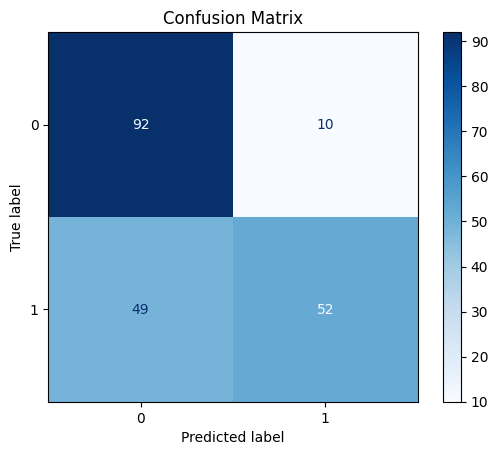

Confusion Matrix:
 [[92 10]
 [49 52]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1. Prediksi probabilitas
y_pred_prob = model.predict(X_test)

# 2. Konversi ke label 0/1 (threshold = 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# 3. Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 4. Tampilkan
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Opsional: cetak nilai CM
print("Confusion Matrix:\n", cm)

In [ ]:
# Hitung jumlah sampel per kelas
unique_classes, counts = np.unique(y, return_counts=True)

print("Jumlah sampel per kelas:")
for class_value, count in zip(unique_classes, counts):
    if class_value == 0:
        label_name = "ADL"
    elif class_value == 1:
        label_name = "Fall"
    else:
        label_name = f"Class {class_value}"
    print(f"- {label_name}: {count} sampel")

# Hitung persentase
total_samples = len(y)
print("\nPersentase sampel per kelas:")
for class_value, count in zip(unique_classes, counts):
    if class_value == 0:
        label_name = "ADL"
    elif class_value == 1:
        label_name = "Fall"
    else:
        label_name = f"Class {class_value}"
    percentage = (count / total_samples) * 100
    print(f"- {label_name}: {percentage:.2f}%")

Jumlah sampel per kelas:
- ADL: 677 sampel
- Fall: 675 sampel

Persentase sampel per kelas:
- ADL: 50.07%
- Fall: 49.93%


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/yamnet/tfJs/tfjs")

print("Path to model files:", path)


  0%|          | 0.00/4.00M [00:00<?, ?B/s]

  0%|          | 0.00/3.30M [00:00<?, ?B/s]




  0%|          | 0.00/98.4k [00:00<?, ?B/s]





  0%|          | 0.00/4.00M [00:00<?, ?B/s]

100%|██████████| 98.4k/98.4k [00:00<00:00, 1.37MB/s]



  0%|          | 0.00/4.00M [00:00<?, ?B/s]
 25%|██▌       | 1.00M/4.00M [00:00<00:00, 5.68MB/s]

100%|██████████| 3.30M/3.30M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.00M/4.00M [00:00<00:00, 16.9MB/s]




 25%|██▌       | 1.00M/4.00M [00:00<00:00, 5.83MB/s]


100%|██████████| 4.00M/4.00M [00:00<00:00, 17.3MB/s]
100%|██████████| 4.00M/4.00M [00:00<00:00, 17.0MB/s]

Path to model files: /root/.cache/kagglehub/models/google/yamnet/tfJs/tfjs/1
